In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(390464, 828)
(390464, 8)
validation
(50536, 828)
(50536, 8)
test
(48320, 828)
(48320, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/40 [..............................] - ETA: 49s - loss: 1.9965 - STD: 0.1182 - MAE: 0.2110

 4/40 [==>...........................] - ETA: 1s - loss: 1.5565 - STD: 0.1670 - MAE: 0.1651 

 5/40 [==>...........................] - ETA: 1s - loss: 1.5147 - STD: 0.1818 - MAE: 0.1572

 6/40 [===>..........................] - ETA: 1s - loss: 1.4842 - STD: 0.1911 - MAE: 0.1521

 7/40 [====>.........................] - ETA: 2s - loss: 1.4594 - STD: 0.1962 - MAE: 0.1491

 8/40 [=====>........................] - ETA: 2s - loss: 1.4386 - STD: 0.1979 - MAE: 0.1476

 9/40 [=====>........................] - ETA: 2s - loss: 1.4210 - STD: 0.1972 - MAE: 0.1472

10/40 [======>.......................] - ETA: 2s - loss: 1.4088 - STD: 0.1952 - MAE: 0.1474

11/40 [=======>......................] - ETA: 2s - loss: 1.4008 - STD: 0.1927 - MAE: 0.1481

12/40 [========>.....................] - ETA: 2s - loss: 1.3927 - STD: 0.1906 - MAE: 0.1486

13/40 [========>.....................] - ETA: 2s - loss: 1.3859 - STD: 0.1890 - MAE: 0.1489

14/40 [=========>....................] - ETA: 2s - loss: 1.3797 - STD: 0.1883 - MAE: 0.1490

15/40 [==========>...................] - ETA: 1s - loss: 1.3728 - STD: 0.1883 - MAE: 0.1486

16/40 [===========>..................] - ETA: 1s - loss: 1.3677 - STD: 0.1890 - MAE: 0.1481

17/40 [===========>..................] - ETA: 1s - loss: 1.3633 - STD: 0.1901 - MAE: 0.1475

18/40 [============>.................] - ETA: 1s - loss: 1.3602 - STD: 0.1915 - MAE: 0.1468

19/40 [=============>................] - ETA: 1s - loss: 1.3566 - STD: 0.1930 - MAE: 0.1461

20/40 [==============>...............] - ETA: 1s - loss: 1.3531 - STD: 0.1943 - MAE: 0.1454

21/40 [==============>...............] - ETA: 1s - loss: 1.3507 - STD: 0.1953 - MAE: 0.1449

22/40 [===============>..............] - ETA: 1s - loss: 1.3479 - STD: 0.1961 - MAE: 0.1445

23/40 [================>.............] - ETA: 1s - loss: 1.3449 - STD: 0.1965 - MAE: 0.1442

24/40 [=================>............] - ETA: 1s - loss: 1.3436 - STD: 0.1966 - MAE: 0.1441

25/40 [=================>............] - ETA: 1s - loss: 1.3412 - STD: 0.1964 - MAE: 0.1441

26/40 [==================>...........] - ETA: 1s - loss: 1.3386 - STD: 0.1960 - MAE: 0.1441

27/40 [===================>..........] - ETA: 1s - loss: 1.3368 - STD: 0.1956 - MAE: 0.1442

28/40 [====================>.........] - ETA: 1s - loss: 1.3346 - STD: 0.1952 - MAE: 0.1442

29/40 [====================>.........] - ETA: 1s - loss: 1.3344 - STD: 0.1949 - MAE: 0.1442

33/40 [=======================>......] - ETA: 0s - loss: 1.3292 - STD: 0.1954 - MAE: 0.1438

34/40 [========================>.....] - ETA: 0s - loss: 1.3277 - STD: 0.1958 - MAE: 0.1436

35/40 [=========================>....] - ETA: 0s - loss: 1.3260 - STD: 0.1961 - MAE: 0.1434

36/40 [==========================>...] - ETA: 0s - loss: 1.3252 - STD: 0.1963 - MAE: 0.1433

37/40 [==========================>...] - ETA: 0s - loss: 1.3242 - STD: 0.1965 - MAE: 0.1432

38/40 [===========================>..] - ETA: 0s - loss: 1.3231 - STD: 0.1966 - MAE: 0.1432

39/40 [============================>.] - ETA: 0s - loss: 1.3223 - STD: 0.1966 - MAE: 0.1431

40/40 [==============================] - ETA: 0s - loss: 1.3217 - STD: 0.1965 - MAE: 0.1432

40/40 [==============================] - 6s 110ms/step - loss: 1.3217 - STD: 0.1965 - MAE: 0.1432 - val_loss: 1.2258 - val_STD: 0.1895 - val_MAE: 0.1464


Epoch 2/10000


 1/40 [..............................] - ETA: 5s - loss: 1.2980 - STD: 0.1895 - MAE: 0.1459

 3/40 [=>............................] - ETA: 1s - loss: 1.2918 - STD: 0.1876 - MAE: 0.1466

 4/40 [==>...........................] - ETA: 2s - loss: 1.2891 - STD: 0.1873 - MAE: 0.1464

 5/40 [==>...........................] - ETA: 2s - loss: 1.2886 - STD: 0.1876 - MAE: 0.1462

 6/40 [===>..........................] - ETA: 2s - loss: 1.2852 - STD: 0.1883 - MAE: 0.1458

 7/40 [====>.........................] - ETA: 2s - loss: 1.2852 - STD: 0.1893 - MAE: 0.1453

 8/40 [=====>........................] - ETA: 2s - loss: 1.2821 - STD: 0.1904 - MAE: 0.1446

 9/40 [=====>........................] - ETA: 2s - loss: 1.2812 - STD: 0.1917 - MAE: 0.1440

10/40 [======>.......................] - ETA: 2s - loss: 1.2789 - STD: 0.1929 - MAE: 0.1434

11/40 [=======>......................] - ETA: 2s - loss: 1.2795 - STD: 0.1939 - MAE: 0.1430

12/40 [========>.....................] - ETA: 2s - loss: 1.2799 - STD: 0.1947 - MAE: 0.1427

13/40 [========>.....................] - ETA: 2s - loss: 1.2793 - STD: 0.1952 - MAE: 0.1424

14/40 [=========>....................] - ETA: 2s - loss: 1.2776 - STD: 0.1954 - MAE: 0.1422

15/40 [==========>...................] - ETA: 2s - loss: 1.2788 - STD: 0.1955 - MAE: 0.1423

16/40 [===========>..................] - ETA: 2s - loss: 1.2798 - STD: 0.1953 - MAE: 0.1424

17/40 [===========>..................] - ETA: 1s - loss: 1.2803 - STD: 0.1950 - MAE: 0.1425

18/40 [============>.................] - ETA: 1s - loss: 1.2805 - STD: 0.1946 - MAE: 0.1427

19/40 [=============>................] - ETA: 1s - loss: 1.2824 - STD: 0.1943 - MAE: 0.1429

20/40 [==============>...............] - ETA: 1s - loss: 1.2832 - STD: 0.1940 - MAE: 0.1430

21/40 [==============>...............] - ETA: 1s - loss: 1.2827 - STD: 0.1938 - MAE: 0.1431

22/40 [===============>..............] - ETA: 1s - loss: 1.2814 - STD: 0.1937 - MAE: 0.1431

23/40 [================>.............] - ETA: 1s - loss: 1.2810 - STD: 0.1938 - MAE: 0.1430

24/40 [=================>............] - ETA: 1s - loss: 1.2810 - STD: 0.1940 - MAE: 0.1429

25/40 [=================>............] - ETA: 1s - loss: 1.2807 - STD: 0.1942 - MAE: 0.1428

26/40 [==================>...........] - ETA: 1s - loss: 1.2807 - STD: 0.1945 - MAE: 0.1427

27/40 [===================>..........] - ETA: 1s - loss: 1.2806 - STD: 0.1947 - MAE: 0.1427

28/40 [====================>.........] - ETA: 1s - loss: 1.2808 - STD: 0.1948 - MAE: 0.1426

29/40 [====================>.........] - ETA: 0s - loss: 1.2813 - STD: 0.1948 - MAE: 0.1426

30/40 [=====================>........] - ETA: 0s - loss: 1.2815 - STD: 0.1948 - MAE: 0.1427

31/40 [======================>.......] - ETA: 0s - loss: 1.2808 - STD: 0.1946 - MAE: 0.1427

32/40 [=======================>......] - ETA: 0s - loss: 1.2808 - STD: 0.1945 - MAE: 0.1427

33/40 [=======================>......] - ETA: 0s - loss: 1.2803 - STD: 0.1944 - MAE: 0.1428

34/40 [========================>.....] - ETA: 0s - loss: 1.2804 - STD: 0.1943 - MAE: 0.1428

35/40 [=========================>....] - ETA: 0s - loss: 1.2807 - STD: 0.1943 - MAE: 0.1428

36/40 [==========================>...] - ETA: 0s - loss: 1.2803 - STD: 0.1943 - MAE: 0.1428

37/40 [==========================>...] - ETA: 0s - loss: 1.2807 - STD: 0.1944 - MAE: 0.1428

38/40 [===========================>..] - ETA: 0s - loss: 1.2810 - STD: 0.1945 - MAE: 0.1428

39/40 [============================>.] - ETA: 0s - loss: 1.2809 - STD: 0.1945 - MAE: 0.1427

40/40 [==============================] - ETA: 0s - loss: 1.2805 - STD: 0.1945 - MAE: 0.1427

40/40 [==============================] - 4s 93ms/step - loss: 1.2805 - STD: 0.1945 - MAE: 0.1427 - val_loss: 1.2118 - val_STD: 0.1936 - val_MAE: 0.1440


Epoch 3/10000


 1/40 [..............................] - ETA: 4s - loss: 1.2734 - STD: 0.1939 - MAE: 0.1424

 2/40 [>.............................] - ETA: 3s - loss: 1.2756 - STD: 0.1938 - MAE: 0.1425

 4/40 [==>...........................] - ETA: 2s - loss: 1.2760 - STD: 0.1939 - MAE: 0.1426

 5/40 [==>...........................] - ETA: 2s - loss: 1.2718 - STD: 0.1940 - MAE: 0.1425

 6/40 [===>..........................] - ETA: 2s - loss: 1.2734 - STD: 0.1941 - MAE: 0.1425

 7/40 [====>.........................] - ETA: 2s - loss: 1.2704 - STD: 0.1942 - MAE: 0.1423

 8/40 [=====>........................] - ETA: 2s - loss: 1.2667 - STD: 0.1944 - MAE: 0.1420

 9/40 [=====>........................] - ETA: 2s - loss: 1.2643 - STD: 0.1947 - MAE: 0.1417

10/40 [======>.......................] - ETA: 2s - loss: 1.2644 - STD: 0.1950 - MAE: 0.1416

11/40 [=======>......................] - ETA: 2s - loss: 1.2644 - STD: 0.1951 - MAE: 0.1415

12/40 [========>.....................] - ETA: 2s - loss: 1.2646 - STD: 0.1952 - MAE: 0.1415

13/40 [========>.....................] - ETA: 2s - loss: 1.2640 - STD: 0.1951 - MAE: 0.1415

14/40 [=========>....................] - ETA: 2s - loss: 1.2626 - STD: 0.1950 - MAE: 0.1415

15/40 [==========>...................] - ETA: 2s - loss: 1.2618 - STD: 0.1949 - MAE: 0.1414

16/40 [===========>..................] - ETA: 2s - loss: 1.2600 - STD: 0.1951 - MAE: 0.1412

17/40 [===========>..................] - ETA: 2s - loss: 1.2598 - STD: 0.1954 - MAE: 0.1411

18/40 [============>.................] - ETA: 1s - loss: 1.2591 - STD: 0.1956 - MAE: 0.1410

19/40 [=============>................] - ETA: 1s - loss: 1.2578 - STD: 0.1957 - MAE: 0.1409

20/40 [==============>...............] - ETA: 1s - loss: 1.2568 - STD: 0.1956 - MAE: 0.1408

21/40 [==============>...............] - ETA: 1s - loss: 1.2553 - STD: 0.1956 - MAE: 0.1408

22/40 [===============>..............] - ETA: 1s - loss: 1.2544 - STD: 0.1958 - MAE: 0.1407

23/40 [================>.............] - ETA: 1s - loss: 1.2531 - STD: 0.1960 - MAE: 0.1405

24/40 [=================>............] - ETA: 1s - loss: 1.2521 - STD: 0.1963 - MAE: 0.1404

25/40 [=================>............] - ETA: 1s - loss: 1.2509 - STD: 0.1964 - MAE: 0.1402

26/40 [==================>...........] - ETA: 1s - loss: 1.2501 - STD: 0.1966 - MAE: 0.1402

27/40 [===================>..........] - ETA: 1s - loss: 1.2499 - STD: 0.1967 - MAE: 0.1401

28/40 [====================>.........] - ETA: 1s - loss: 1.2490 - STD: 0.1967 - MAE: 0.1400

29/40 [====================>.........] - ETA: 0s - loss: 1.2481 - STD: 0.1968 - MAE: 0.1400

30/40 [=====================>........] - ETA: 0s - loss: 1.2470 - STD: 0.1970 - MAE: 0.1399

31/40 [======================>.......] - ETA: 0s - loss: 1.2457 - STD: 0.1973 - MAE: 0.1397

32/40 [=======================>......] - ETA: 0s - loss: 1.2446 - STD: 0.1974 - MAE: 0.1396

33/40 [=======================>......] - ETA: 0s - loss: 1.2440 - STD: 0.1975 - MAE: 0.1395

34/40 [========================>.....] - ETA: 0s - loss: 1.2430 - STD: 0.1976 - MAE: 0.1395

35/40 [=========================>....] - ETA: 0s - loss: 1.2419 - STD: 0.1977 - MAE: 0.1394

36/40 [==========================>...] - ETA: 0s - loss: 1.2406 - STD: 0.1978 - MAE: 0.1392

37/40 [==========================>...] - ETA: 0s - loss: 1.2401 - STD: 0.1980 - MAE: 0.1391

38/40 [===========================>..] - ETA: 0s - loss: 1.2394 - STD: 0.1982 - MAE: 0.1391

39/40 [============================>.] - ETA: 0s - loss: 1.2380 - STD: 0.1983 - MAE: 0.1389

40/40 [==============================] - ETA: 0s - loss: 1.2378 - STD: 0.1984 - MAE: 0.1389

40/40 [==============================] - 4s 94ms/step - loss: 1.2378 - STD: 0.1984 - MAE: 0.1389 - val_loss: 1.1288 - val_STD: 0.1922 - val_MAE: 0.1396


Epoch 4/10000


 1/40 [..............................] - ETA: 4s - loss: 1.1991 - STD: 0.2036 - MAE: 0.1352

 2/40 [>.............................] - ETA: 3s - loss: 1.1934 - STD: 0.2038 - MAE: 0.1348

 3/40 [=>............................] - ETA: 3s - loss: 1.1926 - STD: 0.2049 - MAE: 0.1343

 4/40 [==>...........................] - ETA: 3s - loss: 1.1926 - STD: 0.2043 - MAE: 0.1345

 6/40 [===>..........................] - ETA: 2s - loss: 1.1972 - STD: 0.2007 - MAE: 0.1369

 7/40 [====>.........................] - ETA: 2s - loss: 1.1955 - STD: 0.1995 - MAE: 0.1372

 8/40 [=====>........................] - ETA: 2s - loss: 1.1951 - STD: 0.2011 - MAE: 0.1365

 9/40 [=====>........................] - ETA: 2s - loss: 1.1940 - STD: 0.2028 - MAE: 0.1357

10/40 [======>.......................] - ETA: 2s - loss: 1.1925 - STD: 0.2032 - MAE: 0.1355

11/40 [=======>......................] - ETA: 2s - loss: 1.1931 - STD: 0.2025 - MAE: 0.1358

12/40 [========>.....................] - ETA: 2s - loss: 1.1921 - STD: 0.2020 - MAE: 0.1359

13/40 [========>.....................] - ETA: 2s - loss: 1.1916 - STD: 0.2026 - MAE: 0.1356

14/40 [=========>....................] - ETA: 2s - loss: 1.1918 - STD: 0.2035 - MAE: 0.1353

15/40 [==========>...................] - ETA: 2s - loss: 1.1914 - STD: 0.2039 - MAE: 0.1351

16/40 [===========>..................] - ETA: 2s - loss: 1.1922 - STD: 0.2034 - MAE: 0.1353

17/40 [===========>..................] - ETA: 1s - loss: 1.1914 - STD: 0.2027 - MAE: 0.1356

18/40 [============>.................] - ETA: 1s - loss: 1.1899 - STD: 0.2027 - MAE: 0.1355

19/40 [=============>................] - ETA: 1s - loss: 1.1892 - STD: 0.2031 - MAE: 0.1353

20/40 [==============>...............] - ETA: 1s - loss: 1.1886 - STD: 0.2035 - MAE: 0.1351

21/40 [==============>...............] - ETA: 1s - loss: 1.1882 - STD: 0.2036 - MAE: 0.1351

22/40 [===============>..............] - ETA: 1s - loss: 1.1880 - STD: 0.2034 - MAE: 0.1351

23/40 [================>.............] - ETA: 1s - loss: 1.1873 - STD: 0.2033 - MAE: 0.1352

24/40 [=================>............] - ETA: 1s - loss: 1.1872 - STD: 0.2034 - MAE: 0.1351

25/40 [=================>............] - ETA: 1s - loss: 1.1866 - STD: 0.2037 - MAE: 0.1350

26/40 [==================>...........] - ETA: 1s - loss: 1.1847 - STD: 0.2038 - MAE: 0.1349

27/40 [===================>..........] - ETA: 1s - loss: 1.1840 - STD: 0.2037 - MAE: 0.1349

28/40 [====================>.........] - ETA: 1s - loss: 1.1834 - STD: 0.2036 - MAE: 0.1349

29/40 [====================>.........] - ETA: 0s - loss: 1.1829 - STD: 0.2036 - MAE: 0.1348

30/40 [=====================>........] - ETA: 0s - loss: 1.1825 - STD: 0.2038 - MAE: 0.1347

31/40 [======================>.......] - ETA: 0s - loss: 1.1818 - STD: 0.2040 - MAE: 0.1346

32/40 [=======================>......] - ETA: 0s - loss: 1.1807 - STD: 0.2041 - MAE: 0.1346

33/40 [=======================>......] - ETA: 0s - loss: 1.1797 - STD: 0.2041 - MAE: 0.1345

34/40 [========================>.....] - ETA: 0s - loss: 1.1791 - STD: 0.2042 - MAE: 0.1344

35/40 [=========================>....] - ETA: 0s - loss: 1.1788 - STD: 0.2043 - MAE: 0.1344

36/40 [==========================>...] - ETA: 0s - loss: 1.1783 - STD: 0.2044 - MAE: 0.1343

37/40 [==========================>...] - ETA: 0s - loss: 1.1779 - STD: 0.2043 - MAE: 0.1344

38/40 [===========================>..] - ETA: 0s - loss: 1.1774 - STD: 0.2043 - MAE: 0.1344

39/40 [============================>.] - ETA: 0s - loss: 1.1770 - STD: 0.2043 - MAE: 0.1343

40/40 [==============================] - ETA: 0s - loss: 1.1772 - STD: 0.2044 - MAE: 0.1343

40/40 [==============================] - 4s 92ms/step - loss: 1.1772 - STD: 0.2044 - MAE: 0.1343 - val_loss: 1.0829 - val_STD: 0.1883 - val_MAE: 0.1392


Epoch 5/10000


 1/40 [..............................] - ETA: 5s - loss: 1.1612 - STD: 0.2052 - MAE: 0.1333

 2/40 [>.............................] - ETA: 3s - loss: 1.1612 - STD: 0.2033 - MAE: 0.1341

 3/40 [=>............................] - ETA: 3s - loss: 1.1579 - STD: 0.2038 - MAE: 0.1338

 4/40 [==>...........................] - ETA: 3s - loss: 1.1570 - STD: 0.2052 - MAE: 0.1332

 5/40 [==>...........................] - ETA: 3s - loss: 1.1569 - STD: 0.2055 - MAE: 0.1331

 6/40 [===>..........................] - ETA: 3s - loss: 1.1586 - STD: 0.2052 - MAE: 0.1333

 7/40 [====>.........................] - ETA: 3s - loss: 1.1586 - STD: 0.2049 - MAE: 0.1334

 8/40 [=====>........................] - ETA: 2s - loss: 1.1580 - STD: 0.2049 - MAE: 0.1334

 9/40 [=====>........................] - ETA: 2s - loss: 1.1563 - STD: 0.2052 - MAE: 0.1332

11/40 [=======>......................] - ETA: 2s - loss: 1.1559 - STD: 0.2054 - MAE: 0.1333

12/40 [========>.....................] - ETA: 2s - loss: 1.1555 - STD: 0.2054 - MAE: 0.1333

13/40 [========>.....................] - ETA: 2s - loss: 1.1543 - STD: 0.2053 - MAE: 0.1333

14/40 [=========>....................] - ETA: 2s - loss: 1.1539 - STD: 0.2052 - MAE: 0.1333

15/40 [==========>...................] - ETA: 2s - loss: 1.1525 - STD: 0.2050 - MAE: 0.1333

16/40 [===========>..................] - ETA: 2s - loss: 1.1506 - STD: 0.2051 - MAE: 0.1332

17/40 [===========>..................] - ETA: 1s - loss: 1.1492 - STD: 0.2055 - MAE: 0.1329

18/40 [============>.................] - ETA: 1s - loss: 1.1480 - STD: 0.2058 - MAE: 0.1327

19/40 [=============>................] - ETA: 1s - loss: 1.1482 - STD: 0.2060 - MAE: 0.1327

20/40 [==============>...............] - ETA: 1s - loss: 1.1466 - STD: 0.2056 - MAE: 0.1328

21/40 [==============>...............] - ETA: 1s - loss: 1.1455 - STD: 0.2057 - MAE: 0.1327

22/40 [===============>..............] - ETA: 1s - loss: 1.1449 - STD: 0.2061 - MAE: 0.1324

23/40 [================>.............] - ETA: 1s - loss: 1.1444 - STD: 0.2063 - MAE: 0.1324

24/40 [=================>............] - ETA: 1s - loss: 1.1432 - STD: 0.2061 - MAE: 0.1324

25/40 [=================>............] - ETA: 1s - loss: 1.1410 - STD: 0.2062 - MAE: 0.1323

26/40 [==================>...........] - ETA: 1s - loss: 1.1408 - STD: 0.2065 - MAE: 0.1321

27/40 [===================>..........] - ETA: 1s - loss: 1.1397 - STD: 0.2063 - MAE: 0.1321

28/40 [====================>.........] - ETA: 1s - loss: 1.1375 - STD: 0.2063 - MAE: 0.1320

29/40 [====================>.........] - ETA: 0s - loss: 1.1371 - STD: 0.2068 - MAE: 0.1318

30/40 [=====================>........] - ETA: 0s - loss: 1.1358 - STD: 0.2069 - MAE: 0.1317

31/40 [======================>.......] - ETA: 0s - loss: 1.1349 - STD: 0.2067 - MAE: 0.1317

32/40 [=======================>......] - ETA: 0s - loss: 1.1342 - STD: 0.2068 - MAE: 0.1317

33/40 [=======================>......] - ETA: 0s - loss: 1.1336 - STD: 0.2069 - MAE: 0.1316

34/40 [========================>.....] - ETA: 0s - loss: 1.1330 - STD: 0.2069 - MAE: 0.1316

35/40 [=========================>....] - ETA: 0s - loss: 1.1318 - STD: 0.2070 - MAE: 0.1315

36/40 [==========================>...] - ETA: 0s - loss: 1.1306 - STD: 0.2070 - MAE: 0.1314

37/40 [==========================>...] - ETA: 0s - loss: 1.1299 - STD: 0.2070 - MAE: 0.1314

38/40 [===========================>..] - ETA: 0s - loss: 1.1284 - STD: 0.2070 - MAE: 0.1313

39/40 [============================>.] - ETA: 0s - loss: 1.1280 - STD: 0.2073 - MAE: 0.1312

40/40 [==============================] - ETA: 0s - loss: 1.1270 - STD: 0.2071 - MAE: 0.1313

40/40 [==============================] - 4s 93ms/step - loss: 1.1270 - STD: 0.2071 - MAE: 0.1313 - val_loss: 1.0075 - val_STD: 0.1964 - val_MAE: 0.1332


Epoch 6/10000


 1/40 [..............................] - ETA: 5s - loss: 1.0676 - STD: 0.2124 - MAE: 0.1266

 2/40 [>.............................] - ETA: 3s - loss: 1.0748 - STD: 0.2162 - MAE: 0.1256

 3/40 [=>............................] - ETA: 3s - loss: 1.0768 - STD: 0.2107 - MAE: 0.1278

 4/40 [==>...........................] - ETA: 3s - loss: 1.0765 - STD: 0.2105 - MAE: 0.1279

 5/40 [==>...........................] - ETA: 3s - loss: 1.0735 - STD: 0.2120 - MAE: 0.1271

 6/40 [===>..........................] - ETA: 3s - loss: 1.0734 - STD: 0.2118 - MAE: 0.1272

 8/40 [=====>........................] - ETA: 2s - loss: 1.0724 - STD: 0.2123 - MAE: 0.1268

 9/40 [=====>........................] - ETA: 2s - loss: 1.0685 - STD: 0.2116 - MAE: 0.1269

10/40 [======>.......................] - ETA: 2s - loss: 1.0674 - STD: 0.2118 - MAE: 0.1268

11/40 [=======>......................] - ETA: 2s - loss: 1.0662 - STD: 0.2127 - MAE: 0.1264

12/40 [========>.....................] - ETA: 2s - loss: 1.0667 - STD: 0.2124 - MAE: 0.1266

13/40 [========>.....................] - ETA: 2s - loss: 1.0654 - STD: 0.2120 - MAE: 0.1267

14/40 [=========>....................] - ETA: 2s - loss: 1.0642 - STD: 0.2128 - MAE: 0.1263

15/40 [==========>...................] - ETA: 2s - loss: 1.0643 - STD: 0.2131 - MAE: 0.1262

16/40 [===========>..................] - ETA: 2s - loss: 1.0642 - STD: 0.2125 - MAE: 0.1265

17/40 [===========>..................] - ETA: 1s - loss: 1.0629 - STD: 0.2125 - MAE: 0.1264

18/40 [============>.................] - ETA: 1s - loss: 1.0631 - STD: 0.2131 - MAE: 0.1262

19/40 [=============>................] - ETA: 1s - loss: 1.0626 - STD: 0.2131 - MAE: 0.1262

20/40 [==============>...............] - ETA: 1s - loss: 1.0617 - STD: 0.2126 - MAE: 0.1264

21/40 [==============>...............] - ETA: 1s - loss: 1.0613 - STD: 0.2129 - MAE: 0.1263

22/40 [===============>..............] - ETA: 1s - loss: 1.0604 - STD: 0.2133 - MAE: 0.1261

23/40 [================>.............] - ETA: 1s - loss: 1.0598 - STD: 0.2129 - MAE: 0.1262

24/40 [=================>............] - ETA: 1s - loss: 1.0586 - STD: 0.2126 - MAE: 0.1263

25/40 [=================>............] - ETA: 1s - loss: 1.0585 - STD: 0.2132 - MAE: 0.1261

26/40 [==================>...........] - ETA: 1s - loss: 1.0576 - STD: 0.2134 - MAE: 0.1260

27/40 [===================>..........] - ETA: 1s - loss: 1.0566 - STD: 0.2132 - MAE: 0.1261

28/40 [====================>.........] - ETA: 1s - loss: 1.0558 - STD: 0.2131 - MAE: 0.1261

29/40 [====================>.........] - ETA: 0s - loss: 1.0552 - STD: 0.2134 - MAE: 0.1260

30/40 [=====================>........] - ETA: 0s - loss: 1.0539 - STD: 0.2136 - MAE: 0.1259

31/40 [======================>.......] - ETA: 0s - loss: 1.0523 - STD: 0.2135 - MAE: 0.1259

32/40 [=======================>......] - ETA: 0s - loss: 1.0512 - STD: 0.2134 - MAE: 0.1259

33/40 [=======================>......] - ETA: 0s - loss: 1.0499 - STD: 0.2136 - MAE: 0.1257

34/40 [========================>.....] - ETA: 0s - loss: 1.0491 - STD: 0.2138 - MAE: 0.1257

35/40 [=========================>....] - ETA: 0s - loss: 1.0483 - STD: 0.2136 - MAE: 0.1257

36/40 [==========================>...] - ETA: 0s - loss: 1.0479 - STD: 0.2136 - MAE: 0.1257

37/40 [==========================>...] - ETA: 0s - loss: 1.0471 - STD: 0.2137 - MAE: 0.1256

38/40 [===========================>..] - ETA: 0s - loss: 1.0458 - STD: 0.2137 - MAE: 0.1256

39/40 [============================>.] - ETA: 0s - loss: 1.0450 - STD: 0.2138 - MAE: 0.1256

40/40 [==============================] - ETA: 0s - loss: 1.0438 - STD: 0.2139 - MAE: 0.1255

40/40 [==============================] - 4s 94ms/step - loss: 1.0438 - STD: 0.2139 - MAE: 0.1255 - val_loss: 0.9346 - val_STD: 0.2019 - val_MAE: 0.1293


Epoch 7/10000


 1/40 [..............................] - ETA: 4s - loss: 1.0114 - STD: 0.2169 - MAE: 0.1235

 2/40 [>.............................] - ETA: 3s - loss: 1.0038 - STD: 0.2148 - MAE: 0.1240

 3/40 [=>............................] - ETA: 3s - loss: 1.0096 - STD: 0.2151 - MAE: 0.1242

 4/40 [==>...........................] - ETA: 3s - loss: 1.0062 - STD: 0.2160 - MAE: 0.1236

 5/40 [==>...........................] - ETA: 3s - loss: 1.0059 - STD: 0.2164 - MAE: 0.1235

 6/40 [===>..........................] - ETA: 3s - loss: 1.0029 - STD: 0.2161 - MAE: 0.1235

 7/40 [====>.........................] - ETA: 3s - loss: 0.9999 - STD: 0.2165 - MAE: 0.1232

 8/40 [=====>........................] - ETA: 2s - loss: 0.9986 - STD: 0.2170 - MAE: 0.1229

 9/40 [=====>........................] - ETA: 2s - loss: 0.9966 - STD: 0.2168 - MAE: 0.1229

10/40 [======>.......................] - ETA: 2s - loss: 0.9941 - STD: 0.2168 - MAE: 0.1228

11/40 [=======>......................] - ETA: 2s - loss: 0.9929 - STD: 0.2175 - MAE: 0.1225

12/40 [========>.....................] - ETA: 2s - loss: 0.9939 - STD: 0.2177 - MAE: 0.1224

13/40 [========>.....................] - ETA: 2s - loss: 0.9933 - STD: 0.2171 - MAE: 0.1227

14/40 [=========>....................] - ETA: 2s - loss: 0.9935 - STD: 0.2167 - MAE: 0.1228

15/40 [==========>...................] - ETA: 2s - loss: 0.9918 - STD: 0.2172 - MAE: 0.1225

17/40 [===========>..................] - ETA: 1s - loss: 0.9922 - STD: 0.2166 - MAE: 0.1232

18/40 [============>.................] - ETA: 1s - loss: 0.9901 - STD: 0.2162 - MAE: 0.1232

19/40 [=============>................] - ETA: 1s - loss: 0.9899 - STD: 0.2169 - MAE: 0.1229

20/40 [==============>...............] - ETA: 1s - loss: 0.9884 - STD: 0.2177 - MAE: 0.1225

21/40 [==============>...............] - ETA: 1s - loss: 0.9879 - STD: 0.2175 - MAE: 0.1226

22/40 [===============>..............] - ETA: 1s - loss: 0.9871 - STD: 0.2170 - MAE: 0.1227

23/40 [================>.............] - ETA: 1s - loss: 0.9866 - STD: 0.2173 - MAE: 0.1226

24/40 [=================>............] - ETA: 1s - loss: 0.9856 - STD: 0.2178 - MAE: 0.1223

25/40 [=================>............] - ETA: 1s - loss: 0.9834 - STD: 0.2182 - MAE: 0.1220

26/40 [==================>...........] - ETA: 1s - loss: 0.9823 - STD: 0.2180 - MAE: 0.1220

27/40 [===================>..........] - ETA: 1s - loss: 0.9814 - STD: 0.2178 - MAE: 0.1220

28/40 [====================>.........] - ETA: 1s - loss: 0.9810 - STD: 0.2182 - MAE: 0.1219

29/40 [====================>.........] - ETA: 0s - loss: 0.9807 - STD: 0.2187 - MAE: 0.1216

30/40 [=====================>........] - ETA: 0s - loss: 0.9799 - STD: 0.2186 - MAE: 0.1216

31/40 [======================>.......] - ETA: 0s - loss: 0.9796 - STD: 0.2184 - MAE: 0.1217

32/40 [=======================>......] - ETA: 0s - loss: 0.9793 - STD: 0.2184 - MAE: 0.1217

33/40 [=======================>......] - ETA: 0s - loss: 0.9788 - STD: 0.2186 - MAE: 0.1216

34/40 [========================>.....] - ETA: 0s - loss: 0.9777 - STD: 0.2189 - MAE: 0.1214

35/40 [=========================>....] - ETA: 0s - loss: 0.9770 - STD: 0.2188 - MAE: 0.1214

36/40 [==========================>...] - ETA: 0s - loss: 0.9760 - STD: 0.2187 - MAE: 0.1214

37/40 [==========================>...] - ETA: 0s - loss: 0.9751 - STD: 0.2189 - MAE: 0.1213

38/40 [===========================>..] - ETA: 0s - loss: 0.9740 - STD: 0.2191 - MAE: 0.1211

39/40 [============================>.] - ETA: 0s - loss: 0.9731 - STD: 0.2193 - MAE: 0.1210

40/40 [==============================] - ETA: 0s - loss: 0.9720 - STD: 0.2192 - MAE: 0.1210

40/40 [==============================] - 4s 93ms/step - loss: 0.9720 - STD: 0.2192 - MAE: 0.1210 - val_loss: 0.8930 - val_STD: 0.2020 - val_MAE: 0.1283


Epoch 8/10000


 1/40 [..............................] - ETA: 4s - loss: 0.9411 - STD: 0.2166 - MAE: 0.1209

 2/40 [>.............................] - ETA: 3s - loss: 0.9371 - STD: 0.2223 - MAE: 0.1181

 3/40 [=>............................] - ETA: 3s - loss: 0.9323 - STD: 0.2247 - MAE: 0.1168

 4/40 [==>...........................] - ETA: 3s - loss: 0.9326 - STD: 0.2238 - MAE: 0.1172

 5/40 [==>...........................] - ETA: 3s - loss: 0.9339 - STD: 0.2229 - MAE: 0.1176

 6/40 [===>..........................] - ETA: 3s - loss: 0.9329 - STD: 0.2230 - MAE: 0.1175

 7/40 [====>.........................] - ETA: 3s - loss: 0.9362 - STD: 0.2234 - MAE: 0.1175

 8/40 [=====>........................] - ETA: 2s - loss: 0.9373 - STD: 0.2236 - MAE: 0.1175

 9/40 [=====>........................] - ETA: 2s - loss: 0.9373 - STD: 0.2231 - MAE: 0.1178

10/40 [======>.......................] - ETA: 2s - loss: 0.9388 - STD: 0.2226 - MAE: 0.1181

11/40 [=======>......................] - ETA: 2s - loss: 0.9403 - STD: 0.2230 - MAE: 0.1180

12/40 [========>.....................] - ETA: 2s - loss: 0.9397 - STD: 0.2233 - MAE: 0.1178

13/40 [========>.....................] - ETA: 2s - loss: 0.9397 - STD: 0.2230 - MAE: 0.1180

14/40 [=========>....................] - ETA: 2s - loss: 0.9399 - STD: 0.2231 - MAE: 0.1179

15/40 [==========>...................] - ETA: 2s - loss: 0.9398 - STD: 0.2230 - MAE: 0.1180

17/40 [===========>..................] - ETA: 2s - loss: 0.9397 - STD: 0.2228 - MAE: 0.1181

18/40 [============>.................] - ETA: 1s - loss: 0.9397 - STD: 0.2226 - MAE: 0.1182

19/40 [=============>................] - ETA: 1s - loss: 0.9385 - STD: 0.2228 - MAE: 0.1181

20/40 [==============>...............] - ETA: 1s - loss: 0.9380 - STD: 0.2232 - MAE: 0.1178

21/40 [==============>...............] - ETA: 1s - loss: 0.9368 - STD: 0.2232 - MAE: 0.1178

22/40 [===============>..............] - ETA: 1s - loss: 0.9366 - STD: 0.2230 - MAE: 0.1178

23/40 [================>.............] - ETA: 1s - loss: 0.9362 - STD: 0.2230 - MAE: 0.1178

24/40 [=================>............] - ETA: 1s - loss: 0.9359 - STD: 0.2232 - MAE: 0.1178

25/40 [=================>............] - ETA: 1s - loss: 0.9353 - STD: 0.2233 - MAE: 0.1177

26/40 [==================>...........] - ETA: 1s - loss: 0.9350 - STD: 0.2232 - MAE: 0.1177

27/40 [===================>..........] - ETA: 1s - loss: 0.9347 - STD: 0.2231 - MAE: 0.1178

28/40 [====================>.........] - ETA: 1s - loss: 0.9339 - STD: 0.2233 - MAE: 0.1177

29/40 [====================>.........] - ETA: 0s - loss: 0.9329 - STD: 0.2235 - MAE: 0.1175

30/40 [=====================>........] - ETA: 0s - loss: 0.9329 - STD: 0.2235 - MAE: 0.1175

31/40 [======================>.......] - ETA: 0s - loss: 0.9326 - STD: 0.2235 - MAE: 0.1175

32/40 [=======================>......] - ETA: 0s - loss: 0.9324 - STD: 0.2236 - MAE: 0.1175

33/40 [=======================>......] - ETA: 0s - loss: 0.9322 - STD: 0.2235 - MAE: 0.1175

34/40 [========================>.....] - ETA: 0s - loss: 0.9318 - STD: 0.2236 - MAE: 0.1174

35/40 [=========================>....] - ETA: 0s - loss: 0.9309 - STD: 0.2237 - MAE: 0.1173

36/40 [==========================>...] - ETA: 0s - loss: 0.9306 - STD: 0.2238 - MAE: 0.1173

37/40 [==========================>...] - ETA: 0s - loss: 0.9303 - STD: 0.2238 - MAE: 0.1173

38/40 [===========================>..] - ETA: 0s - loss: 0.9305 - STD: 0.2237 - MAE: 0.1173

39/40 [============================>.] - ETA: 0s - loss: 0.9296 - STD: 0.2238 - MAE: 0.1173

40/40 [==============================] - ETA: 0s - loss: 0.9289 - STD: 0.2241 - MAE: 0.1171

40/40 [==============================] - 4s 94ms/step - loss: 0.9289 - STD: 0.2241 - MAE: 0.1171 - val_loss: 0.8715 - val_STD: 0.2103 - val_MAE: 0.1234


Epoch 9/10000


 1/40 [..............................] - ETA: 4s - loss: 0.9127 - STD: 0.2284 - MAE: 0.1145

 2/40 [>.............................] - ETA: 3s - loss: 0.9075 - STD: 0.2261 - MAE: 0.1152

 3/40 [=>............................] - ETA: 3s - loss: 0.9133 - STD: 0.2250 - MAE: 0.1161

 4/40 [==>...........................] - ETA: 3s - loss: 0.9194 - STD: 0.2250 - MAE: 0.1164

 5/40 [==>...........................] - ETA: 3s - loss: 0.9219 - STD: 0.2259 - MAE: 0.1161

 6/40 [===>..........................] - ETA: 3s - loss: 0.9206 - STD: 0.2251 - MAE: 0.1164

 7/40 [====>.........................] - ETA: 2s - loss: 0.9187 - STD: 0.2246 - MAE: 0.1165

 8/40 [=====>........................] - ETA: 2s - loss: 0.9169 - STD: 0.2252 - MAE: 0.1162

 9/40 [=====>........................] - ETA: 2s - loss: 0.9167 - STD: 0.2257 - MAE: 0.1160

10/40 [======>.......................] - ETA: 2s - loss: 0.9179 - STD: 0.2250 - MAE: 0.1164

11/40 [=======>......................] - ETA: 2s - loss: 0.9188 - STD: 0.2245 - MAE: 0.1166

12/40 [========>.....................] - ETA: 2s - loss: 0.9184 - STD: 0.2248 - MAE: 0.1165

13/40 [========>.....................] - ETA: 2s - loss: 0.9193 - STD: 0.2252 - MAE: 0.1164

14/40 [=========>....................] - ETA: 2s - loss: 0.9177 - STD: 0.2251 - MAE: 0.1163

15/40 [==========>...................] - ETA: 2s - loss: 0.9174 - STD: 0.2250 - MAE: 0.1164

16/40 [===========>..................] - ETA: 2s - loss: 0.9164 - STD: 0.2250 - MAE: 0.1163

17/40 [===========>..................] - ETA: 2s - loss: 0.9156 - STD: 0.2253 - MAE: 0.1161

19/40 [=============>................] - ETA: 1s - loss: 0.9156 - STD: 0.2249 - MAE: 0.1165

20/40 [==============>...............] - ETA: 1s - loss: 0.9158 - STD: 0.2249 - MAE: 0.1165

21/40 [==============>...............] - ETA: 1s - loss: 0.9159 - STD: 0.2252 - MAE: 0.1164

22/40 [===============>..............] - ETA: 1s - loss: 0.9162 - STD: 0.2254 - MAE: 0.1163

23/40 [================>.............] - ETA: 1s - loss: 0.9157 - STD: 0.2252 - MAE: 0.1164

24/40 [=================>............] - ETA: 1s - loss: 0.9154 - STD: 0.2251 - MAE: 0.1164

25/40 [=================>............] - ETA: 1s - loss: 0.9147 - STD: 0.2252 - MAE: 0.1163

26/40 [==================>...........] - ETA: 1s - loss: 0.9152 - STD: 0.2256 - MAE: 0.1162

27/40 [===================>..........] - ETA: 1s - loss: 0.9153 - STD: 0.2255 - MAE: 0.1162

28/40 [====================>.........] - ETA: 1s - loss: 0.9156 - STD: 0.2252 - MAE: 0.1164

29/40 [====================>.........] - ETA: 0s - loss: 0.9147 - STD: 0.2252 - MAE: 0.1163

30/40 [=====================>........] - ETA: 0s - loss: 0.9147 - STD: 0.2255 - MAE: 0.1162

31/40 [======================>.......] - ETA: 0s - loss: 0.9138 - STD: 0.2256 - MAE: 0.1160

32/40 [=======================>......] - ETA: 0s - loss: 0.9129 - STD: 0.2256 - MAE: 0.1160

33/40 [=======================>......] - ETA: 0s - loss: 0.9126 - STD: 0.2256 - MAE: 0.1160

34/40 [========================>.....] - ETA: 0s - loss: 0.9123 - STD: 0.2257 - MAE: 0.1159

35/40 [=========================>....] - ETA: 0s - loss: 0.9125 - STD: 0.2257 - MAE: 0.1159

36/40 [==========================>...] - ETA: 0s - loss: 0.9122 - STD: 0.2257 - MAE: 0.1159

37/40 [==========================>...] - ETA: 0s - loss: 0.9119 - STD: 0.2256 - MAE: 0.1159

38/40 [===========================>..] - ETA: 0s - loss: 0.9113 - STD: 0.2257 - MAE: 0.1159

39/40 [============================>.] - ETA: 0s - loss: 0.9103 - STD: 0.2258 - MAE: 0.1158

40/40 [==============================] - ETA: 0s - loss: 0.9102 - STD: 0.2259 - MAE: 0.1157

40/40 [==============================] - 4s 92ms/step - loss: 0.9102 - STD: 0.2259 - MAE: 0.1157 - val_loss: 0.8710 - val_STD: 0.2083 - val_MAE: 0.1252


Epoch 10/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8980 - STD: 0.2244 - MAE: 0.1161

 2/40 [>.............................] - ETA: 3s - loss: 0.9030 - STD: 0.2253 - MAE: 0.1157

 3/40 [=>............................] - ETA: 3s - loss: 0.8984 - STD: 0.2262 - MAE: 0.1150

 4/40 [==>...........................] - ETA: 3s - loss: 0.8973 - STD: 0.2271 - MAE: 0.1145

 5/40 [==>...........................] - ETA: 3s - loss: 0.8951 - STD: 0.2273 - MAE: 0.1143

 6/40 [===>..........................] - ETA: 3s - loss: 0.8973 - STD: 0.2273 - MAE: 0.1144

 7/40 [====>.........................] - ETA: 3s - loss: 0.8956 - STD: 0.2271 - MAE: 0.1144

 8/40 [=====>........................] - ETA: 2s - loss: 0.8939 - STD: 0.2274 - MAE: 0.1142

 9/40 [=====>........................] - ETA: 2s - loss: 0.8937 - STD: 0.2279 - MAE: 0.1139

10/40 [======>.......................] - ETA: 2s - loss: 0.8951 - STD: 0.2278 - MAE: 0.1141

11/40 [=======>......................] - ETA: 2s - loss: 0.8964 - STD: 0.2272 - MAE: 0.1144

12/40 [========>.....................] - ETA: 2s - loss: 0.8980 - STD: 0.2267 - MAE: 0.1147

13/40 [========>.....................] - ETA: 2s - loss: 0.8979 - STD: 0.2270 - MAE: 0.1146

14/40 [=========>....................] - ETA: 2s - loss: 0.8964 - STD: 0.2275 - MAE: 0.1143

15/40 [==========>...................] - ETA: 2s - loss: 0.8960 - STD: 0.2275 - MAE: 0.1143

16/40 [===========>..................] - ETA: 2s - loss: 0.8956 - STD: 0.2274 - MAE: 0.1143

17/40 [===========>..................] - ETA: 2s - loss: 0.8954 - STD: 0.2274 - MAE: 0.1143

18/40 [============>.................] - ETA: 1s - loss: 0.8946 - STD: 0.2276 - MAE: 0.1141

19/40 [=============>................] - ETA: 1s - loss: 0.8946 - STD: 0.2277 - MAE: 0.1141

20/40 [==============>...............] - ETA: 1s - loss: 0.8943 - STD: 0.2276 - MAE: 0.1141

21/40 [==============>...............] - ETA: 1s - loss: 0.8947 - STD: 0.2277 - MAE: 0.1141

22/40 [===============>..............] - ETA: 1s - loss: 0.8945 - STD: 0.2278 - MAE: 0.1141

23/40 [================>.............] - ETA: 1s - loss: 0.8951 - STD: 0.2276 - MAE: 0.1142

24/40 [=================>............] - ETA: 1s - loss: 0.8958 - STD: 0.2274 - MAE: 0.1143

25/40 [=================>............] - ETA: 1s - loss: 0.8959 - STD: 0.2276 - MAE: 0.1142

26/40 [==================>...........] - ETA: 1s - loss: 0.8955 - STD: 0.2277 - MAE: 0.1142

27/40 [===================>..........] - ETA: 1s - loss: 0.8958 - STD: 0.2276 - MAE: 0.1142

28/40 [====================>.........] - ETA: 1s - loss: 0.8957 - STD: 0.2275 - MAE: 0.1143

29/40 [====================>.........] - ETA: 0s - loss: 0.8952 - STD: 0.2275 - MAE: 0.1142

30/40 [=====================>........] - ETA: 0s - loss: 0.8949 - STD: 0.2277 - MAE: 0.1141

31/40 [======================>.......] - ETA: 0s - loss: 0.8951 - STD: 0.2277 - MAE: 0.1141

32/40 [=======================>......] - ETA: 0s - loss: 0.8949 - STD: 0.2276 - MAE: 0.1142

33/40 [=======================>......] - ETA: 0s - loss: 0.8949 - STD: 0.2277 - MAE: 0.1142

34/40 [========================>.....] - ETA: 0s - loss: 0.8951 - STD: 0.2278 - MAE: 0.1141

35/40 [=========================>....] - ETA: 0s - loss: 0.8948 - STD: 0.2277 - MAE: 0.1142

37/40 [==========================>...] - ETA: 0s - loss: 0.8948 - STD: 0.2279 - MAE: 0.1140

38/40 [===========================>..] - ETA: 0s - loss: 0.8949 - STD: 0.2279 - MAE: 0.1140

39/40 [============================>.] - ETA: 0s - loss: 0.8947 - STD: 0.2278 - MAE: 0.1141

40/40 [==============================] - ETA: 0s - loss: 0.8946 - STD: 0.2279 - MAE: 0.1140

40/40 [==============================] - 4s 91ms/step - loss: 0.8946 - STD: 0.2279 - MAE: 0.1140 - val_loss: 0.8749 - val_STD: 0.2167 - val_MAE: 0.1216


Epoch 11/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8995 - STD: 0.2326 - MAE: 0.1126

 2/40 [>.............................] - ETA: 3s - loss: 0.8979 - STD: 0.2280 - MAE: 0.1142

 3/40 [=>............................] - ETA: 3s - loss: 0.8935 - STD: 0.2273 - MAE: 0.1142

 4/40 [==>...........................] - ETA: 3s - loss: 0.8924 - STD: 0.2287 - MAE: 0.1136

 5/40 [==>...........................] - ETA: 3s - loss: 0.8932 - STD: 0.2289 - MAE: 0.1136

 6/40 [===>..........................] - ETA: 3s - loss: 0.8919 - STD: 0.2286 - MAE: 0.1137

 7/40 [====>.........................] - ETA: 3s - loss: 0.8924 - STD: 0.2275 - MAE: 0.1142

 8/40 [=====>........................] - ETA: 2s - loss: 0.8911 - STD: 0.2274 - MAE: 0.1142

 9/40 [=====>........................] - ETA: 2s - loss: 0.8899 - STD: 0.2281 - MAE: 0.1138

10/40 [======>.......................] - ETA: 2s - loss: 0.8904 - STD: 0.2285 - MAE: 0.1136

12/40 [========>.....................] - ETA: 2s - loss: 0.8916 - STD: 0.2282 - MAE: 0.1137

13/40 [========>.....................] - ETA: 2s - loss: 0.8918 - STD: 0.2289 - MAE: 0.1134

14/40 [=========>....................] - ETA: 2s - loss: 0.8916 - STD: 0.2288 - MAE: 0.1135

15/40 [==========>...................] - ETA: 2s - loss: 0.8917 - STD: 0.2283 - MAE: 0.1137

16/40 [===========>..................] - ETA: 2s - loss: 0.8914 - STD: 0.2281 - MAE: 0.1138

17/40 [===========>..................] - ETA: 1s - loss: 0.8911 - STD: 0.2286 - MAE: 0.1135

18/40 [============>.................] - ETA: 1s - loss: 0.8910 - STD: 0.2290 - MAE: 0.1133

19/40 [=============>................] - ETA: 1s - loss: 0.8914 - STD: 0.2287 - MAE: 0.1135

20/40 [==============>...............] - ETA: 1s - loss: 0.8916 - STD: 0.2282 - MAE: 0.1138

21/40 [==============>...............] - ETA: 1s - loss: 0.8915 - STD: 0.2284 - MAE: 0.1137

22/40 [===============>..............] - ETA: 1s - loss: 0.8919 - STD: 0.2291 - MAE: 0.1134

23/40 [================>.............] - ETA: 1s - loss: 0.8909 - STD: 0.2289 - MAE: 0.1134

24/40 [=================>............] - ETA: 1s - loss: 0.8915 - STD: 0.2284 - MAE: 0.1137

25/40 [=================>............] - ETA: 1s - loss: 0.8913 - STD: 0.2283 - MAE: 0.1137

26/40 [==================>...........] - ETA: 1s - loss: 0.8913 - STD: 0.2288 - MAE: 0.1135

27/40 [===================>..........] - ETA: 1s - loss: 0.8909 - STD: 0.2290 - MAE: 0.1134

28/40 [====================>.........] - ETA: 1s - loss: 0.8905 - STD: 0.2287 - MAE: 0.1135

29/40 [====================>.........] - ETA: 0s - loss: 0.8901 - STD: 0.2285 - MAE: 0.1136

30/40 [=====================>........] - ETA: 0s - loss: 0.8891 - STD: 0.2286 - MAE: 0.1135

31/40 [======================>.......] - ETA: 0s - loss: 0.8884 - STD: 0.2288 - MAE: 0.1134

32/40 [=======================>......] - ETA: 0s - loss: 0.8885 - STD: 0.2289 - MAE: 0.1134

33/40 [=======================>......] - ETA: 0s - loss: 0.8883 - STD: 0.2288 - MAE: 0.1134

34/40 [========================>.....] - ETA: 0s - loss: 0.8878 - STD: 0.2286 - MAE: 0.1135

35/40 [=========================>....] - ETA: 0s - loss: 0.8875 - STD: 0.2287 - MAE: 0.1134

36/40 [==========================>...] - ETA: 0s - loss: 0.8868 - STD: 0.2288 - MAE: 0.1133

37/40 [==========================>...] - ETA: 0s - loss: 0.8860 - STD: 0.2289 - MAE: 0.1133

38/40 [===========================>..] - ETA: 0s - loss: 0.8856 - STD: 0.2289 - MAE: 0.1132

39/40 [============================>.] - ETA: 0s - loss: 0.8858 - STD: 0.2289 - MAE: 0.1133

40/40 [==============================] - ETA: 0s - loss: 0.8855 - STD: 0.2288 - MAE: 0.1133

40/40 [==============================] - 4s 93ms/step - loss: 0.8855 - STD: 0.2288 - MAE: 0.1133 - val_loss: 0.8581 - val_STD: 0.2141 - val_MAE: 0.1229


Epoch 12/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8694 - STD: 0.2291 - MAE: 0.1121

 2/40 [>.............................] - ETA: 3s - loss: 0.8749 - STD: 0.2319 - MAE: 0.1115

 3/40 [=>............................] - ETA: 3s - loss: 0.8756 - STD: 0.2311 - MAE: 0.1119

 4/40 [==>...........................] - ETA: 3s - loss: 0.8701 - STD: 0.2290 - MAE: 0.1126

 5/40 [==>...........................] - ETA: 3s - loss: 0.8708 - STD: 0.2286 - MAE: 0.1128

 6/40 [===>..........................] - ETA: 3s - loss: 0.8697 - STD: 0.2299 - MAE: 0.1121

 7/40 [====>.........................] - ETA: 2s - loss: 0.8684 - STD: 0.2306 - MAE: 0.1117

 8/40 [=====>........................] - ETA: 2s - loss: 0.8683 - STD: 0.2302 - MAE: 0.1119

 9/40 [=====>........................] - ETA: 2s - loss: 0.8681 - STD: 0.2298 - MAE: 0.1122

10/40 [======>.......................] - ETA: 2s - loss: 0.8674 - STD: 0.2297 - MAE: 0.1121

11/40 [=======>......................] - ETA: 2s - loss: 0.8681 - STD: 0.2301 - MAE: 0.1120

12/40 [========>.....................] - ETA: 2s - loss: 0.8681 - STD: 0.2308 - MAE: 0.1116

13/40 [========>.....................] - ETA: 2s - loss: 0.8671 - STD: 0.2304 - MAE: 0.1118

14/40 [=========>....................] - ETA: 2s - loss: 0.8671 - STD: 0.2300 - MAE: 0.1119

15/40 [==========>...................] - ETA: 2s - loss: 0.8678 - STD: 0.2304 - MAE: 0.1118

16/40 [===========>..................] - ETA: 2s - loss: 0.8672 - STD: 0.2307 - MAE: 0.1116

17/40 [===========>..................] - ETA: 2s - loss: 0.8684 - STD: 0.2304 - MAE: 0.1118

18/40 [============>.................] - ETA: 1s - loss: 0.8693 - STD: 0.2304 - MAE: 0.1118

19/40 [=============>................] - ETA: 1s - loss: 0.8690 - STD: 0.2304 - MAE: 0.1118

20/40 [==============>...............] - ETA: 1s - loss: 0.8689 - STD: 0.2303 - MAE: 0.1119

21/40 [==============>...............] - ETA: 1s - loss: 0.8686 - STD: 0.2304 - MAE: 0.1118

22/40 [===============>..............] - ETA: 1s - loss: 0.8679 - STD: 0.2306 - MAE: 0.1117

23/40 [================>.............] - ETA: 1s - loss: 0.8682 - STD: 0.2304 - MAE: 0.1118

24/40 [=================>............] - ETA: 1s - loss: 0.8688 - STD: 0.2303 - MAE: 0.1119

25/40 [=================>............] - ETA: 1s - loss: 0.8687 - STD: 0.2304 - MAE: 0.1118

26/40 [==================>...........] - ETA: 1s - loss: 0.8699 - STD: 0.2304 - MAE: 0.1119

27/40 [===================>..........] - ETA: 1s - loss: 0.8700 - STD: 0.2303 - MAE: 0.1120

28/40 [====================>.........] - ETA: 1s - loss: 0.8696 - STD: 0.2302 - MAE: 0.1120

29/40 [====================>.........] - ETA: 1s - loss: 0.8696 - STD: 0.2304 - MAE: 0.1119

30/40 [=====================>........] - ETA: 0s - loss: 0.8698 - STD: 0.2305 - MAE: 0.1119

31/40 [======================>.......] - ETA: 0s - loss: 0.8699 - STD: 0.2302 - MAE: 0.1120

32/40 [=======================>......] - ETA: 0s - loss: 0.8700 - STD: 0.2301 - MAE: 0.1121

33/40 [=======================>......] - ETA: 0s - loss: 0.8699 - STD: 0.2304 - MAE: 0.1119

34/40 [========================>.....] - ETA: 0s - loss: 0.8696 - STD: 0.2305 - MAE: 0.1119

35/40 [=========================>....] - ETA: 0s - loss: 0.8692 - STD: 0.2303 - MAE: 0.1119

36/40 [==========================>...] - ETA: 0s - loss: 0.8692 - STD: 0.2303 - MAE: 0.1119

38/40 [===========================>..] - ETA: 0s - loss: 0.8704 - STD: 0.2303 - MAE: 0.1120

39/40 [============================>.] - ETA: 0s - loss: 0.8703 - STD: 0.2303 - MAE: 0.1120

40/40 [==============================] - ETA: 0s - loss: 0.8710 - STD: 0.2305 - MAE: 0.1120

40/40 [==============================] - 4s 92ms/step - loss: 0.8710 - STD: 0.2305 - MAE: 0.1120 - val_loss: 0.8753 - val_STD: 0.2138 - val_MAE: 0.1243


Epoch 13/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8583 - STD: 0.2285 - MAE: 0.1124

 2/40 [>.............................] - ETA: 3s - loss: 0.8648 - STD: 0.2260 - MAE: 0.1139

 3/40 [=>............................] - ETA: 3s - loss: 0.8711 - STD: 0.2289 - MAE: 0.1127

 4/40 [==>...........................] - ETA: 3s - loss: 0.8756 - STD: 0.2314 - MAE: 0.1118

 5/40 [==>...........................] - ETA: 3s - loss: 0.8726 - STD: 0.2308 - MAE: 0.1119

 6/40 [===>..........................] - ETA: 3s - loss: 0.8729 - STD: 0.2289 - MAE: 0.1128

 7/40 [====>.........................] - ETA: 2s - loss: 0.8725 - STD: 0.2289 - MAE: 0.1128

 8/40 [=====>........................] - ETA: 2s - loss: 0.8736 - STD: 0.2308 - MAE: 0.1120

 9/40 [=====>........................] - ETA: 2s - loss: 0.8736 - STD: 0.2311 - MAE: 0.1119

10/40 [======>.......................] - ETA: 2s - loss: 0.8734 - STD: 0.2298 - MAE: 0.1124

11/40 [=======>......................] - ETA: 2s - loss: 0.8733 - STD: 0.2291 - MAE: 0.1128

12/40 [========>.....................] - ETA: 2s - loss: 0.8721 - STD: 0.2297 - MAE: 0.1125

13/40 [========>.....................] - ETA: 2s - loss: 0.8712 - STD: 0.2304 - MAE: 0.1121

14/40 [=========>....................] - ETA: 2s - loss: 0.8709 - STD: 0.2303 - MAE: 0.1121

15/40 [==========>...................] - ETA: 2s - loss: 0.8705 - STD: 0.2297 - MAE: 0.1124

16/40 [===========>..................] - ETA: 2s - loss: 0.8694 - STD: 0.2296 - MAE: 0.1123

17/40 [===========>..................] - ETA: 2s - loss: 0.8679 - STD: 0.2301 - MAE: 0.1120

18/40 [============>.................] - ETA: 1s - loss: 0.8676 - STD: 0.2305 - MAE: 0.1119

19/40 [=============>................] - ETA: 1s - loss: 0.8670 - STD: 0.2302 - MAE: 0.1120

20/40 [==============>...............] - ETA: 1s - loss: 0.8672 - STD: 0.2299 - MAE: 0.1122

21/40 [==============>...............] - ETA: 1s - loss: 0.8664 - STD: 0.2300 - MAE: 0.1120

22/40 [===============>..............] - ETA: 1s - loss: 0.8668 - STD: 0.2305 - MAE: 0.1118

23/40 [================>.............] - ETA: 1s - loss: 0.8663 - STD: 0.2306 - MAE: 0.1118

24/40 [=================>............] - ETA: 1s - loss: 0.8660 - STD: 0.2302 - MAE: 0.1120

25/40 [=================>............] - ETA: 1s - loss: 0.8652 - STD: 0.2302 - MAE: 0.1119

26/40 [==================>...........] - ETA: 1s - loss: 0.8655 - STD: 0.2305 - MAE: 0.1118

27/40 [===================>..........] - ETA: 1s - loss: 0.8649 - STD: 0.2306 - MAE: 0.1117

29/40 [====================>.........] - ETA: 0s - loss: 0.8650 - STD: 0.2301 - MAE: 0.1121

30/40 [=====================>........] - ETA: 0s - loss: 0.8646 - STD: 0.2302 - MAE: 0.1121

31/40 [======================>.......] - ETA: 0s - loss: 0.8642 - STD: 0.2305 - MAE: 0.1119

32/40 [=======================>......] - ETA: 0s - loss: 0.8640 - STD: 0.2306 - MAE: 0.1118

33/40 [=======================>......] - ETA: 0s - loss: 0.8638 - STD: 0.2304 - MAE: 0.1119

34/40 [========================>.....] - ETA: 0s - loss: 0.8636 - STD: 0.2303 - MAE: 0.1119

35/40 [=========================>....] - ETA: 0s - loss: 0.8636 - STD: 0.2304 - MAE: 0.1119

36/40 [==========================>...] - ETA: 0s - loss: 0.8633 - STD: 0.2305 - MAE: 0.1118

37/40 [==========================>...] - ETA: 0s - loss: 0.8636 - STD: 0.2306 - MAE: 0.1118

38/40 [===========================>..] - ETA: 0s - loss: 0.8632 - STD: 0.2304 - MAE: 0.1118

39/40 [============================>.] - ETA: 0s - loss: 0.8627 - STD: 0.2303 - MAE: 0.1119

40/40 [==============================] - ETA: 0s - loss: 0.8624 - STD: 0.2305 - MAE: 0.1118

40/40 [==============================] - 4s 91ms/step - loss: 0.8624 - STD: 0.2305 - MAE: 0.1118 - val_loss: 0.8321 - val_STD: 0.2209 - val_MAE: 0.1191


Epoch 14/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8628 - STD: 0.2349 - MAE: 0.1097

 2/40 [>.............................] - ETA: 3s - loss: 0.8511 - STD: 0.2323 - MAE: 0.1103

 3/40 [=>............................] - ETA: 3s - loss: 0.8557 - STD: 0.2315 - MAE: 0.1110

 4/40 [==>...........................] - ETA: 3s - loss: 0.8523 - STD: 0.2311 - MAE: 0.1110

 5/40 [==>...........................] - ETA: 3s - loss: 0.8532 - STD: 0.2311 - MAE: 0.1110

 7/40 [====>.........................] - ETA: 2s - loss: 0.8554 - STD: 0.2324 - MAE: 0.1103

 8/40 [=====>........................] - ETA: 2s - loss: 0.8556 - STD: 0.2321 - MAE: 0.1105

 9/40 [=====>........................] - ETA: 2s - loss: 0.8558 - STD: 0.2313 - MAE: 0.1109

10/40 [======>.......................] - ETA: 2s - loss: 0.8559 - STD: 0.2312 - MAE: 0.1109

11/40 [=======>......................] - ETA: 2s - loss: 0.8547 - STD: 0.2317 - MAE: 0.1106

12/40 [========>.....................] - ETA: 2s - loss: 0.8546 - STD: 0.2319 - MAE: 0.1106

13/40 [========>.....................] - ETA: 2s - loss: 0.8553 - STD: 0.2315 - MAE: 0.1108

14/40 [=========>....................] - ETA: 2s - loss: 0.8549 - STD: 0.2313 - MAE: 0.1108

15/40 [==========>...................] - ETA: 2s - loss: 0.8548 - STD: 0.2317 - MAE: 0.1107

16/40 [===========>..................] - ETA: 2s - loss: 0.8543 - STD: 0.2319 - MAE: 0.1106

17/40 [===========>..................] - ETA: 1s - loss: 0.8537 - STD: 0.2316 - MAE: 0.1107

18/40 [============>.................] - ETA: 1s - loss: 0.8531 - STD: 0.2316 - MAE: 0.1107

19/40 [=============>................] - ETA: 1s - loss: 0.8540 - STD: 0.2318 - MAE: 0.1106

20/40 [==============>...............] - ETA: 1s - loss: 0.8537 - STD: 0.2317 - MAE: 0.1106

21/40 [==============>...............] - ETA: 1s - loss: 0.8532 - STD: 0.2318 - MAE: 0.1106

22/40 [===============>..............] - ETA: 1s - loss: 0.8532 - STD: 0.2320 - MAE: 0.1105

23/40 [================>.............] - ETA: 1s - loss: 0.8530 - STD: 0.2320 - MAE: 0.1105

24/40 [=================>............] - ETA: 1s - loss: 0.8534 - STD: 0.2319 - MAE: 0.1106

25/40 [=================>............] - ETA: 1s - loss: 0.8531 - STD: 0.2320 - MAE: 0.1105

26/40 [==================>...........] - ETA: 1s - loss: 0.8524 - STD: 0.2320 - MAE: 0.1104

27/40 [===================>..........] - ETA: 1s - loss: 0.8524 - STD: 0.2320 - MAE: 0.1105

28/40 [====================>.........] - ETA: 1s - loss: 0.8526 - STD: 0.2320 - MAE: 0.1105

29/40 [====================>.........] - ETA: 0s - loss: 0.8517 - STD: 0.2321 - MAE: 0.1104

30/40 [=====================>........] - ETA: 0s - loss: 0.8516 - STD: 0.2321 - MAE: 0.1104

31/40 [======================>.......] - ETA: 0s - loss: 0.8511 - STD: 0.2321 - MAE: 0.1103

32/40 [=======================>......] - ETA: 0s - loss: 0.8510 - STD: 0.2323 - MAE: 0.1103

33/40 [=======================>......] - ETA: 0s - loss: 0.8513 - STD: 0.2322 - MAE: 0.1103

34/40 [========================>.....] - ETA: 0s - loss: 0.8516 - STD: 0.2322 - MAE: 0.1103

35/40 [=========================>....] - ETA: 0s - loss: 0.8514 - STD: 0.2322 - MAE: 0.1103

36/40 [==========================>...] - ETA: 0s - loss: 0.8512 - STD: 0.2322 - MAE: 0.1103

37/40 [==========================>...] - ETA: 0s - loss: 0.8519 - STD: 0.2324 - MAE: 0.1103

38/40 [===========================>..] - ETA: 0s - loss: 0.8522 - STD: 0.2322 - MAE: 0.1103

39/40 [============================>.] - ETA: 0s - loss: 0.8518 - STD: 0.2321 - MAE: 0.1104

40/40 [==============================] - ETA: 0s - loss: 0.8517 - STD: 0.2322 - MAE: 0.1104

40/40 [==============================] - 4s 93ms/step - loss: 0.8517 - STD: 0.2322 - MAE: 0.1104 - val_loss: 0.8306 - val_STD: 0.2244 - val_MAE: 0.1177


Epoch 15/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8426 - STD: 0.2370 - MAE: 0.1077

 2/40 [>.............................] - ETA: 3s - loss: 0.8349 - STD: 0.2355 - MAE: 0.1079

 3/40 [=>............................] - ETA: 3s - loss: 0.8390 - STD: 0.2335 - MAE: 0.1091

 4/40 [==>...........................] - ETA: 3s - loss: 0.8425 - STD: 0.2329 - MAE: 0.1096

 5/40 [==>...........................] - ETA: 3s - loss: 0.8445 - STD: 0.2337 - MAE: 0.1094

 6/40 [===>..........................] - ETA: 3s - loss: 0.8460 - STD: 0.2335 - MAE: 0.1095

 7/40 [====>.........................] - ETA: 2s - loss: 0.8479 - STD: 0.2327 - MAE: 0.1101

 8/40 [=====>........................] - ETA: 2s - loss: 0.8468 - STD: 0.2325 - MAE: 0.1101

 9/40 [=====>........................] - ETA: 2s - loss: 0.8457 - STD: 0.2330 - MAE: 0.1098

10/40 [======>.......................] - ETA: 2s - loss: 0.8455 - STD: 0.2329 - MAE: 0.1099

11/40 [=======>......................] - ETA: 2s - loss: 0.8447 - STD: 0.2322 - MAE: 0.1102

12/40 [========>.....................] - ETA: 2s - loss: 0.8442 - STD: 0.2322 - MAE: 0.1102

13/40 [========>.....................] - ETA: 2s - loss: 0.8432 - STD: 0.2326 - MAE: 0.1099

14/40 [=========>....................] - ETA: 2s - loss: 0.8442 - STD: 0.2329 - MAE: 0.1098

15/40 [==========>...................] - ETA: 2s - loss: 0.8440 - STD: 0.2327 - MAE: 0.1098

16/40 [===========>..................] - ETA: 2s - loss: 0.8440 - STD: 0.2325 - MAE: 0.1100

17/40 [===========>..................] - ETA: 2s - loss: 0.8437 - STD: 0.2326 - MAE: 0.1099

18/40 [============>.................] - ETA: 2s - loss: 0.8432 - STD: 0.2329 - MAE: 0.1097

19/40 [=============>................] - ETA: 1s - loss: 0.8426 - STD: 0.2330 - MAE: 0.1097

20/40 [==============>...............] - ETA: 1s - loss: 0.8432 - STD: 0.2328 - MAE: 0.1098

21/40 [==============>...............] - ETA: 1s - loss: 0.8428 - STD: 0.2328 - MAE: 0.1098

22/40 [===============>..............] - ETA: 1s - loss: 0.8430 - STD: 0.2329 - MAE: 0.1097

23/40 [================>.............] - ETA: 1s - loss: 0.8426 - STD: 0.2328 - MAE: 0.1098

24/40 [=================>............] - ETA: 1s - loss: 0.8426 - STD: 0.2329 - MAE: 0.1097

25/40 [=================>............] - ETA: 1s - loss: 0.8432 - STD: 0.2329 - MAE: 0.1098

27/40 [===================>..........] - ETA: 1s - loss: 0.8428 - STD: 0.2330 - MAE: 0.1096

28/40 [====================>.........] - ETA: 1s - loss: 0.8433 - STD: 0.2331 - MAE: 0.1096

29/40 [====================>.........] - ETA: 0s - loss: 0.8437 - STD: 0.2328 - MAE: 0.1098

30/40 [=====================>........] - ETA: 0s - loss: 0.8438 - STD: 0.2330 - MAE: 0.1097

31/40 [======================>.......] - ETA: 0s - loss: 0.8439 - STD: 0.2332 - MAE: 0.1096

32/40 [=======================>......] - ETA: 0s - loss: 0.8439 - STD: 0.2329 - MAE: 0.1097

33/40 [=======================>......] - ETA: 0s - loss: 0.8433 - STD: 0.2329 - MAE: 0.1097

34/40 [========================>.....] - ETA: 0s - loss: 0.8434 - STD: 0.2331 - MAE: 0.1096

35/40 [=========================>....] - ETA: 0s - loss: 0.8435 - STD: 0.2330 - MAE: 0.1097

36/40 [==========================>...] - ETA: 0s - loss: 0.8432 - STD: 0.2328 - MAE: 0.1097

37/40 [==========================>...] - ETA: 0s - loss: 0.8430 - STD: 0.2329 - MAE: 0.1097

38/40 [===========================>..] - ETA: 0s - loss: 0.8424 - STD: 0.2331 - MAE: 0.1096

39/40 [============================>.] - ETA: 0s - loss: 0.8426 - STD: 0.2330 - MAE: 0.1096

40/40 [==============================] - ETA: 0s - loss: 0.8424 - STD: 0.2329 - MAE: 0.1096

40/40 [==============================] - 4s 92ms/step - loss: 0.8424 - STD: 0.2329 - MAE: 0.1096 - val_loss: 0.8321 - val_STD: 0.2252 - val_MAE: 0.1179


Epoch 16/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8315 - STD: 0.2370 - MAE: 0.1074

 2/40 [>.............................] - ETA: 3s - loss: 0.8223 - STD: 0.2360 - MAE: 0.1072

 3/40 [=>............................] - ETA: 3s - loss: 0.8315 - STD: 0.2345 - MAE: 0.1083

 4/40 [==>...........................] - ETA: 3s - loss: 0.8351 - STD: 0.2341 - MAE: 0.1088

 5/40 [==>...........................] - ETA: 3s - loss: 0.8366 - STD: 0.2337 - MAE: 0.1091

 6/40 [===>..........................] - ETA: 3s - loss: 0.8346 - STD: 0.2332 - MAE: 0.1092

 7/40 [====>.........................] - ETA: 3s - loss: 0.8325 - STD: 0.2335 - MAE: 0.1089

 8/40 [=====>........................] - ETA: 2s - loss: 0.8327 - STD: 0.2340 - MAE: 0.1087

 9/40 [=====>........................] - ETA: 2s - loss: 0.8340 - STD: 0.2339 - MAE: 0.1088

10/40 [======>.......................] - ETA: 2s - loss: 0.8361 - STD: 0.2333 - MAE: 0.1092

11/40 [=======>......................] - ETA: 2s - loss: 0.8361 - STD: 0.2332 - MAE: 0.1093

12/40 [========>.....................] - ETA: 2s - loss: 0.8364 - STD: 0.2337 - MAE: 0.1090

13/40 [========>.....................] - ETA: 2s - loss: 0.8371 - STD: 0.2339 - MAE: 0.1090

14/40 [=========>....................] - ETA: 2s - loss: 0.8376 - STD: 0.2333 - MAE: 0.1093

15/40 [==========>...................] - ETA: 2s - loss: 0.8380 - STD: 0.2333 - MAE: 0.1093

16/40 [===========>..................] - ETA: 2s - loss: 0.8387 - STD: 0.2337 - MAE: 0.1092

17/40 [===========>..................] - ETA: 2s - loss: 0.8389 - STD: 0.2334 - MAE: 0.1093

18/40 [============>.................] - ETA: 1s - loss: 0.8402 - STD: 0.2332 - MAE: 0.1095

19/40 [=============>................] - ETA: 1s - loss: 0.8423 - STD: 0.2334 - MAE: 0.1095

20/40 [==============>...............] - ETA: 1s - loss: 0.8424 - STD: 0.2334 - MAE: 0.1095

21/40 [==============>...............] - ETA: 1s - loss: 0.8419 - STD: 0.2334 - MAE: 0.1094

22/40 [===============>..............] - ETA: 1s - loss: 0.8431 - STD: 0.2335 - MAE: 0.1094

24/40 [=================>............] - ETA: 1s - loss: 0.8441 - STD: 0.2330 - MAE: 0.1099

25/40 [=================>............] - ETA: 1s - loss: 0.8444 - STD: 0.2333 - MAE: 0.1097

26/40 [==================>...........] - ETA: 1s - loss: 0.8444 - STD: 0.2336 - MAE: 0.1096

27/40 [===================>..........] - ETA: 1s - loss: 0.8438 - STD: 0.2332 - MAE: 0.1097

28/40 [====================>.........] - ETA: 1s - loss: 0.8444 - STD: 0.2329 - MAE: 0.1099

29/40 [====================>.........] - ETA: 0s - loss: 0.8444 - STD: 0.2333 - MAE: 0.1097

30/40 [=====================>........] - ETA: 0s - loss: 0.8440 - STD: 0.2335 - MAE: 0.1096

31/40 [======================>.......] - ETA: 0s - loss: 0.8435 - STD: 0.2332 - MAE: 0.1097

32/40 [=======================>......] - ETA: 0s - loss: 0.8432 - STD: 0.2332 - MAE: 0.1097

33/40 [=======================>......] - ETA: 0s - loss: 0.8437 - STD: 0.2335 - MAE: 0.1096

34/40 [========================>.....] - ETA: 0s - loss: 0.8435 - STD: 0.2335 - MAE: 0.1096

35/40 [=========================>....] - ETA: 0s - loss: 0.8434 - STD: 0.2332 - MAE: 0.1097

36/40 [==========================>...] - ETA: 0s - loss: 0.8429 - STD: 0.2333 - MAE: 0.1097

37/40 [==========================>...] - ETA: 0s - loss: 0.8428 - STD: 0.2335 - MAE: 0.1095

38/40 [===========================>..] - ETA: 0s - loss: 0.8426 - STD: 0.2335 - MAE: 0.1095

39/40 [============================>.] - ETA: 0s - loss: 0.8422 - STD: 0.2333 - MAE: 0.1096

40/40 [==============================] - ETA: 0s - loss: 0.8417 - STD: 0.2333 - MAE: 0.1096

40/40 [==============================] - 4s 91ms/step - loss: 0.8417 - STD: 0.2333 - MAE: 0.1096 - val_loss: 0.8336 - val_STD: 0.2279 - val_MAE: 0.1167


Epoch 17/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8436 - STD: 0.2405 - MAE: 0.1063

 2/40 [>.............................] - ETA: 3s - loss: 0.8460 - STD: 0.2367 - MAE: 0.1082

 3/40 [=>............................] - ETA: 3s - loss: 0.8417 - STD: 0.2333 - MAE: 0.1097

 5/40 [==>...........................] - ETA: 2s - loss: 0.8437 - STD: 0.2340 - MAE: 0.1095

 6/40 [===>..........................] - ETA: 2s - loss: 0.8397 - STD: 0.2341 - MAE: 0.1093

 7/40 [====>.........................] - ETA: 2s - loss: 0.8407 - STD: 0.2336 - MAE: 0.1096

 8/40 [=====>........................] - ETA: 2s - loss: 0.8385 - STD: 0.2342 - MAE: 0.1091

 9/40 [=====>........................] - ETA: 2s - loss: 0.8389 - STD: 0.2344 - MAE: 0.1090

10/40 [======>.......................] - ETA: 2s - loss: 0.8367 - STD: 0.2337 - MAE: 0.1092

11/40 [=======>......................] - ETA: 2s - loss: 0.8384 - STD: 0.2332 - MAE: 0.1095

12/40 [========>.....................] - ETA: 2s - loss: 0.8374 - STD: 0.2340 - MAE: 0.1091

13/40 [========>.....................] - ETA: 2s - loss: 0.8374 - STD: 0.2345 - MAE: 0.1088

14/40 [=========>....................] - ETA: 2s - loss: 0.8358 - STD: 0.2339 - MAE: 0.1090

15/40 [==========>...................] - ETA: 2s - loss: 0.8360 - STD: 0.2334 - MAE: 0.1093

16/40 [===========>..................] - ETA: 2s - loss: 0.8354 - STD: 0.2338 - MAE: 0.1091

17/40 [===========>..................] - ETA: 2s - loss: 0.8355 - STD: 0.2344 - MAE: 0.1088

18/40 [============>.................] - ETA: 1s - loss: 0.8366 - STD: 0.2342 - MAE: 0.1090

19/40 [=============>................] - ETA: 1s - loss: 0.8372 - STD: 0.2335 - MAE: 0.1093

20/40 [==============>...............] - ETA: 1s - loss: 0.8372 - STD: 0.2335 - MAE: 0.1093

21/40 [==============>...............] - ETA: 1s - loss: 0.8378 - STD: 0.2339 - MAE: 0.1092

22/40 [===============>..............] - ETA: 1s - loss: 0.8370 - STD: 0.2340 - MAE: 0.1091

23/40 [================>.............] - ETA: 1s - loss: 0.8370 - STD: 0.2337 - MAE: 0.1092

24/40 [=================>............] - ETA: 1s - loss: 0.8366 - STD: 0.2336 - MAE: 0.1092

25/40 [=================>............] - ETA: 1s - loss: 0.8364 - STD: 0.2338 - MAE: 0.1091

26/40 [==================>...........] - ETA: 1s - loss: 0.8355 - STD: 0.2339 - MAE: 0.1090

27/40 [===================>..........] - ETA: 1s - loss: 0.8348 - STD: 0.2340 - MAE: 0.1089

28/40 [====================>.........] - ETA: 1s - loss: 0.8347 - STD: 0.2339 - MAE: 0.1090

29/40 [====================>.........] - ETA: 0s - loss: 0.8339 - STD: 0.2339 - MAE: 0.1089

30/40 [=====================>........] - ETA: 0s - loss: 0.8343 - STD: 0.2339 - MAE: 0.1090

31/40 [======================>.......] - ETA: 0s - loss: 0.8336 - STD: 0.2340 - MAE: 0.1089

32/40 [=======================>......] - ETA: 0s - loss: 0.8329 - STD: 0.2339 - MAE: 0.1089

33/40 [=======================>......] - ETA: 0s - loss: 0.8334 - STD: 0.2339 - MAE: 0.1089

34/40 [========================>.....] - ETA: 0s - loss: 0.8334 - STD: 0.2339 - MAE: 0.1089

35/40 [=========================>....] - ETA: 0s - loss: 0.8332 - STD: 0.2339 - MAE: 0.1089

36/40 [==========================>...] - ETA: 0s - loss: 0.8338 - STD: 0.2340 - MAE: 0.1089

37/40 [==========================>...] - ETA: 0s - loss: 0.8341 - STD: 0.2340 - MAE: 0.1089

38/40 [===========================>..] - ETA: 0s - loss: 0.8338 - STD: 0.2339 - MAE: 0.1089

39/40 [============================>.] - ETA: 0s - loss: 0.8337 - STD: 0.2339 - MAE: 0.1089

40/40 [==============================] - ETA: 0s - loss: 0.8333 - STD: 0.2340 - MAE: 0.1089

40/40 [==============================] - 4s 93ms/step - loss: 0.8333 - STD: 0.2340 - MAE: 0.1089 - val_loss: 0.8298 - val_STD: 0.2274 - val_MAE: 0.1173


Epoch 18/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8214 - STD: 0.2377 - MAE: 0.1068

 2/40 [>.............................] - ETA: 3s - loss: 0.8224 - STD: 0.2358 - MAE: 0.1076

 3/40 [=>............................] - ETA: 3s - loss: 0.8225 - STD: 0.2343 - MAE: 0.1081

 4/40 [==>...........................] - ETA: 3s - loss: 0.8181 - STD: 0.2347 - MAE: 0.1077

 5/40 [==>...........................] - ETA: 3s - loss: 0.8241 - STD: 0.2350 - MAE: 0.1079

 6/40 [===>..........................] - ETA: 3s - loss: 0.8215 - STD: 0.2347 - MAE: 0.1079

 7/40 [====>.........................] - ETA: 2s - loss: 0.8199 - STD: 0.2348 - MAE: 0.1077

 8/40 [=====>........................] - ETA: 2s - loss: 0.8210 - STD: 0.2351 - MAE: 0.1076

 9/40 [=====>........................] - ETA: 2s - loss: 0.8209 - STD: 0.2347 - MAE: 0.1078

10/40 [======>.......................] - ETA: 2s - loss: 0.8223 - STD: 0.2345 - MAE: 0.1079

11/40 [=======>......................] - ETA: 2s - loss: 0.8235 - STD: 0.2348 - MAE: 0.1078

12/40 [========>.....................] - ETA: 2s - loss: 0.8247 - STD: 0.2349 - MAE: 0.1079

13/40 [========>.....................] - ETA: 2s - loss: 0.8230 - STD: 0.2345 - MAE: 0.1080

14/40 [=========>....................] - ETA: 2s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1081

15/40 [==========>...................] - ETA: 2s - loss: 0.8228 - STD: 0.2348 - MAE: 0.1079

16/40 [===========>..................] - ETA: 2s - loss: 0.8226 - STD: 0.2348 - MAE: 0.1079

17/40 [===========>..................] - ETA: 2s - loss: 0.8232 - STD: 0.2347 - MAE: 0.1079

18/40 [============>.................] - ETA: 2s - loss: 0.8231 - STD: 0.2346 - MAE: 0.1080

19/40 [=============>................] - ETA: 1s - loss: 0.8226 - STD: 0.2348 - MAE: 0.1079

20/40 [==============>...............] - ETA: 1s - loss: 0.8225 - STD: 0.2348 - MAE: 0.1079

21/40 [==============>...............] - ETA: 1s - loss: 0.8234 - STD: 0.2346 - MAE: 0.1080

22/40 [===============>..............] - ETA: 1s - loss: 0.8241 - STD: 0.2346 - MAE: 0.1081

23/40 [================>.............] - ETA: 1s - loss: 0.8238 - STD: 0.2346 - MAE: 0.1081

24/40 [=================>............] - ETA: 1s - loss: 0.8238 - STD: 0.2347 - MAE: 0.1080

25/40 [=================>............] - ETA: 1s - loss: 0.8236 - STD: 0.2348 - MAE: 0.1080

26/40 [==================>...........] - ETA: 1s - loss: 0.8231 - STD: 0.2347 - MAE: 0.1080

27/40 [===================>..........] - ETA: 1s - loss: 0.8230 - STD: 0.2346 - MAE: 0.1080

28/40 [====================>.........] - ETA: 1s - loss: 0.8231 - STD: 0.2349 - MAE: 0.1079

30/40 [=====================>........] - ETA: 0s - loss: 0.8232 - STD: 0.2350 - MAE: 0.1078

31/40 [======================>.......] - ETA: 0s - loss: 0.8235 - STD: 0.2349 - MAE: 0.1078

32/40 [=======================>......] - ETA: 0s - loss: 0.8235 - STD: 0.2350 - MAE: 0.1078

33/40 [=======================>......] - ETA: 0s - loss: 0.8233 - STD: 0.2351 - MAE: 0.1077

34/40 [========================>.....] - ETA: 0s - loss: 0.8229 - STD: 0.2350 - MAE: 0.1077

35/40 [=========================>....] - ETA: 0s - loss: 0.8226 - STD: 0.2350 - MAE: 0.1077

36/40 [==========================>...] - ETA: 0s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1077

37/40 [==========================>...] - ETA: 0s - loss: 0.8220 - STD: 0.2352 - MAE: 0.1076

38/40 [===========================>..] - ETA: 0s - loss: 0.8220 - STD: 0.2350 - MAE: 0.1077

39/40 [============================>.] - ETA: 0s - loss: 0.8218 - STD: 0.2349 - MAE: 0.1077

40/40 [==============================] - ETA: 0s - loss: 0.8218 - STD: 0.2351 - MAE: 0.1077

40/40 [==============================] - 4s 93ms/step - loss: 0.8218 - STD: 0.2351 - MAE: 0.1077 - val_loss: 0.8105 - val_STD: 0.2260 - val_MAE: 0.1174


Epoch 19/10000


 1/40 [..............................] - ETA: 5s - loss: 0.8103 - STD: 0.2368 - MAE: 0.1061

 2/40 [>.............................] - ETA: 3s - loss: 0.8130 - STD: 0.2341 - MAE: 0.1075

 3/40 [=>............................] - ETA: 3s - loss: 0.8144 - STD: 0.2341 - MAE: 0.1077

 4/40 [==>...........................] - ETA: 3s - loss: 0.8228 - STD: 0.2349 - MAE: 0.1079

 5/40 [==>...........................] - ETA: 3s - loss: 0.8218 - STD: 0.2338 - MAE: 0.1085

 6/40 [===>..........................] - ETA: 3s - loss: 0.8217 - STD: 0.2341 - MAE: 0.1083

 7/40 [====>.........................] - ETA: 3s - loss: 0.8206 - STD: 0.2350 - MAE: 0.1079

 8/40 [=====>........................] - ETA: 2s - loss: 0.8210 - STD: 0.2345 - MAE: 0.1080

 9/40 [=====>........................] - ETA: 2s - loss: 0.8220 - STD: 0.2348 - MAE: 0.1079

10/40 [======>.......................] - ETA: 2s - loss: 0.8194 - STD: 0.2350 - MAE: 0.1077

11/40 [=======>......................] - ETA: 2s - loss: 0.8175 - STD: 0.2352 - MAE: 0.1075

12/40 [========>.....................] - ETA: 2s - loss: 0.8154 - STD: 0.2357 - MAE: 0.1071

14/40 [=========>....................] - ETA: 2s - loss: 0.8172 - STD: 0.2360 - MAE: 0.1069

15/40 [==========>...................] - ETA: 2s - loss: 0.8174 - STD: 0.2359 - MAE: 0.1069

16/40 [===========>..................] - ETA: 2s - loss: 0.8166 - STD: 0.2357 - MAE: 0.1070

17/40 [===========>..................] - ETA: 1s - loss: 0.8160 - STD: 0.2357 - MAE: 0.1069

18/40 [============>.................] - ETA: 1s - loss: 0.8160 - STD: 0.2358 - MAE: 0.1069

19/40 [=============>................] - ETA: 1s - loss: 0.8153 - STD: 0.2360 - MAE: 0.1068

20/40 [==============>...............] - ETA: 1s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1068

21/40 [==============>...............] - ETA: 1s - loss: 0.8143 - STD: 0.2357 - MAE: 0.1069

22/40 [===============>..............] - ETA: 1s - loss: 0.8157 - STD: 0.2359 - MAE: 0.1069

23/40 [================>.............] - ETA: 1s - loss: 0.8155 - STD: 0.2358 - MAE: 0.1069

24/40 [=================>............] - ETA: 1s - loss: 0.8154 - STD: 0.2356 - MAE: 0.1070

25/40 [=================>............] - ETA: 1s - loss: 0.8159 - STD: 0.2356 - MAE: 0.1071

26/40 [==================>...........] - ETA: 1s - loss: 0.8170 - STD: 0.2356 - MAE: 0.1071

27/40 [===================>..........] - ETA: 1s - loss: 0.8175 - STD: 0.2356 - MAE: 0.1072

28/40 [====================>.........] - ETA: 1s - loss: 0.8175 - STD: 0.2355 - MAE: 0.1072

29/40 [====================>.........] - ETA: 0s - loss: 0.8171 - STD: 0.2356 - MAE: 0.1072

30/40 [=====================>........] - ETA: 0s - loss: 0.8180 - STD: 0.2356 - MAE: 0.1072

31/40 [======================>.......] - ETA: 0s - loss: 0.8184 - STD: 0.2355 - MAE: 0.1073

32/40 [=======================>......] - ETA: 0s - loss: 0.8185 - STD: 0.2355 - MAE: 0.1073

33/40 [=======================>......] - ETA: 0s - loss: 0.8184 - STD: 0.2355 - MAE: 0.1073

34/40 [========================>.....] - ETA: 0s - loss: 0.8184 - STD: 0.2355 - MAE: 0.1073

35/40 [=========================>....] - ETA: 0s - loss: 0.8180 - STD: 0.2356 - MAE: 0.1072

36/40 [==========================>...] - ETA: 0s - loss: 0.8180 - STD: 0.2356 - MAE: 0.1072

37/40 [==========================>...] - ETA: 0s - loss: 0.8176 - STD: 0.2355 - MAE: 0.1073

38/40 [===========================>..] - ETA: 0s - loss: 0.8174 - STD: 0.2356 - MAE: 0.1072

39/40 [============================>.] - ETA: 0s - loss: 0.8176 - STD: 0.2357 - MAE: 0.1072

40/40 [==============================] - ETA: 0s - loss: 0.8175 - STD: 0.2355 - MAE: 0.1073

40/40 [==============================] - 4s 92ms/step - loss: 0.8175 - STD: 0.2355 - MAE: 0.1073 - val_loss: 0.7958 - val_STD: 0.2268 - val_MAE: 0.1164


Epoch 20/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8230 - STD: 0.2374 - MAE: 0.1066

 2/40 [>.............................] - ETA: 3s - loss: 0.8309 - STD: 0.2384 - MAE: 0.1067

 3/40 [=>............................] - ETA: 3s - loss: 0.8294 - STD: 0.2349 - MAE: 0.1083

 4/40 [==>...........................] - ETA: 3s - loss: 0.8236 - STD: 0.2348 - MAE: 0.1080

 5/40 [==>...........................] - ETA: 3s - loss: 0.8205 - STD: 0.2362 - MAE: 0.1072

 6/40 [===>..........................] - ETA: 3s - loss: 0.8213 - STD: 0.2363 - MAE: 0.1073

 7/40 [====>.........................] - ETA: 2s - loss: 0.8209 - STD: 0.2350 - MAE: 0.1078

 8/40 [=====>........................] - ETA: 2s - loss: 0.8197 - STD: 0.2357 - MAE: 0.1075

 9/40 [=====>........................] - ETA: 2s - loss: 0.8185 - STD: 0.2363 - MAE: 0.1071

10/40 [======>.......................] - ETA: 2s - loss: 0.8186 - STD: 0.2357 - MAE: 0.1074

11/40 [=======>......................] - ETA: 2s - loss: 0.8199 - STD: 0.2360 - MAE: 0.1073

12/40 [========>.....................] - ETA: 2s - loss: 0.8179 - STD: 0.2360 - MAE: 0.1072

13/40 [========>.....................] - ETA: 2s - loss: 0.8169 - STD: 0.2357 - MAE: 0.1073

14/40 [=========>....................] - ETA: 2s - loss: 0.8166 - STD: 0.2359 - MAE: 0.1072

15/40 [==========>...................] - ETA: 2s - loss: 0.8162 - STD: 0.2359 - MAE: 0.1071

16/40 [===========>..................] - ETA: 2s - loss: 0.8155 - STD: 0.2358 - MAE: 0.1071

17/40 [===========>..................] - ETA: 2s - loss: 0.8153 - STD: 0.2358 - MAE: 0.1071

18/40 [============>.................] - ETA: 1s - loss: 0.8147 - STD: 0.2360 - MAE: 0.1070

19/40 [=============>................] - ETA: 1s - loss: 0.8147 - STD: 0.2362 - MAE: 0.1069

20/40 [==============>...............] - ETA: 1s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1071

21/40 [==============>...............] - ETA: 1s - loss: 0.8141 - STD: 0.2359 - MAE: 0.1070

22/40 [===============>..............] - ETA: 1s - loss: 0.8143 - STD: 0.2361 - MAE: 0.1069

23/40 [================>.............] - ETA: 1s - loss: 0.8134 - STD: 0.2360 - MAE: 0.1069

24/40 [=================>............] - ETA: 1s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1070

25/40 [=================>............] - ETA: 1s - loss: 0.8129 - STD: 0.2358 - MAE: 0.1070

26/40 [==================>...........] - ETA: 1s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1069

27/40 [===================>..........] - ETA: 1s - loss: 0.8120 - STD: 0.2361 - MAE: 0.1068

28/40 [====================>.........] - ETA: 1s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1068

29/40 [====================>.........] - ETA: 0s - loss: 0.8111 - STD: 0.2361 - MAE: 0.1068

30/40 [=====================>........] - ETA: 0s - loss: 0.8106 - STD: 0.2363 - MAE: 0.1066

31/40 [======================>.......] - ETA: 0s - loss: 0.8103 - STD: 0.2361 - MAE: 0.1067

32/40 [=======================>......] - ETA: 0s - loss: 0.8107 - STD: 0.2363 - MAE: 0.1066

34/40 [========================>.....] - ETA: 0s - loss: 0.8108 - STD: 0.2362 - MAE: 0.1067

35/40 [=========================>....] - ETA: 0s - loss: 0.8117 - STD: 0.2363 - MAE: 0.1067

36/40 [==========================>...] - ETA: 0s - loss: 0.8122 - STD: 0.2362 - MAE: 0.1067

37/40 [==========================>...] - ETA: 0s - loss: 0.8125 - STD: 0.2361 - MAE: 0.1068

38/40 [===========================>..] - ETA: 0s - loss: 0.8129 - STD: 0.2363 - MAE: 0.1067

39/40 [============================>.] - ETA: 0s - loss: 0.8131 - STD: 0.2363 - MAE: 0.1068

40/40 [==============================] - ETA: 0s - loss: 0.8140 - STD: 0.2362 - MAE: 0.1069

40/40 [==============================] - 4s 91ms/step - loss: 0.8140 - STD: 0.2362 - MAE: 0.1069 - val_loss: 0.8317 - val_STD: 0.2238 - val_MAE: 0.1196


Epoch 21/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1080

 2/40 [>.............................] - ETA: 3s - loss: 0.8157 - STD: 0.2388 - MAE: 0.1057

 3/40 [=>............................] - ETA: 3s - loss: 0.8148 - STD: 0.2377 - MAE: 0.1061

 4/40 [==>...........................] - ETA: 3s - loss: 0.8097 - STD: 0.2355 - MAE: 0.1069

 5/40 [==>...........................] - ETA: 3s - loss: 0.8109 - STD: 0.2365 - MAE: 0.1065

 6/40 [===>..........................] - ETA: 3s - loss: 0.8101 - STD: 0.2375 - MAE: 0.1059

 7/40 [====>.........................] - ETA: 3s - loss: 0.8102 - STD: 0.2366 - MAE: 0.1064

 8/40 [=====>........................] - ETA: 2s - loss: 0.8108 - STD: 0.2363 - MAE: 0.1066

 9/40 [=====>........................] - ETA: 2s - loss: 0.8107 - STD: 0.2368 - MAE: 0.1063

10/40 [======>.......................] - ETA: 2s - loss: 0.8108 - STD: 0.2365 - MAE: 0.1065

11/40 [=======>......................] - ETA: 2s - loss: 0.8093 - STD: 0.2364 - MAE: 0.1065

12/40 [========>.....................] - ETA: 2s - loss: 0.8088 - STD: 0.2364 - MAE: 0.1064

13/40 [========>.....................] - ETA: 2s - loss: 0.8087 - STD: 0.2362 - MAE: 0.1065

14/40 [=========>....................] - ETA: 2s - loss: 0.8086 - STD: 0.2364 - MAE: 0.1065

15/40 [==========>...................] - ETA: 2s - loss: 0.8078 - STD: 0.2363 - MAE: 0.1065

16/40 [===========>..................] - ETA: 2s - loss: 0.8075 - STD: 0.2362 - MAE: 0.1065

17/40 [===========>..................] - ETA: 2s - loss: 0.8061 - STD: 0.2363 - MAE: 0.1064

18/40 [============>.................] - ETA: 2s - loss: 0.8057 - STD: 0.2364 - MAE: 0.1063

19/40 [=============>................] - ETA: 1s - loss: 0.8062 - STD: 0.2366 - MAE: 0.1063

20/40 [==============>...............] - ETA: 1s - loss: 0.8058 - STD: 0.2362 - MAE: 0.1064

22/40 [===============>..............] - ETA: 1s - loss: 0.8063 - STD: 0.2364 - MAE: 0.1064

23/40 [================>.............] - ETA: 1s - loss: 0.8071 - STD: 0.2364 - MAE: 0.1064

24/40 [=================>............] - ETA: 1s - loss: 0.8073 - STD: 0.2362 - MAE: 0.1065

25/40 [=================>............] - ETA: 1s - loss: 0.8077 - STD: 0.2362 - MAE: 0.1065

26/40 [==================>...........] - ETA: 1s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1064

27/40 [===================>..........] - ETA: 1s - loss: 0.8073 - STD: 0.2363 - MAE: 0.1065

28/40 [====================>.........] - ETA: 1s - loss: 0.8073 - STD: 0.2364 - MAE: 0.1064

29/40 [====================>.........] - ETA: 0s - loss: 0.8065 - STD: 0.2364 - MAE: 0.1064

30/40 [=====================>........] - ETA: 0s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1063

31/40 [======================>.......] - ETA: 0s - loss: 0.8063 - STD: 0.2367 - MAE: 0.1062

32/40 [=======================>......] - ETA: 0s - loss: 0.8063 - STD: 0.2366 - MAE: 0.1063

33/40 [=======================>......] - ETA: 0s - loss: 0.8062 - STD: 0.2365 - MAE: 0.1063

34/40 [========================>.....] - ETA: 0s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1063

35/40 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2367 - MAE: 0.1062

36/40 [==========================>...] - ETA: 0s - loss: 0.8058 - STD: 0.2364 - MAE: 0.1063

37/40 [==========================>...] - ETA: 0s - loss: 0.8058 - STD: 0.2365 - MAE: 0.1063

38/40 [===========================>..] - ETA: 0s - loss: 0.8060 - STD: 0.2365 - MAE: 0.1063

39/40 [============================>.] - ETA: 0s - loss: 0.8057 - STD: 0.2364 - MAE: 0.1064

40/40 [==============================] - ETA: 0s - loss: 0.8057 - STD: 0.2365 - MAE: 0.1063

40/40 [==============================] - 4s 91ms/step - loss: 0.8057 - STD: 0.2365 - MAE: 0.1063 - val_loss: 0.8184 - val_STD: 0.2300 - val_MAE: 0.1168


Epoch 22/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7944 - STD: 0.2398 - MAE: 0.1042

 2/40 [>.............................] - ETA: 3s - loss: 0.7975 - STD: 0.2359 - MAE: 0.1060

 3/40 [=>............................] - ETA: 3s - loss: 0.8004 - STD: 0.2376 - MAE: 0.1054

 4/40 [==>...........................] - ETA: 3s - loss: 0.8050 - STD: 0.2384 - MAE: 0.1053

 5/40 [==>...........................] - ETA: 3s - loss: 0.8068 - STD: 0.2359 - MAE: 0.1067

 6/40 [===>..........................] - ETA: 3s - loss: 0.8056 - STD: 0.2362 - MAE: 0.1064

 7/40 [====>.........................] - ETA: 2s - loss: 0.8068 - STD: 0.2375 - MAE: 0.1060

 8/40 [=====>........................] - ETA: 2s - loss: 0.8068 - STD: 0.2361 - MAE: 0.1066

 9/40 [=====>........................] - ETA: 2s - loss: 0.8079 - STD: 0.2361 - MAE: 0.1067

10/40 [======>.......................] - ETA: 2s - loss: 0.8056 - STD: 0.2369 - MAE: 0.1062

11/40 [=======>......................] - ETA: 2s - loss: 0.8042 - STD: 0.2369 - MAE: 0.1061

12/40 [========>.....................] - ETA: 2s - loss: 0.8044 - STD: 0.2366 - MAE: 0.1062

13/40 [========>.....................] - ETA: 2s - loss: 0.8025 - STD: 0.2369 - MAE: 0.1060

14/40 [=========>....................] - ETA: 2s - loss: 0.8017 - STD: 0.2373 - MAE: 0.1057

15/40 [==========>...................] - ETA: 2s - loss: 0.8007 - STD: 0.2370 - MAE: 0.1058

16/40 [===========>..................] - ETA: 2s - loss: 0.8013 - STD: 0.2371 - MAE: 0.1058

17/40 [===========>..................] - ETA: 2s - loss: 0.8017 - STD: 0.2370 - MAE: 0.1059

18/40 [============>.................] - ETA: 1s - loss: 0.8020 - STD: 0.2368 - MAE: 0.1060

19/40 [=============>................] - ETA: 1s - loss: 0.8032 - STD: 0.2374 - MAE: 0.1057

20/40 [==============>...............] - ETA: 1s - loss: 0.8035 - STD: 0.2371 - MAE: 0.1059

21/40 [==============>...............] - ETA: 1s - loss: 0.8031 - STD: 0.2368 - MAE: 0.1060

22/40 [===============>..............] - ETA: 1s - loss: 0.8035 - STD: 0.2373 - MAE: 0.1058

23/40 [================>.............] - ETA: 1s - loss: 0.8033 - STD: 0.2373 - MAE: 0.1058

24/40 [=================>............] - ETA: 1s - loss: 0.8035 - STD: 0.2370 - MAE: 0.1060

25/40 [=================>............] - ETA: 1s - loss: 0.8037 - STD: 0.2371 - MAE: 0.1059

26/40 [==================>...........] - ETA: 1s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1058

27/40 [===================>..........] - ETA: 1s - loss: 0.8025 - STD: 0.2371 - MAE: 0.1058

28/40 [====================>.........] - ETA: 1s - loss: 0.8027 - STD: 0.2370 - MAE: 0.1059

29/40 [====================>.........] - ETA: 0s - loss: 0.8023 - STD: 0.2370 - MAE: 0.1059

31/40 [======================>.......] - ETA: 0s - loss: 0.8021 - STD: 0.2369 - MAE: 0.1059

32/40 [=======================>......] - ETA: 0s - loss: 0.8025 - STD: 0.2369 - MAE: 0.1059

33/40 [=======================>......] - ETA: 0s - loss: 0.8023 - STD: 0.2371 - MAE: 0.1059

34/40 [========================>.....] - ETA: 0s - loss: 0.8020 - STD: 0.2370 - MAE: 0.1059

35/40 [=========================>....] - ETA: 0s - loss: 0.8019 - STD: 0.2371 - MAE: 0.1058

36/40 [==========================>...] - ETA: 0s - loss: 0.8015 - STD: 0.2371 - MAE: 0.1058

37/40 [==========================>...] - ETA: 0s - loss: 0.8016 - STD: 0.2372 - MAE: 0.1058

38/40 [===========================>..] - ETA: 0s - loss: 0.8016 - STD: 0.2372 - MAE: 0.1058

39/40 [============================>.] - ETA: 0s - loss: 0.8020 - STD: 0.2372 - MAE: 0.1058

40/40 [==============================] - ETA: 0s - loss: 0.8020 - STD: 0.2371 - MAE: 0.1058

40/40 [==============================] - 4s 92ms/step - loss: 0.8020 - STD: 0.2371 - MAE: 0.1058 - val_loss: 0.8141 - val_STD: 0.2272 - val_MAE: 0.1172


Epoch 23/10000


 1/40 [..............................] - ETA: 4s - loss: 0.8121 - STD: 0.2368 - MAE: 0.1063

 2/40 [>.............................] - ETA: 3s - loss: 0.8038 - STD: 0.2386 - MAE: 0.1053

 3/40 [=>............................] - ETA: 3s - loss: 0.8021 - STD: 0.2364 - MAE: 0.1062

 4/40 [==>...........................] - ETA: 3s - loss: 0.8001 - STD: 0.2368 - MAE: 0.1058

 5/40 [==>...........................] - ETA: 3s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1053

 6/40 [===>..........................] - ETA: 3s - loss: 0.7965 - STD: 0.2373 - MAE: 0.1054

 7/40 [====>.........................] - ETA: 3s - loss: 0.7960 - STD: 0.2376 - MAE: 0.1053

 9/40 [=====>........................] - ETA: 2s - loss: 0.7991 - STD: 0.2372 - MAE: 0.1052

10/40 [======>.......................] - ETA: 2s - loss: 0.7998 - STD: 0.2380 - MAE: 0.1050

11/40 [=======>......................] - ETA: 2s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1051

12/40 [========>.....................] - ETA: 2s - loss: 0.8004 - STD: 0.2375 - MAE: 0.1053

13/40 [========>.....................] - ETA: 2s - loss: 0.8005 - STD: 0.2378 - MAE: 0.1051

14/40 [=========>....................] - ETA: 2s - loss: 0.8003 - STD: 0.2382 - MAE: 0.1050

15/40 [==========>...................] - ETA: 2s - loss: 0.8012 - STD: 0.2375 - MAE: 0.1054

16/40 [===========>..................] - ETA: 2s - loss: 0.8011 - STD: 0.2379 - MAE: 0.1052

17/40 [===========>..................] - ETA: 2s - loss: 0.8012 - STD: 0.2382 - MAE: 0.1051

18/40 [============>.................] - ETA: 1s - loss: 0.8026 - STD: 0.2375 - MAE: 0.1055

19/40 [=============>................] - ETA: 1s - loss: 0.8035 - STD: 0.2376 - MAE: 0.1055

20/40 [==============>...............] - ETA: 1s - loss: 0.8040 - STD: 0.2379 - MAE: 0.1054

21/40 [==============>...............] - ETA: 1s - loss: 0.8039 - STD: 0.2376 - MAE: 0.1056

22/40 [===============>..............] - ETA: 1s - loss: 0.8051 - STD: 0.2374 - MAE: 0.1057

23/40 [================>.............] - ETA: 1s - loss: 0.8059 - STD: 0.2374 - MAE: 0.1058

24/40 [=================>............] - ETA: 1s - loss: 0.8053 - STD: 0.2376 - MAE: 0.1057

25/40 [=================>............] - ETA: 1s - loss: 0.8062 - STD: 0.2374 - MAE: 0.1058

26/40 [==================>...........] - ETA: 1s - loss: 0.8065 - STD: 0.2374 - MAE: 0.1058

27/40 [===================>..........] - ETA: 1s - loss: 0.8060 - STD: 0.2376 - MAE: 0.1057

28/40 [====================>.........] - ETA: 1s - loss: 0.8060 - STD: 0.2374 - MAE: 0.1058

29/40 [====================>.........] - ETA: 0s - loss: 0.8048 - STD: 0.2375 - MAE: 0.1057

30/40 [=====================>........] - ETA: 0s - loss: 0.8045 - STD: 0.2377 - MAE: 0.1056

31/40 [======================>.......] - ETA: 0s - loss: 0.8041 - STD: 0.2376 - MAE: 0.1056

32/40 [=======================>......] - ETA: 0s - loss: 0.8034 - STD: 0.2374 - MAE: 0.1057

33/40 [=======================>......] - ETA: 0s - loss: 0.8034 - STD: 0.2376 - MAE: 0.1056

34/40 [========================>.....] - ETA: 0s - loss: 0.8032 - STD: 0.2376 - MAE: 0.1055

35/40 [=========================>....] - ETA: 0s - loss: 0.8031 - STD: 0.2373 - MAE: 0.1057

36/40 [==========================>...] - ETA: 0s - loss: 0.8028 - STD: 0.2375 - MAE: 0.1056

37/40 [==========================>...] - ETA: 0s - loss: 0.8027 - STD: 0.2377 - MAE: 0.1055

38/40 [===========================>..] - ETA: 0s - loss: 0.8030 - STD: 0.2374 - MAE: 0.1056

39/40 [============================>.] - ETA: 0s - loss: 0.8029 - STD: 0.2375 - MAE: 0.1056

40/40 [==============================] - ETA: 0s - loss: 0.8026 - STD: 0.2377 - MAE: 0.1055

40/40 [==============================] - 4s 92ms/step - loss: 0.8026 - STD: 0.2377 - MAE: 0.1055 - val_loss: 0.8043 - val_STD: 0.2223 - val_MAE: 0.1200


Epoch 24/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7851 - STD: 0.2318 - MAE: 0.1073

 2/40 [>.............................] - ETA: 3s - loss: 0.7893 - STD: 0.2337 - MAE: 0.1069

 3/40 [=>............................] - ETA: 3s - loss: 0.7902 - STD: 0.2364 - MAE: 0.1056

 4/40 [==>...........................] - ETA: 3s - loss: 0.7867 - STD: 0.2369 - MAE: 0.1052

 5/40 [==>...........................] - ETA: 3s - loss: 0.7872 - STD: 0.2367 - MAE: 0.1053

 6/40 [===>..........................] - ETA: 3s - loss: 0.7894 - STD: 0.2369 - MAE: 0.1053

 8/40 [=====>........................] - ETA: 2s - loss: 0.7921 - STD: 0.2372 - MAE: 0.1051

 9/40 [=====>........................] - ETA: 2s - loss: 0.7932 - STD: 0.2367 - MAE: 0.1055

10/40 [======>.......................] - ETA: 2s - loss: 0.7929 - STD: 0.2374 - MAE: 0.1051

11/40 [=======>......................] - ETA: 2s - loss: 0.7939 - STD: 0.2377 - MAE: 0.1050

12/40 [========>.....................] - ETA: 2s - loss: 0.7951 - STD: 0.2370 - MAE: 0.1055

13/40 [========>.....................] - ETA: 2s - loss: 0.7951 - STD: 0.2373 - MAE: 0.1053

14/40 [=========>....................] - ETA: 2s - loss: 0.7930 - STD: 0.2375 - MAE: 0.1051

15/40 [==========>...................] - ETA: 2s - loss: 0.7934 - STD: 0.2373 - MAE: 0.1052

16/40 [===========>..................] - ETA: 2s - loss: 0.7931 - STD: 0.2371 - MAE: 0.1053

17/40 [===========>..................] - ETA: 2s - loss: 0.7937 - STD: 0.2373 - MAE: 0.1053

18/40 [============>.................] - ETA: 1s - loss: 0.7934 - STD: 0.2372 - MAE: 0.1053

19/40 [=============>................] - ETA: 1s - loss: 0.7931 - STD: 0.2373 - MAE: 0.1052

20/40 [==============>...............] - ETA: 1s - loss: 0.7927 - STD: 0.2375 - MAE: 0.1051

21/40 [==============>...............] - ETA: 1s - loss: 0.7924 - STD: 0.2376 - MAE: 0.1050

22/40 [===============>..............] - ETA: 1s - loss: 0.7931 - STD: 0.2375 - MAE: 0.1052

23/40 [================>.............] - ETA: 1s - loss: 0.7934 - STD: 0.2376 - MAE: 0.1051

24/40 [=================>............] - ETA: 1s - loss: 0.7934 - STD: 0.2377 - MAE: 0.1050

25/40 [=================>............] - ETA: 1s - loss: 0.7931 - STD: 0.2376 - MAE: 0.1051

26/40 [==================>...........] - ETA: 1s - loss: 0.7932 - STD: 0.2376 - MAE: 0.1051

27/40 [===================>..........] - ETA: 1s - loss: 0.7926 - STD: 0.2377 - MAE: 0.1050

28/40 [====================>.........] - ETA: 1s - loss: 0.7919 - STD: 0.2377 - MAE: 0.1050

29/40 [====================>.........] - ETA: 0s - loss: 0.7913 - STD: 0.2377 - MAE: 0.1049

30/40 [=====================>........] - ETA: 0s - loss: 0.7920 - STD: 0.2378 - MAE: 0.1049

31/40 [======================>.......] - ETA: 0s - loss: 0.7917 - STD: 0.2377 - MAE: 0.1050

32/40 [=======================>......] - ETA: 0s - loss: 0.7920 - STD: 0.2377 - MAE: 0.1050

33/40 [=======================>......] - ETA: 0s - loss: 0.7918 - STD: 0.2378 - MAE: 0.1049

34/40 [========================>.....] - ETA: 0s - loss: 0.7913 - STD: 0.2378 - MAE: 0.1049

35/40 [=========================>....] - ETA: 0s - loss: 0.7913 - STD: 0.2378 - MAE: 0.1049

36/40 [==========================>...] - ETA: 0s - loss: 0.7910 - STD: 0.2379 - MAE: 0.1048

37/40 [==========================>...] - ETA: 0s - loss: 0.7909 - STD: 0.2379 - MAE: 0.1048

38/40 [===========================>..] - ETA: 0s - loss: 0.7909 - STD: 0.2378 - MAE: 0.1048

39/40 [============================>.] - ETA: 0s - loss: 0.7905 - STD: 0.2379 - MAE: 0.1048

40/40 [==============================] - ETA: 0s - loss: 0.7905 - STD: 0.2380 - MAE: 0.1047

40/40 [==============================] - 4s 92ms/step - loss: 0.7905 - STD: 0.2380 - MAE: 0.1047 - val_loss: 0.8051 - val_STD: 0.2225 - val_MAE: 0.1207


Epoch 25/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7922 - STD: 0.2321 - MAE: 0.1079

 2/40 [>.............................] - ETA: 3s - loss: 0.7854 - STD: 0.2368 - MAE: 0.1051

 3/40 [=>............................] - ETA: 3s - loss: 0.7910 - STD: 0.2396 - MAE: 0.1040

 4/40 [==>...........................] - ETA: 3s - loss: 0.7988 - STD: 0.2361 - MAE: 0.1062

 5/40 [==>...........................] - ETA: 3s - loss: 0.8032 - STD: 0.2379 - MAE: 0.1056

 6/40 [===>..........................] - ETA: 3s - loss: 0.8033 - STD: 0.2379 - MAE: 0.1055

 7/40 [====>.........................] - ETA: 2s - loss: 0.8046 - STD: 0.2376 - MAE: 0.1057

 8/40 [=====>........................] - ETA: 2s - loss: 0.8031 - STD: 0.2377 - MAE: 0.1056

 9/40 [=====>........................] - ETA: 2s - loss: 0.8028 - STD: 0.2378 - MAE: 0.1055

10/40 [======>.......................] - ETA: 2s - loss: 0.8009 - STD: 0.2380 - MAE: 0.1053

11/40 [=======>......................] - ETA: 2s - loss: 0.8000 - STD: 0.2380 - MAE: 0.1053

12/40 [========>.....................] - ETA: 2s - loss: 0.7980 - STD: 0.2380 - MAE: 0.1052

13/40 [========>.....................] - ETA: 2s - loss: 0.7996 - STD: 0.2384 - MAE: 0.1051

14/40 [=========>....................] - ETA: 2s - loss: 0.8012 - STD: 0.2379 - MAE: 0.1054

15/40 [==========>...................] - ETA: 2s - loss: 0.7999 - STD: 0.2378 - MAE: 0.1054

16/40 [===========>..................] - ETA: 2s - loss: 0.7989 - STD: 0.2381 - MAE: 0.1052

17/40 [===========>..................] - ETA: 2s - loss: 0.7971 - STD: 0.2381 - MAE: 0.1051

18/40 [============>.................] - ETA: 1s - loss: 0.7960 - STD: 0.2379 - MAE: 0.1051

19/40 [=============>................] - ETA: 1s - loss: 0.7958 - STD: 0.2382 - MAE: 0.1050

20/40 [==============>...............] - ETA: 1s - loss: 0.7948 - STD: 0.2381 - MAE: 0.1050

21/40 [==============>...............] - ETA: 1s - loss: 0.7935 - STD: 0.2382 - MAE: 0.1048

22/40 [===============>..............] - ETA: 1s - loss: 0.7929 - STD: 0.2383 - MAE: 0.1048

23/40 [================>.............] - ETA: 1s - loss: 0.7928 - STD: 0.2382 - MAE: 0.1048

25/40 [=================>............] - ETA: 1s - loss: 0.7939 - STD: 0.2381 - MAE: 0.1050

26/40 [==================>...........] - ETA: 1s - loss: 0.7938 - STD: 0.2382 - MAE: 0.1049

27/40 [===================>..........] - ETA: 1s - loss: 0.7949 - STD: 0.2381 - MAE: 0.1050

28/40 [====================>.........] - ETA: 1s - loss: 0.7949 - STD: 0.2380 - MAE: 0.1051

29/40 [====================>.........] - ETA: 0s - loss: 0.7951 - STD: 0.2383 - MAE: 0.1049

30/40 [=====================>........] - ETA: 0s - loss: 0.7951 - STD: 0.2382 - MAE: 0.1049

31/40 [======================>.......] - ETA: 0s - loss: 0.7951 - STD: 0.2381 - MAE: 0.1050

32/40 [=======================>......] - ETA: 0s - loss: 0.7955 - STD: 0.2383 - MAE: 0.1049

33/40 [=======================>......] - ETA: 0s - loss: 0.7949 - STD: 0.2384 - MAE: 0.1048

34/40 [========================>.....] - ETA: 0s - loss: 0.7946 - STD: 0.2383 - MAE: 0.1049

35/40 [=========================>....] - ETA: 0s - loss: 0.7943 - STD: 0.2382 - MAE: 0.1049

36/40 [==========================>...] - ETA: 0s - loss: 0.7942 - STD: 0.2385 - MAE: 0.1048

37/40 [==========================>...] - ETA: 0s - loss: 0.7938 - STD: 0.2385 - MAE: 0.1048

38/40 [===========================>..] - ETA: 0s - loss: 0.7937 - STD: 0.2382 - MAE: 0.1049

39/40 [============================>.] - ETA: 0s - loss: 0.7932 - STD: 0.2385 - MAE: 0.1047

40/40 [==============================] - ETA: 0s - loss: 0.7929 - STD: 0.2386 - MAE: 0.1047

40/40 [==============================] - 4s 92ms/step - loss: 0.7929 - STD: 0.2386 - MAE: 0.1047 - val_loss: 0.8046 - val_STD: 0.2219 - val_MAE: 0.1208


Epoch 26/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7857 - STD: 0.2315 - MAE: 0.1079

 2/40 [>.............................] - ETA: 3s - loss: 0.7919 - STD: 0.2366 - MAE: 0.1057

 3/40 [=>............................] - ETA: 3s - loss: 0.7926 - STD: 0.2384 - MAE: 0.1048

 4/40 [==>...........................] - ETA: 3s - loss: 0.7896 - STD: 0.2378 - MAE: 0.1049

 5/40 [==>...........................] - ETA: 3s - loss: 0.7907 - STD: 0.2388 - MAE: 0.1044

 6/40 [===>..........................] - ETA: 3s - loss: 0.7921 - STD: 0.2387 - MAE: 0.1046

 7/40 [====>.........................] - ETA: 2s - loss: 0.7891 - STD: 0.2386 - MAE: 0.1044

 8/40 [=====>........................] - ETA: 2s - loss: 0.7880 - STD: 0.2391 - MAE: 0.1041

 9/40 [=====>........................] - ETA: 2s - loss: 0.7888 - STD: 0.2390 - MAE: 0.1042

10/40 [======>.......................] - ETA: 2s - loss: 0.7890 - STD: 0.2387 - MAE: 0.1044

11/40 [=======>......................] - ETA: 2s - loss: 0.7892 - STD: 0.2384 - MAE: 0.1045

12/40 [========>.....................] - ETA: 2s - loss: 0.7882 - STD: 0.2387 - MAE: 0.1043

13/40 [========>.....................] - ETA: 2s - loss: 0.7885 - STD: 0.2388 - MAE: 0.1042

14/40 [=========>....................] - ETA: 2s - loss: 0.7873 - STD: 0.2382 - MAE: 0.1045

15/40 [==========>...................] - ETA: 2s - loss: 0.7874 - STD: 0.2388 - MAE: 0.1042

16/40 [===========>..................] - ETA: 2s - loss: 0.7868 - STD: 0.2388 - MAE: 0.1042

17/40 [===========>..................] - ETA: 2s - loss: 0.7867 - STD: 0.2383 - MAE: 0.1045

18/40 [============>.................] - ETA: 1s - loss: 0.7860 - STD: 0.2386 - MAE: 0.1043

19/40 [=============>................] - ETA: 1s - loss: 0.7854 - STD: 0.2385 - MAE: 0.1043

20/40 [==============>...............] - ETA: 1s - loss: 0.7851 - STD: 0.2382 - MAE: 0.1044

21/40 [==============>...............] - ETA: 1s - loss: 0.7854 - STD: 0.2386 - MAE: 0.1042

22/40 [===============>..............] - ETA: 1s - loss: 0.7850 - STD: 0.2385 - MAE: 0.1042

23/40 [================>.............] - ETA: 1s - loss: 0.7852 - STD: 0.2384 - MAE: 0.1043

24/40 [=================>............] - ETA: 1s - loss: 0.7852 - STD: 0.2386 - MAE: 0.1043

26/40 [==================>...........] - ETA: 1s - loss: 0.7854 - STD: 0.2389 - MAE: 0.1041

27/40 [===================>..........] - ETA: 1s - loss: 0.7856 - STD: 0.2387 - MAE: 0.1042

28/40 [====================>.........] - ETA: 1s - loss: 0.7856 - STD: 0.2385 - MAE: 0.1042

29/40 [====================>.........] - ETA: 0s - loss: 0.7855 - STD: 0.2390 - MAE: 0.1040

30/40 [=====================>........] - ETA: 0s - loss: 0.7855 - STD: 0.2390 - MAE: 0.1040

31/40 [======================>.......] - ETA: 0s - loss: 0.7854 - STD: 0.2388 - MAE: 0.1041

32/40 [=======================>......] - ETA: 0s - loss: 0.7859 - STD: 0.2390 - MAE: 0.1040

33/40 [=======================>......] - ETA: 0s - loss: 0.7864 - STD: 0.2390 - MAE: 0.1040

34/40 [========================>.....] - ETA: 0s - loss: 0.7861 - STD: 0.2389 - MAE: 0.1041

35/40 [=========================>....] - ETA: 0s - loss: 0.7862 - STD: 0.2389 - MAE: 0.1041

36/40 [==========================>...] - ETA: 0s - loss: 0.7862 - STD: 0.2390 - MAE: 0.1040

37/40 [==========================>...] - ETA: 0s - loss: 0.7865 - STD: 0.2390 - MAE: 0.1040

38/40 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2390 - MAE: 0.1040

39/40 [============================>.] - ETA: 0s - loss: 0.7862 - STD: 0.2390 - MAE: 0.1040

40/40 [==============================] - ETA: 0s - loss: 0.7861 - STD: 0.2390 - MAE: 0.1040

40/40 [==============================] - 4s 91ms/step - loss: 0.7861 - STD: 0.2390 - MAE: 0.1040 - val_loss: 0.7933 - val_STD: 0.2244 - val_MAE: 0.1181


Epoch 27/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7961 - STD: 0.2346 - MAE: 0.1064

 2/40 [>.............................] - ETA: 3s - loss: 0.7878 - STD: 0.2399 - MAE: 0.1037

 3/40 [=>............................] - ETA: 3s - loss: 0.7865 - STD: 0.2394 - MAE: 0.1038

 4/40 [==>...........................] - ETA: 3s - loss: 0.7907 - STD: 0.2373 - MAE: 0.1052

 5/40 [==>...........................] - ETA: 3s - loss: 0.7879 - STD: 0.2395 - MAE: 0.1040

 6/40 [===>..........................] - ETA: 3s - loss: 0.7862 - STD: 0.2401 - MAE: 0.1037

 7/40 [====>.........................] - ETA: 2s - loss: 0.7872 - STD: 0.2387 - MAE: 0.1045

 8/40 [=====>........................] - ETA: 2s - loss: 0.7868 - STD: 0.2387 - MAE: 0.1044

 9/40 [=====>........................] - ETA: 2s - loss: 0.7891 - STD: 0.2394 - MAE: 0.1042

10/40 [======>.......................] - ETA: 2s - loss: 0.7884 - STD: 0.2392 - MAE: 0.1042

11/40 [=======>......................] - ETA: 2s - loss: 0.7881 - STD: 0.2384 - MAE: 0.1046

12/40 [========>.....................] - ETA: 2s - loss: 0.7856 - STD: 0.2394 - MAE: 0.1040

13/40 [========>.....................] - ETA: 2s - loss: 0.7861 - STD: 0.2400 - MAE: 0.1037

14/40 [=========>....................] - ETA: 2s - loss: 0.7876 - STD: 0.2389 - MAE: 0.1043

15/40 [==========>...................] - ETA: 2s - loss: 0.7865 - STD: 0.2391 - MAE: 0.1042

16/40 [===========>..................] - ETA: 2s - loss: 0.7866 - STD: 0.2400 - MAE: 0.1038

17/40 [===========>..................] - ETA: 2s - loss: 0.7863 - STD: 0.2395 - MAE: 0.1040

18/40 [============>.................] - ETA: 1s - loss: 0.7864 - STD: 0.2390 - MAE: 0.1042

19/40 [=============>................] - ETA: 1s - loss: 0.7865 - STD: 0.2395 - MAE: 0.1040

20/40 [==============>...............] - ETA: 1s - loss: 0.7859 - STD: 0.2395 - MAE: 0.1040

21/40 [==============>...............] - ETA: 1s - loss: 0.7857 - STD: 0.2392 - MAE: 0.1041

22/40 [===============>..............] - ETA: 1s - loss: 0.7850 - STD: 0.2393 - MAE: 0.1040

23/40 [================>.............] - ETA: 1s - loss: 0.7843 - STD: 0.2394 - MAE: 0.1039

24/40 [=================>............] - ETA: 1s - loss: 0.7844 - STD: 0.2393 - MAE: 0.1039

25/40 [=================>............] - ETA: 1s - loss: 0.7838 - STD: 0.2392 - MAE: 0.1040

26/40 [==================>...........] - ETA: 1s - loss: 0.7834 - STD: 0.2392 - MAE: 0.1039

27/40 [===================>..........] - ETA: 1s - loss: 0.7830 - STD: 0.2393 - MAE: 0.1039

28/40 [====================>.........] - ETA: 1s - loss: 0.7825 - STD: 0.2393 - MAE: 0.1038

29/40 [====================>.........] - ETA: 0s - loss: 0.7823 - STD: 0.2393 - MAE: 0.1038

30/40 [=====================>........] - ETA: 0s - loss: 0.7820 - STD: 0.2392 - MAE: 0.1038

31/40 [======================>.......] - ETA: 0s - loss: 0.7817 - STD: 0.2392 - MAE: 0.1038

32/40 [=======================>......] - ETA: 0s - loss: 0.7819 - STD: 0.2392 - MAE: 0.1038

33/40 [=======================>......] - ETA: 0s - loss: 0.7813 - STD: 0.2393 - MAE: 0.1037

35/40 [=========================>....] - ETA: 0s - loss: 0.7808 - STD: 0.2394 - MAE: 0.1035

36/40 [==========================>...] - ETA: 0s - loss: 0.7806 - STD: 0.2395 - MAE: 0.1035

37/40 [==========================>...] - ETA: 0s - loss: 0.7803 - STD: 0.2395 - MAE: 0.1035

38/40 [===========================>..] - ETA: 0s - loss: 0.7801 - STD: 0.2395 - MAE: 0.1035

39/40 [============================>.] - ETA: 0s - loss: 0.7801 - STD: 0.2395 - MAE: 0.1035

40/40 [==============================] - ETA: 0s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1034

40/40 [==============================] - 4s 92ms/step - loss: 0.7799 - STD: 0.2396 - MAE: 0.1034 - val_loss: 0.8015 - val_STD: 0.2284 - val_MAE: 0.1169


Epoch 28/10000


 1/40 [..............................] - ETA: 5s - loss: 0.7604 - STD: 0.2402 - MAE: 0.1018

 2/40 [>.............................] - ETA: 3s - loss: 0.7690 - STD: 0.2402 - MAE: 0.1024

 3/40 [=>............................] - ETA: 3s - loss: 0.7680 - STD: 0.2395 - MAE: 0.1026

 4/40 [==>...........................] - ETA: 3s - loss: 0.7703 - STD: 0.2399 - MAE: 0.1026

 5/40 [==>...........................] - ETA: 3s - loss: 0.7689 - STD: 0.2397 - MAE: 0.1026

 6/40 [===>..........................] - ETA: 3s - loss: 0.7703 - STD: 0.2392 - MAE: 0.1030

 7/40 [====>.........................] - ETA: 3s - loss: 0.7705 - STD: 0.2394 - MAE: 0.1029

 8/40 [=====>........................] - ETA: 2s - loss: 0.7704 - STD: 0.2392 - MAE: 0.1030

 9/40 [=====>........................] - ETA: 2s - loss: 0.7730 - STD: 0.2396 - MAE: 0.1030

10/40 [======>.......................] - ETA: 2s - loss: 0.7744 - STD: 0.2392 - MAE: 0.1033

11/40 [=======>......................] - ETA: 2s - loss: 0.7754 - STD: 0.2395 - MAE: 0.1032

12/40 [========>.....................] - ETA: 2s - loss: 0.7752 - STD: 0.2394 - MAE: 0.1033

13/40 [========>.....................] - ETA: 2s - loss: 0.7756 - STD: 0.2393 - MAE: 0.1034

14/40 [=========>....................] - ETA: 2s - loss: 0.7755 - STD: 0.2393 - MAE: 0.1033

15/40 [==========>...................] - ETA: 2s - loss: 0.7766 - STD: 0.2393 - MAE: 0.1035

16/40 [===========>..................] - ETA: 2s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1033

17/40 [===========>..................] - ETA: 2s - loss: 0.7776 - STD: 0.2395 - MAE: 0.1034

18/40 [============>.................] - ETA: 1s - loss: 0.7766 - STD: 0.2394 - MAE: 0.1034

19/40 [=============>................] - ETA: 1s - loss: 0.7768 - STD: 0.2400 - MAE: 0.1031

20/40 [==============>...............] - ETA: 1s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1033

21/40 [==============>...............] - ETA: 1s - loss: 0.7768 - STD: 0.2394 - MAE: 0.1034

22/40 [===============>..............] - ETA: 1s - loss: 0.7772 - STD: 0.2398 - MAE: 0.1033

23/40 [================>.............] - ETA: 1s - loss: 0.7762 - STD: 0.2399 - MAE: 0.1032

24/40 [=================>............] - ETA: 1s - loss: 0.7765 - STD: 0.2396 - MAE: 0.1033

25/40 [=================>............] - ETA: 1s - loss: 0.7768 - STD: 0.2396 - MAE: 0.1034

26/40 [==================>...........] - ETA: 1s - loss: 0.7770 - STD: 0.2400 - MAE: 0.1032

27/40 [===================>..........] - ETA: 1s - loss: 0.7774 - STD: 0.2398 - MAE: 0.1033

28/40 [====================>.........] - ETA: 1s - loss: 0.7775 - STD: 0.2396 - MAE: 0.1034

29/40 [====================>.........] - ETA: 0s - loss: 0.7777 - STD: 0.2399 - MAE: 0.1032

30/40 [=====================>........] - ETA: 0s - loss: 0.7772 - STD: 0.2399 - MAE: 0.1032

31/40 [======================>.......] - ETA: 0s - loss: 0.7779 - STD: 0.2396 - MAE: 0.1034

32/40 [=======================>......] - ETA: 0s - loss: 0.7779 - STD: 0.2400 - MAE: 0.1032

33/40 [=======================>......] - ETA: 0s - loss: 0.7777 - STD: 0.2400 - MAE: 0.1032

35/40 [=========================>....] - ETA: 0s - loss: 0.7771 - STD: 0.2397 - MAE: 0.1033

36/40 [==========================>...] - ETA: 0s - loss: 0.7776 - STD: 0.2400 - MAE: 0.1032

37/40 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2398 - MAE: 0.1033

38/40 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1033

39/40 [============================>.] - ETA: 0s - loss: 0.7774 - STD: 0.2401 - MAE: 0.1031

40/40 [==============================] - ETA: 0s - loss: 0.7771 - STD: 0.2400 - MAE: 0.1031

40/40 [==============================] - 4s 91ms/step - loss: 0.7771 - STD: 0.2400 - MAE: 0.1031 - val_loss: 0.7946 - val_STD: 0.2211 - val_MAE: 0.1211


Epoch 29/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7851 - STD: 0.2309 - MAE: 0.1079

 2/40 [>.............................] - ETA: 3s - loss: 0.7828 - STD: 0.2401 - MAE: 0.1035

 3/40 [=>............................] - ETA: 3s - loss: 0.7727 - STD: 0.2411 - MAE: 0.1025

 4/40 [==>...........................] - ETA: 3s - loss: 0.7711 - STD: 0.2387 - MAE: 0.1036

 5/40 [==>...........................] - ETA: 3s - loss: 0.7756 - STD: 0.2394 - MAE: 0.1036

 6/40 [===>..........................] - ETA: 3s - loss: 0.7737 - STD: 0.2402 - MAE: 0.1030

 7/40 [====>.........................] - ETA: 2s - loss: 0.7740 - STD: 0.2394 - MAE: 0.1035

 8/40 [=====>........................] - ETA: 2s - loss: 0.7720 - STD: 0.2395 - MAE: 0.1032

 9/40 [=====>........................] - ETA: 2s - loss: 0.7739 - STD: 0.2404 - MAE: 0.1029

10/40 [======>.......................] - ETA: 2s - loss: 0.7751 - STD: 0.2402 - MAE: 0.1030

11/40 [=======>......................] - ETA: 2s - loss: 0.7760 - STD: 0.2396 - MAE: 0.1033

12/40 [========>.....................] - ETA: 2s - loss: 0.7752 - STD: 0.2399 - MAE: 0.1031

13/40 [========>.....................] - ETA: 2s - loss: 0.7738 - STD: 0.2405 - MAE: 0.1028

14/40 [=========>....................] - ETA: 2s - loss: 0.7735 - STD: 0.2400 - MAE: 0.1030

15/40 [==========>...................] - ETA: 2s - loss: 0.7721 - STD: 0.2401 - MAE: 0.1029

16/40 [===========>..................] - ETA: 2s - loss: 0.7716 - STD: 0.2405 - MAE: 0.1027

17/40 [===========>..................] - ETA: 2s - loss: 0.7710 - STD: 0.2401 - MAE: 0.1028

18/40 [============>.................] - ETA: 1s - loss: 0.7708 - STD: 0.2400 - MAE: 0.1029

19/40 [=============>................] - ETA: 1s - loss: 0.7711 - STD: 0.2401 - MAE: 0.1028

20/40 [==============>...............] - ETA: 1s - loss: 0.7722 - STD: 0.2403 - MAE: 0.1028

21/40 [==============>...............] - ETA: 1s - loss: 0.7730 - STD: 0.2399 - MAE: 0.1030

22/40 [===============>..............] - ETA: 1s - loss: 0.7727 - STD: 0.2398 - MAE: 0.1031

23/40 [================>.............] - ETA: 1s - loss: 0.7716 - STD: 0.2401 - MAE: 0.1029

24/40 [=================>............] - ETA: 1s - loss: 0.7712 - STD: 0.2401 - MAE: 0.1028

25/40 [=================>............] - ETA: 1s - loss: 0.7716 - STD: 0.2398 - MAE: 0.1030

26/40 [==================>...........] - ETA: 1s - loss: 0.7718 - STD: 0.2399 - MAE: 0.1030

27/40 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1029

28/40 [====================>.........] - ETA: 1s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1031

29/40 [====================>.........] - ETA: 0s - loss: 0.7737 - STD: 0.2398 - MAE: 0.1031

30/40 [=====================>........] - ETA: 0s - loss: 0.7738 - STD: 0.2402 - MAE: 0.1030

31/40 [======================>.......] - ETA: 0s - loss: 0.7734 - STD: 0.2402 - MAE: 0.1029

32/40 [=======================>......] - ETA: 0s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1030

33/40 [=======================>......] - ETA: 0s - loss: 0.7736 - STD: 0.2400 - MAE: 0.1030

34/40 [========================>.....] - ETA: 0s - loss: 0.7740 - STD: 0.2401 - MAE: 0.1030

35/40 [=========================>....] - ETA: 0s - loss: 0.7737 - STD: 0.2400 - MAE: 0.1030

36/40 [==========================>...] - ETA: 0s - loss: 0.7732 - STD: 0.2400 - MAE: 0.1030

37/40 [==========================>...] - ETA: 0s - loss: 0.7731 - STD: 0.2401 - MAE: 0.1029

39/40 [============================>.] - ETA: 0s - loss: 0.7736 - STD: 0.2400 - MAE: 0.1030

40/40 [==============================] - ETA: 0s - loss: 0.7735 - STD: 0.2401 - MAE: 0.1029

40/40 [==============================] - 4s 89ms/step - loss: 0.7735 - STD: 0.2401 - MAE: 0.1029 - val_loss: 0.8063 - val_STD: 0.2273 - val_MAE: 0.1183


Epoch 30/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7766 - STD: 0.2398 - MAE: 0.1030

 2/40 [>.............................] - ETA: 3s - loss: 0.7927 - STD: 0.2367 - MAE: 0.1056

 3/40 [=>............................] - ETA: 3s - loss: 0.7854 - STD: 0.2401 - MAE: 0.1035

 4/40 [==>...........................] - ETA: 3s - loss: 0.7898 - STD: 0.2406 - MAE: 0.1036

 5/40 [==>...........................] - ETA: 3s - loss: 0.7848 - STD: 0.2392 - MAE: 0.1039

 6/40 [===>..........................] - ETA: 3s - loss: 0.7830 - STD: 0.2400 - MAE: 0.1034

 7/40 [====>.........................] - ETA: 2s - loss: 0.7812 - STD: 0.2408 - MAE: 0.1029

 8/40 [=====>........................] - ETA: 2s - loss: 0.7795 - STD: 0.2405 - MAE: 0.1030

 9/40 [=====>........................] - ETA: 2s - loss: 0.7777 - STD: 0.2405 - MAE: 0.1029

10/40 [======>.......................] - ETA: 2s - loss: 0.7780 - STD: 0.2405 - MAE: 0.1029

11/40 [=======>......................] - ETA: 2s - loss: 0.7786 - STD: 0.2404 - MAE: 0.1029

12/40 [========>.....................] - ETA: 2s - loss: 0.7769 - STD: 0.2404 - MAE: 0.1029

13/40 [========>.....................] - ETA: 2s - loss: 0.7767 - STD: 0.2402 - MAE: 0.1029

14/40 [=========>....................] - ETA: 2s - loss: 0.7761 - STD: 0.2405 - MAE: 0.1027

15/40 [==========>...................] - ETA: 2s - loss: 0.7765 - STD: 0.2405 - MAE: 0.1028

17/40 [===========>..................] - ETA: 1s - loss: 0.7784 - STD: 0.2401 - MAE: 0.1031

18/40 [============>.................] - ETA: 1s - loss: 0.7785 - STD: 0.2405 - MAE: 0.1029

19/40 [=============>................] - ETA: 1s - loss: 0.7788 - STD: 0.2405 - MAE: 0.1029

20/40 [==============>...............] - ETA: 1s - loss: 0.7785 - STD: 0.2401 - MAE: 0.1031

21/40 [==============>...............] - ETA: 1s - loss: 0.7785 - STD: 0.2402 - MAE: 0.1030

22/40 [===============>..............] - ETA: 1s - loss: 0.7782 - STD: 0.2405 - MAE: 0.1029

23/40 [================>.............] - ETA: 1s - loss: 0.7792 - STD: 0.2404 - MAE: 0.1030

24/40 [=================>............] - ETA: 1s - loss: 0.7788 - STD: 0.2405 - MAE: 0.1029

25/40 [=================>............] - ETA: 1s - loss: 0.7794 - STD: 0.2407 - MAE: 0.1029

26/40 [==================>...........] - ETA: 1s - loss: 0.7788 - STD: 0.2405 - MAE: 0.1029

27/40 [===================>..........] - ETA: 1s - loss: 0.7793 - STD: 0.2404 - MAE: 0.1030

28/40 [====================>.........] - ETA: 1s - loss: 0.7786 - STD: 0.2404 - MAE: 0.1030

29/40 [====================>.........] - ETA: 0s - loss: 0.7783 - STD: 0.2404 - MAE: 0.1030

30/40 [=====================>........] - ETA: 0s - loss: 0.7773 - STD: 0.2403 - MAE: 0.1030

31/40 [======================>.......] - ETA: 0s - loss: 0.7779 - STD: 0.2404 - MAE: 0.1030

32/40 [=======================>......] - ETA: 0s - loss: 0.7778 - STD: 0.2404 - MAE: 0.1030

33/40 [=======================>......] - ETA: 0s - loss: 0.7781 - STD: 0.2404 - MAE: 0.1030

34/40 [========================>.....] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1030

35/40 [=========================>....] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1030

36/40 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2402 - MAE: 0.1030

37/40 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2402 - MAE: 0.1030

38/40 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2402 - MAE: 0.1030

39/40 [============================>.] - ETA: 0s - loss: 0.7764 - STD: 0.2402 - MAE: 0.1030

40/40 [==============================] - ETA: 0s - loss: 0.7760 - STD: 0.2402 - MAE: 0.1030

40/40 [==============================] - 4s 91ms/step - loss: 0.7760 - STD: 0.2402 - MAE: 0.1030 - val_loss: 0.7805 - val_STD: 0.2319 - val_MAE: 0.1142


Epoch 31/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7688 - STD: 0.2434 - MAE: 0.1013

 2/40 [>.............................] - ETA: 3s - loss: 0.7604 - STD: 0.2429 - MAE: 0.1010

 3/40 [=>............................] - ETA: 3s - loss: 0.7664 - STD: 0.2419 - MAE: 0.1019

 4/40 [==>...........................] - ETA: 3s - loss: 0.7630 - STD: 0.2410 - MAE: 0.1019

 5/40 [==>...........................] - ETA: 3s - loss: 0.7656 - STD: 0.2416 - MAE: 0.1018

 6/40 [===>..........................] - ETA: 3s - loss: 0.7617 - STD: 0.2415 - MAE: 0.1016

 7/40 [====>.........................] - ETA: 2s - loss: 0.7607 - STD: 0.2410 - MAE: 0.1018

 8/40 [=====>........................] - ETA: 2s - loss: 0.7618 - STD: 0.2416 - MAE: 0.1016

 9/40 [=====>........................] - ETA: 2s - loss: 0.7639 - STD: 0.2411 - MAE: 0.1019

10/40 [======>.......................] - ETA: 2s - loss: 0.7638 - STD: 0.2413 - MAE: 0.1018

11/40 [=======>......................] - ETA: 2s - loss: 0.7659 - STD: 0.2413 - MAE: 0.1019

12/40 [========>.....................] - ETA: 2s - loss: 0.7642 - STD: 0.2409 - MAE: 0.1020

13/40 [========>.....................] - ETA: 2s - loss: 0.7644 - STD: 0.2411 - MAE: 0.1019

14/40 [=========>....................] - ETA: 2s - loss: 0.7662 - STD: 0.2410 - MAE: 0.1021

15/40 [==========>...................] - ETA: 2s - loss: 0.7682 - STD: 0.2409 - MAE: 0.1022

16/40 [===========>..................] - ETA: 2s - loss: 0.7686 - STD: 0.2408 - MAE: 0.1022

17/40 [===========>..................] - ETA: 2s - loss: 0.7678 - STD: 0.2412 - MAE: 0.1020

18/40 [============>.................] - ETA: 1s - loss: 0.7672 - STD: 0.2411 - MAE: 0.1020

19/40 [=============>................] - ETA: 1s - loss: 0.7668 - STD: 0.2409 - MAE: 0.1021

21/40 [==============>...............] - ETA: 1s - loss: 0.7681 - STD: 0.2409 - MAE: 0.1023

22/40 [===============>..............] - ETA: 1s - loss: 0.7695 - STD: 0.2410 - MAE: 0.1023

23/40 [================>.............] - ETA: 1s - loss: 0.7690 - STD: 0.2410 - MAE: 0.1023

24/40 [=================>............] - ETA: 1s - loss: 0.7695 - STD: 0.2408 - MAE: 0.1023

25/40 [=================>............] - ETA: 1s - loss: 0.7716 - STD: 0.2411 - MAE: 0.1023

26/40 [==================>...........] - ETA: 1s - loss: 0.7716 - STD: 0.2409 - MAE: 0.1024

27/40 [===================>..........] - ETA: 1s - loss: 0.7717 - STD: 0.2407 - MAE: 0.1025

28/40 [====================>.........] - ETA: 1s - loss: 0.7709 - STD: 0.2411 - MAE: 0.1022

29/40 [====================>.........] - ETA: 0s - loss: 0.7707 - STD: 0.2411 - MAE: 0.1022

30/40 [=====================>........] - ETA: 0s - loss: 0.7712 - STD: 0.2409 - MAE: 0.1023

31/40 [======================>.......] - ETA: 0s - loss: 0.7711 - STD: 0.2410 - MAE: 0.1023

32/40 [=======================>......] - ETA: 0s - loss: 0.7704 - STD: 0.2410 - MAE: 0.1022

33/40 [=======================>......] - ETA: 0s - loss: 0.7700 - STD: 0.2409 - MAE: 0.1022

34/40 [========================>.....] - ETA: 0s - loss: 0.7698 - STD: 0.2409 - MAE: 0.1023

35/40 [=========================>....] - ETA: 0s - loss: 0.7696 - STD: 0.2409 - MAE: 0.1022

36/40 [==========================>...] - ETA: 0s - loss: 0.7698 - STD: 0.2409 - MAE: 0.1023

37/40 [==========================>...] - ETA: 0s - loss: 0.7698 - STD: 0.2409 - MAE: 0.1023

38/40 [===========================>..] - ETA: 0s - loss: 0.7695 - STD: 0.2409 - MAE: 0.1023

39/40 [============================>.] - ETA: 0s - loss: 0.7689 - STD: 0.2410 - MAE: 0.1022

40/40 [==============================] - ETA: 0s - loss: 0.7688 - STD: 0.2409 - MAE: 0.1022

40/40 [==============================] - 4s 92ms/step - loss: 0.7688 - STD: 0.2409 - MAE: 0.1022 - val_loss: 0.7797 - val_STD: 0.2308 - val_MAE: 0.1152


Epoch 32/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1008

 2/40 [>.............................] - ETA: 3s - loss: 0.7638 - STD: 0.2432 - MAE: 0.1010

 3/40 [=>............................] - ETA: 3s - loss: 0.7593 - STD: 0.2406 - MAE: 0.1019

 4/40 [==>...........................] - ETA: 3s - loss: 0.7561 - STD: 0.2421 - MAE: 0.1010

 5/40 [==>...........................] - ETA: 3s - loss: 0.7561 - STD: 0.2433 - MAE: 0.1003

 6/40 [===>..........................] - ETA: 3s - loss: 0.7583 - STD: 0.2418 - MAE: 0.1013

 8/40 [=====>........................] - ETA: 2s - loss: 0.7572 - STD: 0.2416 - MAE: 0.1015

 9/40 [=====>........................] - ETA: 2s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1017

10/40 [======>.......................] - ETA: 2s - loss: 0.7624 - STD: 0.2409 - MAE: 0.1020

11/40 [=======>......................] - ETA: 2s - loss: 0.7649 - STD: 0.2414 - MAE: 0.1019

12/40 [========>.....................] - ETA: 2s - loss: 0.7629 - STD: 0.2410 - MAE: 0.1020

13/40 [========>.....................] - ETA: 2s - loss: 0.7619 - STD: 0.2410 - MAE: 0.1019

14/40 [=========>....................] - ETA: 2s - loss: 0.7630 - STD: 0.2413 - MAE: 0.1018

15/40 [==========>...................] - ETA: 2s - loss: 0.7628 - STD: 0.2410 - MAE: 0.1019

16/40 [===========>..................] - ETA: 1s - loss: 0.7628 - STD: 0.2413 - MAE: 0.1017

17/40 [===========>..................] - ETA: 1s - loss: 0.7625 - STD: 0.2415 - MAE: 0.1016

18/40 [============>.................] - ETA: 1s - loss: 0.7629 - STD: 0.2416 - MAE: 0.1016

19/40 [=============>................] - ETA: 1s - loss: 0.7629 - STD: 0.2417 - MAE: 0.1015

20/40 [==============>...............] - ETA: 1s - loss: 0.7636 - STD: 0.2416 - MAE: 0.1016

21/40 [==============>...............] - ETA: 1s - loss: 0.7636 - STD: 0.2414 - MAE: 0.1017

22/40 [===============>..............] - ETA: 1s - loss: 0.7636 - STD: 0.2415 - MAE: 0.1017

23/40 [================>.............] - ETA: 1s - loss: 0.7634 - STD: 0.2414 - MAE: 0.1017

24/40 [=================>............] - ETA: 1s - loss: 0.7630 - STD: 0.2413 - MAE: 0.1017

25/40 [=================>............] - ETA: 1s - loss: 0.7630 - STD: 0.2413 - MAE: 0.1017

26/40 [==================>...........] - ETA: 1s - loss: 0.7632 - STD: 0.2413 - MAE: 0.1017

27/40 [===================>..........] - ETA: 1s - loss: 0.7630 - STD: 0.2412 - MAE: 0.1018

28/40 [====================>.........] - ETA: 1s - loss: 0.7624 - STD: 0.2413 - MAE: 0.1017

29/40 [====================>.........] - ETA: 0s - loss: 0.7624 - STD: 0.2415 - MAE: 0.1016

30/40 [=====================>........] - ETA: 0s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1017

31/40 [======================>.......] - ETA: 0s - loss: 0.7622 - STD: 0.2413 - MAE: 0.1017

32/40 [=======================>......] - ETA: 0s - loss: 0.7624 - STD: 0.2414 - MAE: 0.1017

33/40 [=======================>......] - ETA: 0s - loss: 0.7629 - STD: 0.2413 - MAE: 0.1017

34/40 [========================>.....] - ETA: 0s - loss: 0.7628 - STD: 0.2414 - MAE: 0.1016

35/40 [=========================>....] - ETA: 0s - loss: 0.7628 - STD: 0.2414 - MAE: 0.1016

36/40 [==========================>...] - ETA: 0s - loss: 0.7634 - STD: 0.2413 - MAE: 0.1018

37/40 [==========================>...] - ETA: 0s - loss: 0.7635 - STD: 0.2416 - MAE: 0.1016

38/40 [===========================>..] - ETA: 0s - loss: 0.7637 - STD: 0.2416 - MAE: 0.1016

39/40 [============================>.] - ETA: 0s - loss: 0.7641 - STD: 0.2413 - MAE: 0.1018

40/40 [==============================] - ETA: 0s - loss: 0.7647 - STD: 0.2416 - MAE: 0.1017

40/40 [==============================] - 4s 90ms/step - loss: 0.7647 - STD: 0.2416 - MAE: 0.1017 - val_loss: 0.7837 - val_STD: 0.2299 - val_MAE: 0.1157


Epoch 33/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1011

 2/40 [>.............................] - ETA: 3s - loss: 0.7716 - STD: 0.2361 - MAE: 0.1047

 3/40 [=>............................] - ETA: 3s - loss: 0.7704 - STD: 0.2396 - MAE: 0.1030

 4/40 [==>...........................] - ETA: 3s - loss: 0.7657 - STD: 0.2419 - MAE: 0.1017

 5/40 [==>...........................] - ETA: 3s - loss: 0.7703 - STD: 0.2396 - MAE: 0.1031

 6/40 [===>..........................] - ETA: 3s - loss: 0.7726 - STD: 0.2392 - MAE: 0.1034

 7/40 [====>.........................] - ETA: 3s - loss: 0.7734 - STD: 0.2413 - MAE: 0.1025

 8/40 [=====>........................] - ETA: 2s - loss: 0.7716 - STD: 0.2410 - MAE: 0.1025

 9/40 [=====>........................] - ETA: 2s - loss: 0.7717 - STD: 0.2402 - MAE: 0.1029

10/40 [======>.......................] - ETA: 2s - loss: 0.7718 - STD: 0.2414 - MAE: 0.1023

12/40 [========>.....................] - ETA: 2s - loss: 0.7704 - STD: 0.2409 - MAE: 0.1024

13/40 [========>.....................] - ETA: 2s - loss: 0.7694 - STD: 0.2411 - MAE: 0.1023

14/40 [=========>....................] - ETA: 2s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1022

15/40 [==========>...................] - ETA: 2s - loss: 0.7676 - STD: 0.2412 - MAE: 0.1021

16/40 [===========>..................] - ETA: 2s - loss: 0.7658 - STD: 0.2413 - MAE: 0.1019

17/40 [===========>..................] - ETA: 1s - loss: 0.7646 - STD: 0.2413 - MAE: 0.1019

18/40 [============>.................] - ETA: 1s - loss: 0.7636 - STD: 0.2413 - MAE: 0.1018

19/40 [=============>................] - ETA: 1s - loss: 0.7637 - STD: 0.2414 - MAE: 0.1018

20/40 [==============>...............] - ETA: 1s - loss: 0.7638 - STD: 0.2413 - MAE: 0.1018

21/40 [==============>...............] - ETA: 1s - loss: 0.7638 - STD: 0.2411 - MAE: 0.1019

22/40 [===============>..............] - ETA: 1s - loss: 0.7644 - STD: 0.2415 - MAE: 0.1018

23/40 [================>.............] - ETA: 1s - loss: 0.7645 - STD: 0.2413 - MAE: 0.1019

24/40 [=================>............] - ETA: 1s - loss: 0.7640 - STD: 0.2410 - MAE: 0.1020

25/40 [=================>............] - ETA: 1s - loss: 0.7639 - STD: 0.2413 - MAE: 0.1018

26/40 [==================>...........] - ETA: 1s - loss: 0.7639 - STD: 0.2413 - MAE: 0.1018

27/40 [===================>..........] - ETA: 1s - loss: 0.7639 - STD: 0.2411 - MAE: 0.1019

28/40 [====================>.........] - ETA: 1s - loss: 0.7629 - STD: 0.2411 - MAE: 0.1019

29/40 [====================>.........] - ETA: 0s - loss: 0.7630 - STD: 0.2413 - MAE: 0.1017

30/40 [=====================>........] - ETA: 0s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1018

31/40 [======================>.......] - ETA: 0s - loss: 0.7625 - STD: 0.2410 - MAE: 0.1019

32/40 [=======================>......] - ETA: 0s - loss: 0.7625 - STD: 0.2413 - MAE: 0.1017

33/40 [=======================>......] - ETA: 0s - loss: 0.7620 - STD: 0.2413 - MAE: 0.1017

34/40 [========================>.....] - ETA: 0s - loss: 0.7615 - STD: 0.2411 - MAE: 0.1018

35/40 [=========================>....] - ETA: 0s - loss: 0.7610 - STD: 0.2413 - MAE: 0.1017

36/40 [==========================>...] - ETA: 0s - loss: 0.7605 - STD: 0.2414 - MAE: 0.1016

37/40 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2412 - MAE: 0.1016

38/40 [===========================>..] - ETA: 0s - loss: 0.7600 - STD: 0.2413 - MAE: 0.1016

39/40 [============================>.] - ETA: 0s - loss: 0.7598 - STD: 0.2414 - MAE: 0.1015

40/40 [==============================] - ETA: 0s - loss: 0.7600 - STD: 0.2413 - MAE: 0.1016

40/40 [==============================] - 4s 91ms/step - loss: 0.7600 - STD: 0.2413 - MAE: 0.1016 - val_loss: 0.7757 - val_STD: 0.2309 - val_MAE: 0.1151


Epoch 34/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7532 - STD: 0.2421 - MAE: 0.1012

 2/40 [>.............................] - ETA: 3s - loss: 0.7528 - STD: 0.2436 - MAE: 0.1002

 3/40 [=>............................] - ETA: 3s - loss: 0.7526 - STD: 0.2412 - MAE: 0.1014

 4/40 [==>...........................] - ETA: 3s - loss: 0.7530 - STD: 0.2414 - MAE: 0.1013

 5/40 [==>...........................] - ETA: 3s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1009

 6/40 [===>..........................] - ETA: 3s - loss: 0.7540 - STD: 0.2411 - MAE: 0.1015

 7/40 [====>.........................] - ETA: 2s - loss: 0.7531 - STD: 0.2413 - MAE: 0.1013

 8/40 [=====>........................] - ETA: 2s - loss: 0.7535 - STD: 0.2421 - MAE: 0.1009

 9/40 [=====>........................] - ETA: 2s - loss: 0.7539 - STD: 0.2417 - MAE: 0.1011

10/40 [======>.......................] - ETA: 2s - loss: 0.7530 - STD: 0.2417 - MAE: 0.1011

11/40 [=======>......................] - ETA: 2s - loss: 0.7544 - STD: 0.2421 - MAE: 0.1009

12/40 [========>.....................] - ETA: 2s - loss: 0.7534 - STD: 0.2423 - MAE: 0.1008

13/40 [========>.....................] - ETA: 2s - loss: 0.7543 - STD: 0.2418 - MAE: 0.1011

14/40 [=========>....................] - ETA: 2s - loss: 0.7538 - STD: 0.2419 - MAE: 0.1010

15/40 [==========>...................] - ETA: 2s - loss: 0.7530 - STD: 0.2424 - MAE: 0.1007

16/40 [===========>..................] - ETA: 2s - loss: 0.7529 - STD: 0.2422 - MAE: 0.1008

17/40 [===========>..................] - ETA: 2s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1009

18/40 [============>.................] - ETA: 1s - loss: 0.7524 - STD: 0.2424 - MAE: 0.1007

19/40 [=============>................] - ETA: 1s - loss: 0.7520 - STD: 0.2423 - MAE: 0.1007

20/40 [==============>...............] - ETA: 1s - loss: 0.7510 - STD: 0.2421 - MAE: 0.1007

21/40 [==============>...............] - ETA: 1s - loss: 0.7521 - STD: 0.2423 - MAE: 0.1007

22/40 [===============>..............] - ETA: 1s - loss: 0.7533 - STD: 0.2421 - MAE: 0.1008

23/40 [================>.............] - ETA: 1s - loss: 0.7541 - STD: 0.2421 - MAE: 0.1009

24/40 [=================>............] - ETA: 1s - loss: 0.7536 - STD: 0.2422 - MAE: 0.1008

25/40 [=================>............] - ETA: 1s - loss: 0.7538 - STD: 0.2422 - MAE: 0.1008

26/40 [==================>...........] - ETA: 1s - loss: 0.7547 - STD: 0.2422 - MAE: 0.1008

27/40 [===================>..........] - ETA: 1s - loss: 0.7549 - STD: 0.2422 - MAE: 0.1008

28/40 [====================>.........] - ETA: 1s - loss: 0.7555 - STD: 0.2424 - MAE: 0.1008

29/40 [====================>.........] - ETA: 1s - loss: 0.7558 - STD: 0.2423 - MAE: 0.1009

30/40 [=====================>........] - ETA: 0s - loss: 0.7554 - STD: 0.2422 - MAE: 0.1008

31/40 [======================>.......] - ETA: 0s - loss: 0.7551 - STD: 0.2423 - MAE: 0.1008

32/40 [=======================>......] - ETA: 0s - loss: 0.7552 - STD: 0.2423 - MAE: 0.1008

33/40 [=======================>......] - ETA: 0s - loss: 0.7551 - STD: 0.2422 - MAE: 0.1009

34/40 [========================>.....] - ETA: 0s - loss: 0.7547 - STD: 0.2422 - MAE: 0.1008

35/40 [=========================>....] - ETA: 0s - loss: 0.7544 - STD: 0.2422 - MAE: 0.1008

36/40 [==========================>...] - ETA: 0s - loss: 0.7539 - STD: 0.2422 - MAE: 0.1008

37/40 [==========================>...] - ETA: 0s - loss: 0.7541 - STD: 0.2422 - MAE: 0.1008

38/40 [===========================>..] - ETA: 0s - loss: 0.7538 - STD: 0.2422 - MAE: 0.1008

39/40 [============================>.] - ETA: 0s - loss: 0.7540 - STD: 0.2422 - MAE: 0.1008

40/40 [==============================] - 4s 92ms/step - loss: 0.7540 - STD: 0.2422 - MAE: 0.1008 - val_loss: 0.8136 - val_STD: 0.2203 - val_MAE: 0.1243


Epoch 35/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7787 - STD: 0.2297 - MAE: 0.1087

 2/40 [>.............................] - ETA: 3s - loss: 0.7739 - STD: 0.2404 - MAE: 0.1032

 3/40 [=>............................] - ETA: 3s - loss: 0.7695 - STD: 0.2437 - MAE: 0.1011

 4/40 [==>...........................] - ETA: 3s - loss: 0.7684 - STD: 0.2408 - MAE: 0.1025

 5/40 [==>...........................] - ETA: 3s - loss: 0.7642 - STD: 0.2424 - MAE: 0.1014

 6/40 [===>..........................] - ETA: 3s - loss: 0.7629 - STD: 0.2439 - MAE: 0.1006

 7/40 [====>.........................] - ETA: 3s - loss: 0.7647 - STD: 0.2424 - MAE: 0.1014

 8/40 [=====>........................] - ETA: 2s - loss: 0.7634 - STD: 0.2429 - MAE: 0.1011

 9/40 [=====>........................] - ETA: 2s - loss: 0.7616 - STD: 0.2433 - MAE: 0.1008

10/40 [======>.......................] - ETA: 2s - loss: 0.7614 - STD: 0.2425 - MAE: 0.1012

11/40 [=======>......................] - ETA: 2s - loss: 0.7608 - STD: 0.2433 - MAE: 0.1007

12/40 [========>.....................] - ETA: 2s - loss: 0.7596 - STD: 0.2434 - MAE: 0.1007

13/40 [========>.....................] - ETA: 2s - loss: 0.7597 - STD: 0.2427 - MAE: 0.1010

14/40 [=========>....................] - ETA: 2s - loss: 0.7617 - STD: 0.2435 - MAE: 0.1007

15/40 [==========>...................] - ETA: 2s - loss: 0.7614 - STD: 0.2433 - MAE: 0.1008

16/40 [===========>..................] - ETA: 2s - loss: 0.7613 - STD: 0.2427 - MAE: 0.1011

17/40 [===========>..................] - ETA: 2s - loss: 0.7607 - STD: 0.2430 - MAE: 0.1009

18/40 [============>.................] - ETA: 2s - loss: 0.7614 - STD: 0.2431 - MAE: 0.1009

19/40 [=============>................] - ETA: 1s - loss: 0.7620 - STD: 0.2425 - MAE: 0.1012

20/40 [==============>...............] - ETA: 1s - loss: 0.7604 - STD: 0.2425 - MAE: 0.1012

21/40 [==============>...............] - ETA: 1s - loss: 0.7608 - STD: 0.2429 - MAE: 0.1010

23/40 [================>.............] - ETA: 1s - loss: 0.7600 - STD: 0.2423 - MAE: 0.1013

24/40 [=================>............] - ETA: 1s - loss: 0.7593 - STD: 0.2426 - MAE: 0.1010

25/40 [=================>............] - ETA: 1s - loss: 0.7594 - STD: 0.2430 - MAE: 0.1009

26/40 [==================>...........] - ETA: 1s - loss: 0.7597 - STD: 0.2425 - MAE: 0.1011

27/40 [===================>..........] - ETA: 1s - loss: 0.7589 - STD: 0.2425 - MAE: 0.1011

28/40 [====================>.........] - ETA: 1s - loss: 0.7598 - STD: 0.2430 - MAE: 0.1009

29/40 [====================>.........] - ETA: 0s - loss: 0.7596 - STD: 0.2428 - MAE: 0.1010

30/40 [=====================>........] - ETA: 0s - loss: 0.7595 - STD: 0.2425 - MAE: 0.1011

31/40 [======================>.......] - ETA: 0s - loss: 0.7590 - STD: 0.2428 - MAE: 0.1010

32/40 [=======================>......] - ETA: 0s - loss: 0.7594 - STD: 0.2430 - MAE: 0.1009

33/40 [=======================>......] - ETA: 0s - loss: 0.7592 - STD: 0.2427 - MAE: 0.1010

34/40 [========================>.....] - ETA: 0s - loss: 0.7589 - STD: 0.2426 - MAE: 0.1011

35/40 [=========================>....] - ETA: 0s - loss: 0.7588 - STD: 0.2428 - MAE: 0.1010

36/40 [==========================>...] - ETA: 0s - loss: 0.7579 - STD: 0.2427 - MAE: 0.1010

37/40 [==========================>...] - ETA: 0s - loss: 0.7576 - STD: 0.2424 - MAE: 0.1011

38/40 [===========================>..] - ETA: 0s - loss: 0.7571 - STD: 0.2425 - MAE: 0.1010

39/40 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2427 - MAE: 0.1009

40/40 [==============================] - ETA: 0s - loss: 0.7568 - STD: 0.2425 - MAE: 0.1009

40/40 [==============================] - 4s 93ms/step - loss: 0.7568 - STD: 0.2425 - MAE: 0.1009 - val_loss: 0.7742 - val_STD: 0.2282 - val_MAE: 0.1170


Epoch 36/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7346 - STD: 0.2396 - MAE: 0.1012

 2/40 [>.............................] - ETA: 3s - loss: 0.7529 - STD: 0.2439 - MAE: 0.1000

 3/40 [=>............................] - ETA: 3s - loss: 0.7610 - STD: 0.2430 - MAE: 0.1008

 4/40 [==>...........................] - ETA: 3s - loss: 0.7597 - STD: 0.2417 - MAE: 0.1014

 5/40 [==>...........................] - ETA: 3s - loss: 0.7582 - STD: 0.2417 - MAE: 0.1013

 6/40 [===>..........................] - ETA: 3s - loss: 0.7565 - STD: 0.2419 - MAE: 0.1011

 7/40 [====>.........................] - ETA: 3s - loss: 0.7567 - STD: 0.2419 - MAE: 0.1012

 8/40 [=====>........................] - ETA: 2s - loss: 0.7558 - STD: 0.2415 - MAE: 0.1013

 9/40 [=====>........................] - ETA: 2s - loss: 0.7547 - STD: 0.2417 - MAE: 0.1011

10/40 [======>.......................] - ETA: 2s - loss: 0.7525 - STD: 0.2422 - MAE: 0.1008

11/40 [=======>......................] - ETA: 2s - loss: 0.7519 - STD: 0.2420 - MAE: 0.1009

12/40 [========>.....................] - ETA: 2s - loss: 0.7514 - STD: 0.2420 - MAE: 0.1008

13/40 [========>.....................] - ETA: 2s - loss: 0.7492 - STD: 0.2422 - MAE: 0.1006

14/40 [=========>....................] - ETA: 2s - loss: 0.7479 - STD: 0.2423 - MAE: 0.1005

15/40 [==========>...................] - ETA: 2s - loss: 0.7471 - STD: 0.2422 - MAE: 0.1005

16/40 [===========>..................] - ETA: 2s - loss: 0.7465 - STD: 0.2422 - MAE: 0.1005

17/40 [===========>..................] - ETA: 2s - loss: 0.7469 - STD: 0.2422 - MAE: 0.1005

18/40 [============>.................] - ETA: 2s - loss: 0.7464 - STD: 0.2423 - MAE: 0.1004

19/40 [=============>................] - ETA: 1s - loss: 0.7458 - STD: 0.2423 - MAE: 0.1004

20/40 [==============>...............] - ETA: 1s - loss: 0.7459 - STD: 0.2421 - MAE: 0.1005

21/40 [==============>...............] - ETA: 1s - loss: 0.7461 - STD: 0.2425 - MAE: 0.1003

22/40 [===============>..............] - ETA: 1s - loss: 0.7459 - STD: 0.2424 - MAE: 0.1003

23/40 [================>.............] - ETA: 1s - loss: 0.7460 - STD: 0.2423 - MAE: 0.1004

24/40 [=================>............] - ETA: 1s - loss: 0.7457 - STD: 0.2424 - MAE: 0.1003

25/40 [=================>............] - ETA: 1s - loss: 0.7460 - STD: 0.2426 - MAE: 0.1002

26/40 [==================>...........] - ETA: 1s - loss: 0.7469 - STD: 0.2425 - MAE: 0.1003

28/40 [====================>.........] - ETA: 1s - loss: 0.7471 - STD: 0.2424 - MAE: 0.1005

29/40 [====================>.........] - ETA: 0s - loss: 0.7474 - STD: 0.2424 - MAE: 0.1005

30/40 [=====================>........] - ETA: 0s - loss: 0.7472 - STD: 0.2422 - MAE: 0.1006

31/40 [======================>.......] - ETA: 0s - loss: 0.7477 - STD: 0.2422 - MAE: 0.1006

32/40 [=======================>......] - ETA: 0s - loss: 0.7478 - STD: 0.2422 - MAE: 0.1006

33/40 [=======================>......] - ETA: 0s - loss: 0.7478 - STD: 0.2422 - MAE: 0.1006

34/40 [========================>.....] - ETA: 0s - loss: 0.7478 - STD: 0.2422 - MAE: 0.1006

35/40 [=========================>....] - ETA: 0s - loss: 0.7471 - STD: 0.2423 - MAE: 0.1005

36/40 [==========================>...] - ETA: 0s - loss: 0.7468 - STD: 0.2424 - MAE: 0.1005

37/40 [==========================>...] - ETA: 0s - loss: 0.7463 - STD: 0.2423 - MAE: 0.1005

38/40 [===========================>..] - ETA: 0s - loss: 0.7458 - STD: 0.2425 - MAE: 0.1004

39/40 [============================>.] - ETA: 0s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1004

40/40 [==============================] - ETA: 0s - loss: 0.7452 - STD: 0.2424 - MAE: 0.1004

40/40 [==============================] - 4s 92ms/step - loss: 0.7452 - STD: 0.2424 - MAE: 0.1004 - val_loss: 0.7755 - val_STD: 0.2338 - val_MAE: 0.1137


Epoch 37/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7414 - STD: 0.2461 - MAE: 0.0983

 2/40 [>.............................] - ETA: 3s - loss: 0.7398 - STD: 0.2476 - MAE: 0.0976

 3/40 [=>............................] - ETA: 3s - loss: 0.7407 - STD: 0.2453 - MAE: 0.0988

 4/40 [==>...........................] - ETA: 3s - loss: 0.7384 - STD: 0.2454 - MAE: 0.0986

 5/40 [==>...........................] - ETA: 3s - loss: 0.7398 - STD: 0.2449 - MAE: 0.0988

 6/40 [===>..........................] - ETA: 3s - loss: 0.7393 - STD: 0.2449 - MAE: 0.0987

 7/40 [====>.........................] - ETA: 2s - loss: 0.7427 - STD: 0.2447 - MAE: 0.0990

 8/40 [=====>........................] - ETA: 2s - loss: 0.7424 - STD: 0.2437 - MAE: 0.0994

 9/40 [=====>........................] - ETA: 2s - loss: 0.7425 - STD: 0.2443 - MAE: 0.0992

10/40 [======>.......................] - ETA: 2s - loss: 0.7411 - STD: 0.2443 - MAE: 0.0991

11/40 [=======>......................] - ETA: 2s - loss: 0.7411 - STD: 0.2438 - MAE: 0.0993

12/40 [========>.....................] - ETA: 2s - loss: 0.7418 - STD: 0.2443 - MAE: 0.0991

13/40 [========>.....................] - ETA: 2s - loss: 0.7411 - STD: 0.2445 - MAE: 0.0990

14/40 [=========>....................] - ETA: 2s - loss: 0.7409 - STD: 0.2438 - MAE: 0.0993

15/40 [==========>...................] - ETA: 2s - loss: 0.7412 - STD: 0.2441 - MAE: 0.0992

16/40 [===========>..................] - ETA: 2s - loss: 0.7422 - STD: 0.2442 - MAE: 0.0992

17/40 [===========>..................] - ETA: 2s - loss: 0.7427 - STD: 0.2436 - MAE: 0.0995

18/40 [============>.................] - ETA: 2s - loss: 0.7421 - STD: 0.2438 - MAE: 0.0994

19/40 [=============>................] - ETA: 1s - loss: 0.7423 - STD: 0.2440 - MAE: 0.0993

20/40 [==============>...............] - ETA: 1s - loss: 0.7425 - STD: 0.2439 - MAE: 0.0994

21/40 [==============>...............] - ETA: 1s - loss: 0.7426 - STD: 0.2437 - MAE: 0.0995

22/40 [===============>..............] - ETA: 1s - loss: 0.7430 - STD: 0.2437 - MAE: 0.0995

23/40 [================>.............] - ETA: 1s - loss: 0.7432 - STD: 0.2438 - MAE: 0.0995

24/40 [=================>............] - ETA: 1s - loss: 0.7438 - STD: 0.2436 - MAE: 0.0996

25/40 [=================>............] - ETA: 1s - loss: 0.7440 - STD: 0.2438 - MAE: 0.0995

26/40 [==================>...........] - ETA: 1s - loss: 0.7441 - STD: 0.2437 - MAE: 0.0995

27/40 [===================>..........] - ETA: 1s - loss: 0.7438 - STD: 0.2436 - MAE: 0.0996

28/40 [====================>.........] - ETA: 1s - loss: 0.7438 - STD: 0.2438 - MAE: 0.0995

30/40 [=====================>........] - ETA: 0s - loss: 0.7442 - STD: 0.2442 - MAE: 0.0992

31/40 [======================>.......] - ETA: 0s - loss: 0.7441 - STD: 0.2440 - MAE: 0.0993

32/40 [=======================>......] - ETA: 0s - loss: 0.7444 - STD: 0.2438 - MAE: 0.0994

33/40 [=======================>......] - ETA: 0s - loss: 0.7450 - STD: 0.2441 - MAE: 0.0993

34/40 [========================>.....] - ETA: 0s - loss: 0.7446 - STD: 0.2441 - MAE: 0.0993

35/40 [=========================>....] - ETA: 0s - loss: 0.7445 - STD: 0.2438 - MAE: 0.0994

36/40 [==========================>...] - ETA: 0s - loss: 0.7441 - STD: 0.2440 - MAE: 0.0993

37/40 [==========================>...] - ETA: 0s - loss: 0.7439 - STD: 0.2440 - MAE: 0.0993

38/40 [===========================>..] - ETA: 0s - loss: 0.7439 - STD: 0.2438 - MAE: 0.0994

39/40 [============================>.] - ETA: 0s - loss: 0.7436 - STD: 0.2439 - MAE: 0.0993

40/40 [==============================] - ETA: 0s - loss: 0.7437 - STD: 0.2440 - MAE: 0.0993

40/40 [==============================] - 4s 91ms/step - loss: 0.7437 - STD: 0.2440 - MAE: 0.0993 - val_loss: 0.7645 - val_STD: 0.2294 - val_MAE: 0.1161


Epoch 38/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7346 - STD: 0.2404 - MAE: 0.1004

 2/40 [>.............................] - ETA: 3s - loss: 0.7335 - STD: 0.2421 - MAE: 0.0996

 4/40 [==>...........................] - ETA: 2s - loss: 0.7510 - STD: 0.2476 - MAE: 0.0971

 5/40 [==>...........................] - ETA: 2s - loss: 0.7527 - STD: 0.2449 - MAE: 0.0988

 6/40 [===>..........................] - ETA: 2s - loss: 0.7547 - STD: 0.2429 - MAE: 0.1000

 7/40 [====>.........................] - ETA: 2s - loss: 0.7547 - STD: 0.2452 - MAE: 0.0990

 8/40 [=====>........................] - ETA: 2s - loss: 0.7525 - STD: 0.2459 - MAE: 0.0986

 9/40 [=====>........................] - ETA: 2s - loss: 0.7551 - STD: 0.2441 - MAE: 0.0997

10/40 [======>.......................] - ETA: 2s - loss: 0.7550 - STD: 0.2441 - MAE: 0.0997

11/40 [=======>......................] - ETA: 2s - loss: 0.7570 - STD: 0.2452 - MAE: 0.0994

12/40 [========>.....................] - ETA: 2s - loss: 0.7568 - STD: 0.2441 - MAE: 0.0999

13/40 [========>.....................] - ETA: 2s - loss: 0.7545 - STD: 0.2433 - MAE: 0.1002

14/40 [=========>....................] - ETA: 2s - loss: 0.7542 - STD: 0.2441 - MAE: 0.0999

15/40 [==========>...................] - ETA: 2s - loss: 0.7524 - STD: 0.2442 - MAE: 0.0998

16/40 [===========>..................] - ETA: 2s - loss: 0.7520 - STD: 0.2436 - MAE: 0.1000

17/40 [===========>..................] - ETA: 1s - loss: 0.7512 - STD: 0.2436 - MAE: 0.1000

18/40 [============>.................] - ETA: 1s - loss: 0.7517 - STD: 0.2443 - MAE: 0.0997

19/40 [=============>................] - ETA: 1s - loss: 0.7505 - STD: 0.2439 - MAE: 0.0998

20/40 [==============>...............] - ETA: 1s - loss: 0.7504 - STD: 0.2434 - MAE: 0.1001

21/40 [==============>...............] - ETA: 1s - loss: 0.7497 - STD: 0.2435 - MAE: 0.1000

22/40 [===============>..............] - ETA: 1s - loss: 0.7499 - STD: 0.2439 - MAE: 0.0999

23/40 [================>.............] - ETA: 1s - loss: 0.7501 - STD: 0.2435 - MAE: 0.1001

24/40 [=================>............] - ETA: 1s - loss: 0.7500 - STD: 0.2433 - MAE: 0.1001

25/40 [=================>............] - ETA: 1s - loss: 0.7503 - STD: 0.2437 - MAE: 0.0999

26/40 [==================>...........] - ETA: 1s - loss: 0.7498 - STD: 0.2439 - MAE: 0.0998

27/40 [===================>..........] - ETA: 1s - loss: 0.7499 - STD: 0.2436 - MAE: 0.1000

28/40 [====================>.........] - ETA: 1s - loss: 0.7508 - STD: 0.2436 - MAE: 0.1000

29/40 [====================>.........] - ETA: 0s - loss: 0.7516 - STD: 0.2439 - MAE: 0.0999

30/40 [=====================>........] - ETA: 0s - loss: 0.7509 - STD: 0.2438 - MAE: 0.0999

31/40 [======================>.......] - ETA: 0s - loss: 0.7512 - STD: 0.2436 - MAE: 0.1000

32/40 [=======================>......] - ETA: 0s - loss: 0.7513 - STD: 0.2436 - MAE: 0.1000

33/40 [=======================>......] - ETA: 0s - loss: 0.7518 - STD: 0.2436 - MAE: 0.1001

34/40 [========================>.....] - ETA: 0s - loss: 0.7515 - STD: 0.2436 - MAE: 0.1000

35/40 [=========================>....] - ETA: 0s - loss: 0.7514 - STD: 0.2435 - MAE: 0.1001

36/40 [==========================>...] - ETA: 0s - loss: 0.7515 - STD: 0.2434 - MAE: 0.1001

37/40 [==========================>...] - ETA: 0s - loss: 0.7517 - STD: 0.2437 - MAE: 0.1000

38/40 [===========================>..] - ETA: 0s - loss: 0.7515 - STD: 0.2437 - MAE: 0.1000

39/40 [============================>.] - ETA: 0s - loss: 0.7516 - STD: 0.2434 - MAE: 0.1001

40/40 [==============================] - ETA: 0s - loss: 0.7518 - STD: 0.2435 - MAE: 0.1001

40/40 [==============================] - 4s 90ms/step - loss: 0.7518 - STD: 0.2435 - MAE: 0.1001 - val_loss: 0.7970 - val_STD: 0.2368 - val_MAE: 0.1127


Epoch 39/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7428 - STD: 0.2498 - MAE: 0.0962

 2/40 [>.............................] - ETA: 3s - loss: 0.7448 - STD: 0.2455 - MAE: 0.0987

 3/40 [=>............................] - ETA: 3s - loss: 0.7529 - STD: 0.2428 - MAE: 0.1005

 4/40 [==>...........................] - ETA: 3s - loss: 0.7538 - STD: 0.2430 - MAE: 0.1004

 5/40 [==>...........................] - ETA: 3s - loss: 0.7513 - STD: 0.2441 - MAE: 0.0998

 6/40 [===>..........................] - ETA: 3s - loss: 0.7502 - STD: 0.2435 - MAE: 0.1000

 7/40 [====>.........................] - ETA: 2s - loss: 0.7513 - STD: 0.2426 - MAE: 0.1005

 8/40 [=====>........................] - ETA: 2s - loss: 0.7497 - STD: 0.2433 - MAE: 0.1001

 9/40 [=====>........................] - ETA: 2s - loss: 0.7497 - STD: 0.2436 - MAE: 0.1000

10/40 [======>.......................] - ETA: 2s - loss: 0.7503 - STD: 0.2427 - MAE: 0.1004

11/40 [=======>......................] - ETA: 2s - loss: 0.7506 - STD: 0.2429 - MAE: 0.1003

12/40 [========>.....................] - ETA: 2s - loss: 0.7497 - STD: 0.2433 - MAE: 0.1001

13/40 [========>.....................] - ETA: 2s - loss: 0.7480 - STD: 0.2433 - MAE: 0.1000

14/40 [=========>....................] - ETA: 2s - loss: 0.7476 - STD: 0.2430 - MAE: 0.1001

15/40 [==========>...................] - ETA: 2s - loss: 0.7464 - STD: 0.2432 - MAE: 0.1000

16/40 [===========>..................] - ETA: 2s - loss: 0.7462 - STD: 0.2432 - MAE: 0.1000

17/40 [===========>..................] - ETA: 2s - loss: 0.7451 - STD: 0.2431 - MAE: 0.0999

18/40 [============>.................] - ETA: 1s - loss: 0.7443 - STD: 0.2431 - MAE: 0.0999

20/40 [==============>...............] - ETA: 1s - loss: 0.7444 - STD: 0.2427 - MAE: 0.1002

21/40 [==============>...............] - ETA: 1s - loss: 0.7432 - STD: 0.2427 - MAE: 0.1001

22/40 [===============>..............] - ETA: 1s - loss: 0.7429 - STD: 0.2428 - MAE: 0.1000

23/40 [================>.............] - ETA: 1s - loss: 0.7426 - STD: 0.2431 - MAE: 0.0999

24/40 [=================>............] - ETA: 1s - loss: 0.7430 - STD: 0.2430 - MAE: 0.0999

25/40 [=================>............] - ETA: 1s - loss: 0.7428 - STD: 0.2428 - MAE: 0.1000

26/40 [==================>...........] - ETA: 1s - loss: 0.7424 - STD: 0.2432 - MAE: 0.0998

27/40 [===================>..........] - ETA: 1s - loss: 0.7415 - STD: 0.2433 - MAE: 0.0997

28/40 [====================>.........] - ETA: 1s - loss: 0.7411 - STD: 0.2431 - MAE: 0.0998

29/40 [====================>.........] - ETA: 0s - loss: 0.7411 - STD: 0.2431 - MAE: 0.0998

30/40 [=====================>........] - ETA: 0s - loss: 0.7411 - STD: 0.2433 - MAE: 0.0997

31/40 [======================>.......] - ETA: 0s - loss: 0.7409 - STD: 0.2431 - MAE: 0.0998

32/40 [=======================>......] - ETA: 0s - loss: 0.7407 - STD: 0.2431 - MAE: 0.0998

33/40 [=======================>......] - ETA: 0s - loss: 0.7405 - STD: 0.2433 - MAE: 0.0997

34/40 [========================>.....] - ETA: 0s - loss: 0.7401 - STD: 0.2433 - MAE: 0.0996

35/40 [=========================>....] - ETA: 0s - loss: 0.7397 - STD: 0.2432 - MAE: 0.0997

36/40 [==========================>...] - ETA: 0s - loss: 0.7390 - STD: 0.2433 - MAE: 0.0996

37/40 [==========================>...] - ETA: 0s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0995

38/40 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2434 - MAE: 0.0995

39/40 [============================>.] - ETA: 0s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0995

40/40 [==============================] - ETA: 0s - loss: 0.7380 - STD: 0.2434 - MAE: 0.0995

40/40 [==============================] - 4s 92ms/step - loss: 0.7380 - STD: 0.2434 - MAE: 0.0995 - val_loss: 0.7442 - val_STD: 0.2353 - val_MAE: 0.1108


Epoch 40/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7523 - STD: 0.2475 - MAE: 0.0982

 2/40 [>.............................] - ETA: 3s - loss: 0.7463 - STD: 0.2436 - MAE: 0.0996

 3/40 [=>............................] - ETA: 3s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0993

 4/40 [==>...........................] - ETA: 3s - loss: 0.7375 - STD: 0.2454 - MAE: 0.0983

 5/40 [==>...........................] - ETA: 3s - loss: 0.7361 - STD: 0.2449 - MAE: 0.0985

 7/40 [====>.........................] - ETA: 2s - loss: 0.7372 - STD: 0.2431 - MAE: 0.1002

 8/40 [=====>........................] - ETA: 2s - loss: 0.7368 - STD: 0.2438 - MAE: 0.0997

 9/40 [=====>........................] - ETA: 2s - loss: 0.7358 - STD: 0.2443 - MAE: 0.0993

10/40 [======>.......................] - ETA: 2s - loss: 0.7353 - STD: 0.2435 - MAE: 0.0997

11/40 [=======>......................] - ETA: 2s - loss: 0.7344 - STD: 0.2436 - MAE: 0.0996

12/40 [========>.....................] - ETA: 2s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0993

13/40 [========>.....................] - ETA: 2s - loss: 0.7340 - STD: 0.2439 - MAE: 0.0993

14/40 [=========>....................] - ETA: 2s - loss: 0.7332 - STD: 0.2437 - MAE: 0.0994

15/40 [==========>...................] - ETA: 2s - loss: 0.7317 - STD: 0.2440 - MAE: 0.0991

16/40 [===========>..................] - ETA: 2s - loss: 0.7312 - STD: 0.2443 - MAE: 0.0989

17/40 [===========>..................] - ETA: 1s - loss: 0.7315 - STD: 0.2440 - MAE: 0.0991

18/40 [============>.................] - ETA: 1s - loss: 0.7318 - STD: 0.2440 - MAE: 0.0991

19/40 [=============>................] - ETA: 1s - loss: 0.7318 - STD: 0.2443 - MAE: 0.0989

20/40 [==============>...............] - ETA: 1s - loss: 0.7319 - STD: 0.2439 - MAE: 0.0991

21/40 [==============>...............] - ETA: 1s - loss: 0.7322 - STD: 0.2439 - MAE: 0.0991

22/40 [===============>..............] - ETA: 1s - loss: 0.7306 - STD: 0.2440 - MAE: 0.0990

23/40 [================>.............] - ETA: 1s - loss: 0.7306 - STD: 0.2441 - MAE: 0.0989

24/40 [=================>............] - ETA: 1s - loss: 0.7301 - STD: 0.2440 - MAE: 0.0989

25/40 [=================>............] - ETA: 1s - loss: 0.7301 - STD: 0.2441 - MAE: 0.0988

26/40 [==================>...........] - ETA: 1s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0988

27/40 [===================>..........] - ETA: 1s - loss: 0.7295 - STD: 0.2441 - MAE: 0.0988

28/40 [====================>.........] - ETA: 1s - loss: 0.7299 - STD: 0.2441 - MAE: 0.0988

29/40 [====================>.........] - ETA: 0s - loss: 0.7309 - STD: 0.2441 - MAE: 0.0989

30/40 [=====================>........] - ETA: 0s - loss: 0.7309 - STD: 0.2439 - MAE: 0.0990

31/40 [======================>.......] - ETA: 0s - loss: 0.7314 - STD: 0.2441 - MAE: 0.0989

32/40 [=======================>......] - ETA: 0s - loss: 0.7312 - STD: 0.2440 - MAE: 0.0989

33/40 [=======================>......] - ETA: 0s - loss: 0.7309 - STD: 0.2440 - MAE: 0.0989

34/40 [========================>.....] - ETA: 0s - loss: 0.7310 - STD: 0.2441 - MAE: 0.0988

35/40 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2440 - MAE: 0.0989

36/40 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2440 - MAE: 0.0989

37/40 [==========================>...] - ETA: 0s - loss: 0.7313 - STD: 0.2441 - MAE: 0.0988

38/40 [===========================>..] - ETA: 0s - loss: 0.7312 - STD: 0.2440 - MAE: 0.0989

39/40 [============================>.] - ETA: 0s - loss: 0.7312 - STD: 0.2440 - MAE: 0.0989

40/40 [==============================] - ETA: 0s - loss: 0.7313 - STD: 0.2441 - MAE: 0.0988

40/40 [==============================] - 4s 92ms/step - loss: 0.7313 - STD: 0.2441 - MAE: 0.0988 - val_loss: 0.7680 - val_STD: 0.2304 - val_MAE: 0.1155


Epoch 41/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7260 - STD: 0.2419 - MAE: 0.0992

 2/40 [>.............................] - ETA: 3s - loss: 0.7260 - STD: 0.2428 - MAE: 0.0988

 3/40 [=>............................] - ETA: 3s - loss: 0.7293 - STD: 0.2450 - MAE: 0.0980

 4/40 [==>...........................] - ETA: 3s - loss: 0.7361 - STD: 0.2436 - MAE: 0.0992

 5/40 [==>...........................] - ETA: 3s - loss: 0.7343 - STD: 0.2445 - MAE: 0.0986

 6/40 [===>..........................] - ETA: 2s - loss: 0.7338 - STD: 0.2453 - MAE: 0.0981

 7/40 [====>.........................] - ETA: 2s - loss: 0.7345 - STD: 0.2447 - MAE: 0.0985

 8/40 [=====>........................] - ETA: 2s - loss: 0.7352 - STD: 0.2449 - MAE: 0.0984

 9/40 [=====>........................] - ETA: 2s - loss: 0.7358 - STD: 0.2450 - MAE: 0.0984

10/40 [======>.......................] - ETA: 2s - loss: 0.7358 - STD: 0.2451 - MAE: 0.0983

11/40 [=======>......................] - ETA: 2s - loss: 0.7347 - STD: 0.2448 - MAE: 0.0984

12/40 [========>.....................] - ETA: 2s - loss: 0.7340 - STD: 0.2448 - MAE: 0.0984

13/40 [========>.....................] - ETA: 2s - loss: 0.7344 - STD: 0.2450 - MAE: 0.0983

14/40 [=========>....................] - ETA: 2s - loss: 0.7333 - STD: 0.2447 - MAE: 0.0984

15/40 [==========>...................] - ETA: 2s - loss: 0.7332 - STD: 0.2448 - MAE: 0.0984

16/40 [===========>..................] - ETA: 2s - loss: 0.7327 - STD: 0.2447 - MAE: 0.0984

17/40 [===========>..................] - ETA: 2s - loss: 0.7331 - STD: 0.2448 - MAE: 0.0984

18/40 [============>.................] - ETA: 1s - loss: 0.7333 - STD: 0.2448 - MAE: 0.0984

19/40 [=============>................] - ETA: 1s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0985

20/40 [==============>...............] - ETA: 1s - loss: 0.7328 - STD: 0.2450 - MAE: 0.0983

21/40 [==============>...............] - ETA: 1s - loss: 0.7323 - STD: 0.2447 - MAE: 0.0984

22/40 [===============>..............] - ETA: 1s - loss: 0.7324 - STD: 0.2446 - MAE: 0.0985

23/40 [================>.............] - ETA: 1s - loss: 0.7322 - STD: 0.2448 - MAE: 0.0984

24/40 [=================>............] - ETA: 1s - loss: 0.7321 - STD: 0.2447 - MAE: 0.0984

25/40 [=================>............] - ETA: 1s - loss: 0.7327 - STD: 0.2446 - MAE: 0.0985

26/40 [==================>...........] - ETA: 1s - loss: 0.7322 - STD: 0.2446 - MAE: 0.0984

27/40 [===================>..........] - ETA: 1s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0984

28/40 [====================>.........] - ETA: 1s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0984

29/40 [====================>.........] - ETA: 0s - loss: 0.7305 - STD: 0.2446 - MAE: 0.0984

30/40 [=====================>........] - ETA: 0s - loss: 0.7304 - STD: 0.2447 - MAE: 0.0983

31/40 [======================>.......] - ETA: 0s - loss: 0.7301 - STD: 0.2448 - MAE: 0.0983

32/40 [=======================>......] - ETA: 0s - loss: 0.7300 - STD: 0.2447 - MAE: 0.0983

34/40 [========================>.....] - ETA: 0s - loss: 0.7298 - STD: 0.2447 - MAE: 0.0983

35/40 [=========================>....] - ETA: 0s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0984

36/40 [==========================>...] - ETA: 0s - loss: 0.7307 - STD: 0.2445 - MAE: 0.0985

37/40 [==========================>...] - ETA: 0s - loss: 0.7316 - STD: 0.2448 - MAE: 0.0984

38/40 [===========================>..] - ETA: 0s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0984

39/40 [============================>.] - ETA: 0s - loss: 0.7317 - STD: 0.2447 - MAE: 0.0984

40/40 [==============================] - ETA: 0s - loss: 0.7313 - STD: 0.2449 - MAE: 0.0983

40/40 [==============================] - 4s 92ms/step - loss: 0.7313 - STD: 0.2449 - MAE: 0.0983 - val_loss: 0.7877 - val_STD: 0.2288 - val_MAE: 0.1168


Epoch 42/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7252 - STD: 0.2410 - MAE: 0.0999

 2/40 [>.............................] - ETA: 3s - loss: 0.7260 - STD: 0.2398 - MAE: 0.1006

 3/40 [=>............................] - ETA: 3s - loss: 0.7244 - STD: 0.2442 - MAE: 0.0983

 4/40 [==>...........................] - ETA: 3s - loss: 0.7277 - STD: 0.2445 - MAE: 0.0983

 5/40 [==>...........................] - ETA: 3s - loss: 0.7286 - STD: 0.2437 - MAE: 0.0988

 6/40 [===>..........................] - ETA: 3s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0987

 7/40 [====>.........................] - ETA: 3s - loss: 0.7305 - STD: 0.2447 - MAE: 0.0984

 8/40 [=====>........................] - ETA: 2s - loss: 0.7265 - STD: 0.2446 - MAE: 0.0982

 9/40 [=====>........................] - ETA: 2s - loss: 0.7277 - STD: 0.2449 - MAE: 0.0981

10/40 [======>.......................] - ETA: 2s - loss: 0.7284 - STD: 0.2444 - MAE: 0.0984

11/40 [=======>......................] - ETA: 2s - loss: 0.7277 - STD: 0.2446 - MAE: 0.0983

12/40 [========>.....................] - ETA: 2s - loss: 0.7294 - STD: 0.2448 - MAE: 0.0983

13/40 [========>.....................] - ETA: 2s - loss: 0.7291 - STD: 0.2446 - MAE: 0.0983

14/40 [=========>....................] - ETA: 2s - loss: 0.7295 - STD: 0.2447 - MAE: 0.0983

15/40 [==========>...................] - ETA: 2s - loss: 0.7293 - STD: 0.2452 - MAE: 0.0980

16/40 [===========>..................] - ETA: 2s - loss: 0.7285 - STD: 0.2449 - MAE: 0.0982

17/40 [===========>..................] - ETA: 2s - loss: 0.7283 - STD: 0.2448 - MAE: 0.0982

18/40 [============>.................] - ETA: 1s - loss: 0.7284 - STD: 0.2454 - MAE: 0.0980

19/40 [=============>................] - ETA: 1s - loss: 0.7289 - STD: 0.2450 - MAE: 0.0982

20/40 [==============>...............] - ETA: 1s - loss: 0.7294 - STD: 0.2447 - MAE: 0.0984

21/40 [==============>...............] - ETA: 1s - loss: 0.7294 - STD: 0.2452 - MAE: 0.0981

22/40 [===============>..............] - ETA: 1s - loss: 0.7287 - STD: 0.2450 - MAE: 0.0982

23/40 [================>.............] - ETA: 1s - loss: 0.7288 - STD: 0.2449 - MAE: 0.0983

24/40 [=================>............] - ETA: 1s - loss: 0.7286 - STD: 0.2451 - MAE: 0.0981

25/40 [=================>............] - ETA: 1s - loss: 0.7289 - STD: 0.2449 - MAE: 0.0982

26/40 [==================>...........] - ETA: 1s - loss: 0.7287 - STD: 0.2448 - MAE: 0.0983

27/40 [===================>..........] - ETA: 1s - loss: 0.7287 - STD: 0.2450 - MAE: 0.0982

29/40 [====================>.........] - ETA: 0s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0983

30/40 [=====================>........] - ETA: 0s - loss: 0.7288 - STD: 0.2448 - MAE: 0.0983

31/40 [======================>.......] - ETA: 0s - loss: 0.7288 - STD: 0.2448 - MAE: 0.0983

32/40 [=======================>......] - ETA: 0s - loss: 0.7293 - STD: 0.2450 - MAE: 0.0982

33/40 [=======================>......] - ETA: 0s - loss: 0.7289 - STD: 0.2448 - MAE: 0.0983

34/40 [========================>.....] - ETA: 0s - loss: 0.7290 - STD: 0.2449 - MAE: 0.0983

35/40 [=========================>....] - ETA: 0s - loss: 0.7294 - STD: 0.2451 - MAE: 0.0982

36/40 [==========================>...] - ETA: 0s - loss: 0.7300 - STD: 0.2449 - MAE: 0.0983

37/40 [==========================>...] - ETA: 0s - loss: 0.7298 - STD: 0.2449 - MAE: 0.0983

38/40 [===========================>..] - ETA: 0s - loss: 0.7297 - STD: 0.2451 - MAE: 0.0982

39/40 [============================>.] - ETA: 0s - loss: 0.7297 - STD: 0.2449 - MAE: 0.0983

40/40 [==============================] - ETA: 0s - loss: 0.7300 - STD: 0.2449 - MAE: 0.0983

40/40 [==============================] - 4s 91ms/step - loss: 0.7300 - STD: 0.2449 - MAE: 0.0983 - val_loss: 0.7758 - val_STD: 0.2354 - val_MAE: 0.1126


Epoch 43/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7143 - STD: 0.2481 - MAE: 0.0958

 2/40 [>.............................] - ETA: 3s - loss: 0.7185 - STD: 0.2471 - MAE: 0.0965

 3/40 [=>............................] - ETA: 3s - loss: 0.7235 - STD: 0.2442 - MAE: 0.0983

 5/40 [==>...........................] - ETA: 2s - loss: 0.7365 - STD: 0.2441 - MAE: 0.0996

 6/40 [===>..........................] - ETA: 2s - loss: 0.7413 - STD: 0.2439 - MAE: 0.1000

 7/40 [====>.........................] - ETA: 2s - loss: 0.7421 - STD: 0.2451 - MAE: 0.0993

 8/40 [=====>........................] - ETA: 2s - loss: 0.7374 - STD: 0.2445 - MAE: 0.0994

 9/40 [=====>........................] - ETA: 2s - loss: 0.7365 - STD: 0.2441 - MAE: 0.0995

10/40 [======>.......................] - ETA: 2s - loss: 0.7344 - STD: 0.2448 - MAE: 0.0990

11/40 [=======>......................] - ETA: 2s - loss: 0.7339 - STD: 0.2447 - MAE: 0.0990

12/40 [========>.....................] - ETA: 2s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0990

13/40 [========>.....................] - ETA: 2s - loss: 0.7333 - STD: 0.2449 - MAE: 0.0988

14/40 [=========>....................] - ETA: 2s - loss: 0.7325 - STD: 0.2448 - MAE: 0.0988

15/40 [==========>...................] - ETA: 2s - loss: 0.7310 - STD: 0.2447 - MAE: 0.0987

16/40 [===========>..................] - ETA: 2s - loss: 0.7307 - STD: 0.2448 - MAE: 0.0986

17/40 [===========>..................] - ETA: 1s - loss: 0.7303 - STD: 0.2447 - MAE: 0.0986

18/40 [============>.................] - ETA: 1s - loss: 0.7295 - STD: 0.2447 - MAE: 0.0985

19/40 [=============>................] - ETA: 1s - loss: 0.7292 - STD: 0.2448 - MAE: 0.0985

20/40 [==============>...............] - ETA: 1s - loss: 0.7282 - STD: 0.2448 - MAE: 0.0984

21/40 [==============>...............] - ETA: 1s - loss: 0.7289 - STD: 0.2447 - MAE: 0.0985

22/40 [===============>..............] - ETA: 1s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0984

23/40 [================>.............] - ETA: 1s - loss: 0.7269 - STD: 0.2448 - MAE: 0.0983

24/40 [=================>............] - ETA: 1s - loss: 0.7270 - STD: 0.2449 - MAE: 0.0983

25/40 [=================>............] - ETA: 1s - loss: 0.7267 - STD: 0.2448 - MAE: 0.0983

26/40 [==================>...........] - ETA: 1s - loss: 0.7263 - STD: 0.2449 - MAE: 0.0982

27/40 [===================>..........] - ETA: 1s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0981

28/40 [====================>.........] - ETA: 1s - loss: 0.7253 - STD: 0.2449 - MAE: 0.0981

29/40 [====================>.........] - ETA: 0s - loss: 0.7254 - STD: 0.2449 - MAE: 0.0981

30/40 [=====================>........] - ETA: 0s - loss: 0.7251 - STD: 0.2450 - MAE: 0.0981

31/40 [======================>.......] - ETA: 0s - loss: 0.7251 - STD: 0.2449 - MAE: 0.0981

32/40 [=======================>......] - ETA: 0s - loss: 0.7258 - STD: 0.2451 - MAE: 0.0981

33/40 [=======================>......] - ETA: 0s - loss: 0.7263 - STD: 0.2451 - MAE: 0.0981

34/40 [========================>.....] - ETA: 0s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0981

35/40 [=========================>....] - ETA: 0s - loss: 0.7255 - STD: 0.2451 - MAE: 0.0980

36/40 [==========================>...] - ETA: 0s - loss: 0.7264 - STD: 0.2451 - MAE: 0.0980

37/40 [==========================>...] - ETA: 0s - loss: 0.7267 - STD: 0.2450 - MAE: 0.0981

38/40 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0981

39/40 [============================>.] - ETA: 0s - loss: 0.7258 - STD: 0.2452 - MAE: 0.0980

40/40 [==============================] - ETA: 0s - loss: 0.7255 - STD: 0.2451 - MAE: 0.0980

40/40 [==============================] - 4s 92ms/step - loss: 0.7255 - STD: 0.2451 - MAE: 0.0980 - val_loss: 0.7923 - val_STD: 0.2306 - val_MAE: 0.1169


Epoch 44/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7383 - STD: 0.2431 - MAE: 0.0995

 2/40 [>.............................] - ETA: 3s - loss: 0.7355 - STD: 0.2481 - MAE: 0.0971

 3/40 [=>............................] - ETA: 3s - loss: 0.7277 - STD: 0.2457 - MAE: 0.0978

 4/40 [==>...........................] - ETA: 3s - loss: 0.7254 - STD: 0.2443 - MAE: 0.0983

 5/40 [==>...........................] - ETA: 3s - loss: 0.7235 - STD: 0.2465 - MAE: 0.0972

 6/40 [===>..........................] - ETA: 2s - loss: 0.7226 - STD: 0.2456 - MAE: 0.0975

 7/40 [====>.........................] - ETA: 2s - loss: 0.7225 - STD: 0.2452 - MAE: 0.0977

 8/40 [=====>........................] - ETA: 2s - loss: 0.7237 - STD: 0.2460 - MAE: 0.0974

 9/40 [=====>........................] - ETA: 2s - loss: 0.7216 - STD: 0.2457 - MAE: 0.0974

10/40 [======>.......................] - ETA: 2s - loss: 0.7206 - STD: 0.2457 - MAE: 0.0973

11/40 [=======>......................] - ETA: 2s - loss: 0.7209 - STD: 0.2460 - MAE: 0.0972

12/40 [========>.....................] - ETA: 2s - loss: 0.7209 - STD: 0.2457 - MAE: 0.0973

13/40 [========>.....................] - ETA: 2s - loss: 0.7193 - STD: 0.2458 - MAE: 0.0972

14/40 [=========>....................] - ETA: 2s - loss: 0.7199 - STD: 0.2462 - MAE: 0.0971

16/40 [===========>..................] - ETA: 1s - loss: 0.7197 - STD: 0.2458 - MAE: 0.0973

17/40 [===========>..................] - ETA: 1s - loss: 0.7204 - STD: 0.2463 - MAE: 0.0971

18/40 [============>.................] - ETA: 1s - loss: 0.7208 - STD: 0.2458 - MAE: 0.0973

19/40 [=============>................] - ETA: 1s - loss: 0.7203 - STD: 0.2459 - MAE: 0.0972

20/40 [==============>...............] - ETA: 1s - loss: 0.7211 - STD: 0.2461 - MAE: 0.0972

21/40 [==============>...............] - ETA: 1s - loss: 0.7216 - STD: 0.2457 - MAE: 0.0974

22/40 [===============>..............] - ETA: 1s - loss: 0.7215 - STD: 0.2458 - MAE: 0.0973

23/40 [================>.............] - ETA: 1s - loss: 0.7216 - STD: 0.2462 - MAE: 0.0972

24/40 [=================>............] - ETA: 1s - loss: 0.7215 - STD: 0.2460 - MAE: 0.0973

25/40 [=================>............] - ETA: 1s - loss: 0.7216 - STD: 0.2458 - MAE: 0.0973

26/40 [==================>...........] - ETA: 1s - loss: 0.7222 - STD: 0.2462 - MAE: 0.0972

27/40 [===================>..........] - ETA: 1s - loss: 0.7220 - STD: 0.2462 - MAE: 0.0972

28/40 [====================>.........] - ETA: 1s - loss: 0.7219 - STD: 0.2458 - MAE: 0.0974

29/40 [====================>.........] - ETA: 0s - loss: 0.7222 - STD: 0.2461 - MAE: 0.0973

30/40 [=====================>........] - ETA: 0s - loss: 0.7227 - STD: 0.2463 - MAE: 0.0972

31/40 [======================>.......] - ETA: 0s - loss: 0.7233 - STD: 0.2458 - MAE: 0.0975

32/40 [=======================>......] - ETA: 0s - loss: 0.7231 - STD: 0.2460 - MAE: 0.0974

33/40 [=======================>......] - ETA: 0s - loss: 0.7240 - STD: 0.2462 - MAE: 0.0973

34/40 [========================>.....] - ETA: 0s - loss: 0.7243 - STD: 0.2459 - MAE: 0.0975

35/40 [=========================>....] - ETA: 0s - loss: 0.7247 - STD: 0.2459 - MAE: 0.0975

36/40 [==========================>...] - ETA: 0s - loss: 0.7250 - STD: 0.2459 - MAE: 0.0975

37/40 [==========================>...] - ETA: 0s - loss: 0.7253 - STD: 0.2459 - MAE: 0.0975

38/40 [===========================>..] - ETA: 0s - loss: 0.7253 - STD: 0.2459 - MAE: 0.0976

39/40 [============================>.] - ETA: 0s - loss: 0.7252 - STD: 0.2459 - MAE: 0.0976

40/40 [==============================] - ETA: 0s - loss: 0.7259 - STD: 0.2459 - MAE: 0.0976

40/40 [==============================] - 4s 90ms/step - loss: 0.7259 - STD: 0.2459 - MAE: 0.0976 - val_loss: 0.7715 - val_STD: 0.2294 - val_MAE: 0.1161


Epoch 45/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7097 - STD: 0.2422 - MAE: 0.0983

 2/40 [>.............................] - ETA: 3s - loss: 0.7188 - STD: 0.2448 - MAE: 0.0977

 3/40 [=>............................] - ETA: 3s - loss: 0.7193 - STD: 0.2438 - MAE: 0.0982

 4/40 [==>...........................] - ETA: 3s - loss: 0.7172 - STD: 0.2445 - MAE: 0.0977

 5/40 [==>...........................] - ETA: 3s - loss: 0.7204 - STD: 0.2456 - MAE: 0.0974

 6/40 [===>..........................] - ETA: 3s - loss: 0.7212 - STD: 0.2443 - MAE: 0.0981

 7/40 [====>.........................] - ETA: 2s - loss: 0.7203 - STD: 0.2442 - MAE: 0.0981

 8/40 [=====>........................] - ETA: 2s - loss: 0.7209 - STD: 0.2455 - MAE: 0.0976

 9/40 [=====>........................] - ETA: 2s - loss: 0.7187 - STD: 0.2450 - MAE: 0.0977

10/40 [======>.......................] - ETA: 2s - loss: 0.7183 - STD: 0.2443 - MAE: 0.0980

11/40 [=======>......................] - ETA: 2s - loss: 0.7186 - STD: 0.2452 - MAE: 0.0976

12/40 [========>.....................] - ETA: 2s - loss: 0.7173 - STD: 0.2454 - MAE: 0.0974

13/40 [========>.....................] - ETA: 2s - loss: 0.7177 - STD: 0.2448 - MAE: 0.0977

14/40 [=========>....................] - ETA: 2s - loss: 0.7168 - STD: 0.2452 - MAE: 0.0975

15/40 [==========>...................] - ETA: 2s - loss: 0.7160 - STD: 0.2457 - MAE: 0.0972

17/40 [===========>..................] - ETA: 1s - loss: 0.7167 - STD: 0.2451 - MAE: 0.0979

18/40 [============>.................] - ETA: 1s - loss: 0.7163 - STD: 0.2453 - MAE: 0.0978

19/40 [=============>................] - ETA: 1s - loss: 0.7157 - STD: 0.2454 - MAE: 0.0977

20/40 [==============>...............] - ETA: 1s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0977

21/40 [==============>...............] - ETA: 1s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0976

22/40 [===============>..............] - ETA: 1s - loss: 0.7152 - STD: 0.2453 - MAE: 0.0976

23/40 [================>.............] - ETA: 1s - loss: 0.7162 - STD: 0.2451 - MAE: 0.0978

24/40 [=================>............] - ETA: 1s - loss: 0.7174 - STD: 0.2452 - MAE: 0.0978

25/40 [=================>............] - ETA: 1s - loss: 0.7185 - STD: 0.2451 - MAE: 0.0978

26/40 [==================>...........] - ETA: 1s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0977

27/40 [===================>..........] - ETA: 1s - loss: 0.7187 - STD: 0.2455 - MAE: 0.0976

28/40 [====================>.........] - ETA: 1s - loss: 0.7188 - STD: 0.2454 - MAE: 0.0977

29/40 [====================>.........] - ETA: 0s - loss: 0.7186 - STD: 0.2454 - MAE: 0.0977

30/40 [=====================>........] - ETA: 0s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0976

31/40 [======================>.......] - ETA: 0s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0977

32/40 [=======================>......] - ETA: 0s - loss: 0.7181 - STD: 0.2452 - MAE: 0.0977

33/40 [=======================>......] - ETA: 0s - loss: 0.7185 - STD: 0.2453 - MAE: 0.0976

34/40 [========================>.....] - ETA: 0s - loss: 0.7187 - STD: 0.2452 - MAE: 0.0977

35/40 [=========================>....] - ETA: 0s - loss: 0.7187 - STD: 0.2452 - MAE: 0.0977

36/40 [==========================>...] - ETA: 0s - loss: 0.7183 - STD: 0.2453 - MAE: 0.0976

37/40 [==========================>...] - ETA: 0s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0975

38/40 [===========================>..] - ETA: 0s - loss: 0.7184 - STD: 0.2452 - MAE: 0.0976

39/40 [============================>.] - ETA: 0s - loss: 0.7183 - STD: 0.2453 - MAE: 0.0976

40/40 [==============================] - ETA: 0s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0975

40/40 [==============================] - 4s 91ms/step - loss: 0.7182 - STD: 0.2454 - MAE: 0.0975 - val_loss: 0.7863 - val_STD: 0.2294 - val_MAE: 0.1178


Epoch 46/10000


 1/40 [..............................] - ETA: 3s - loss: 0.7109 - STD: 0.2418 - MAE: 0.0986

 2/40 [>.............................] - ETA: 3s - loss: 0.7227 - STD: 0.2465 - MAE: 0.0973

 3/40 [=>............................] - ETA: 3s - loss: 0.7221 - STD: 0.2462 - MAE: 0.0971

 4/40 [==>...........................] - ETA: 3s - loss: 0.7244 - STD: 0.2462 - MAE: 0.0972

 5/40 [==>...........................] - ETA: 3s - loss: 0.7192 - STD: 0.2467 - MAE: 0.0966

 6/40 [===>..........................] - ETA: 3s - loss: 0.7152 - STD: 0.2465 - MAE: 0.0965

 8/40 [=====>........................] - ETA: 2s - loss: 0.7164 - STD: 0.2459 - MAE: 0.0971

 9/40 [=====>........................] - ETA: 2s - loss: 0.7155 - STD: 0.2466 - MAE: 0.0967

10/40 [======>.......................] - ETA: 2s - loss: 0.7156 - STD: 0.2471 - MAE: 0.0965

11/40 [=======>......................] - ETA: 2s - loss: 0.7191 - STD: 0.2463 - MAE: 0.0970

12/40 [========>.....................] - ETA: 2s - loss: 0.7227 - STD: 0.2464 - MAE: 0.0972

13/40 [========>.....................] - ETA: 2s - loss: 0.7229 - STD: 0.2470 - MAE: 0.0969

14/40 [=========>....................] - ETA: 2s - loss: 0.7223 - STD: 0.2467 - MAE: 0.0970

15/40 [==========>...................] - ETA: 2s - loss: 0.7218 - STD: 0.2466 - MAE: 0.0971

16/40 [===========>..................] - ETA: 2s - loss: 0.7223 - STD: 0.2466 - MAE: 0.0971

17/40 [===========>..................] - ETA: 1s - loss: 0.7230 - STD: 0.2462 - MAE: 0.0973

18/40 [============>.................] - ETA: 1s - loss: 0.7239 - STD: 0.2464 - MAE: 0.0972

19/40 [=============>................] - ETA: 1s - loss: 0.7255 - STD: 0.2463 - MAE: 0.0974

20/40 [==============>...............] - ETA: 1s - loss: 0.7258 - STD: 0.2462 - MAE: 0.0974

21/40 [==============>...............] - ETA: 1s - loss: 0.7263 - STD: 0.2464 - MAE: 0.0974

22/40 [===============>..............] - ETA: 1s - loss: 0.7267 - STD: 0.2462 - MAE: 0.0975

23/40 [================>.............] - ETA: 1s - loss: 0.7266 - STD: 0.2460 - MAE: 0.0976

24/40 [=================>............] - ETA: 1s - loss: 0.7279 - STD: 0.2463 - MAE: 0.0975

25/40 [=================>............] - ETA: 1s - loss: 0.7274 - STD: 0.2460 - MAE: 0.0976

26/40 [==================>...........] - ETA: 1s - loss: 0.7290 - STD: 0.2459 - MAE: 0.0977

27/40 [===================>..........] - ETA: 1s - loss: 0.7293 - STD: 0.2461 - MAE: 0.0977

28/40 [====================>.........] - ETA: 1s - loss: 0.7283 - STD: 0.2462 - MAE: 0.0976

29/40 [====================>.........] - ETA: 0s - loss: 0.7293 - STD: 0.2460 - MAE: 0.0977

30/40 [=====================>........] - ETA: 0s - loss: 0.7288 - STD: 0.2460 - MAE: 0.0977

31/40 [======================>.......] - ETA: 0s - loss: 0.7287 - STD: 0.2463 - MAE: 0.0975

32/40 [=======================>......] - ETA: 0s - loss: 0.7284 - STD: 0.2462 - MAE: 0.0976

33/40 [=======================>......] - ETA: 0s - loss: 0.7285 - STD: 0.2460 - MAE: 0.0977

34/40 [========================>.....] - ETA: 0s - loss: 0.7281 - STD: 0.2462 - MAE: 0.0975

35/40 [=========================>....] - ETA: 0s - loss: 0.7280 - STD: 0.2461 - MAE: 0.0976

36/40 [==========================>...] - ETA: 0s - loss: 0.7278 - STD: 0.2459 - MAE: 0.0977

37/40 [==========================>...] - ETA: 0s - loss: 0.7271 - STD: 0.2460 - MAE: 0.0976

38/40 [===========================>..] - ETA: 0s - loss: 0.7268 - STD: 0.2462 - MAE: 0.0975

39/40 [============================>.] - ETA: 0s - loss: 0.7265 - STD: 0.2459 - MAE: 0.0976

40/40 [==============================] - ETA: 0s - loss: 0.7264 - STD: 0.2460 - MAE: 0.0976

40/40 [==============================] - 4s 92ms/step - loss: 0.7264 - STD: 0.2460 - MAE: 0.0976 - val_loss: 0.7333 - val_STD: 0.2353 - val_MAE: 0.1108


Epoch 47/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7133 - STD: 0.2496 - MAE: 0.0951

 2/40 [>.............................] - ETA: 3s - loss: 0.7310 - STD: 0.2441 - MAE: 0.0989

 3/40 [=>............................] - ETA: 3s - loss: 0.7290 - STD: 0.2460 - MAE: 0.0978

 4/40 [==>...........................] - ETA: 3s - loss: 0.7286 - STD: 0.2461 - MAE: 0.0977

 5/40 [==>...........................] - ETA: 3s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0981

 6/40 [===>..........................] - ETA: 3s - loss: 0.7230 - STD: 0.2463 - MAE: 0.0973

 7/40 [====>.........................] - ETA: 3s - loss: 0.7235 - STD: 0.2468 - MAE: 0.0971

 8/40 [=====>........................] - ETA: 2s - loss: 0.7251 - STD: 0.2456 - MAE: 0.0977

 9/40 [=====>........................] - ETA: 2s - loss: 0.7245 - STD: 0.2458 - MAE: 0.0976

10/40 [======>.......................] - ETA: 2s - loss: 0.7240 - STD: 0.2467 - MAE: 0.0972

11/40 [=======>......................] - ETA: 2s - loss: 0.7238 - STD: 0.2458 - MAE: 0.0977

12/40 [========>.....................] - ETA: 2s - loss: 0.7225 - STD: 0.2455 - MAE: 0.0977

13/40 [========>.....................] - ETA: 2s - loss: 0.7217 - STD: 0.2463 - MAE: 0.0973

15/40 [==========>...................] - ETA: 2s - loss: 0.7239 - STD: 0.2456 - MAE: 0.0978

16/40 [===========>..................] - ETA: 2s - loss: 0.7239 - STD: 0.2464 - MAE: 0.0974

17/40 [===========>..................] - ETA: 1s - loss: 0.7245 - STD: 0.2469 - MAE: 0.0972

18/40 [============>.................] - ETA: 1s - loss: 0.7265 - STD: 0.2461 - MAE: 0.0976

19/40 [=============>................] - ETA: 1s - loss: 0.7267 - STD: 0.2460 - MAE: 0.0977

20/40 [==============>...............] - ETA: 1s - loss: 0.7279 - STD: 0.2467 - MAE: 0.0974

21/40 [==============>...............] - ETA: 1s - loss: 0.7276 - STD: 0.2463 - MAE: 0.0976

22/40 [===============>..............] - ETA: 1s - loss: 0.7275 - STD: 0.2458 - MAE: 0.0978

23/40 [================>.............] - ETA: 1s - loss: 0.7280 - STD: 0.2462 - MAE: 0.0977

24/40 [=================>............] - ETA: 1s - loss: 0.7271 - STD: 0.2463 - MAE: 0.0976

25/40 [=================>............] - ETA: 1s - loss: 0.7276 - STD: 0.2459 - MAE: 0.0978

26/40 [==================>...........] - ETA: 1s - loss: 0.7278 - STD: 0.2461 - MAE: 0.0978

27/40 [===================>..........] - ETA: 1s - loss: 0.7270 - STD: 0.2463 - MAE: 0.0976

28/40 [====================>.........] - ETA: 1s - loss: 0.7263 - STD: 0.2461 - MAE: 0.0977

29/40 [====================>.........] - ETA: 0s - loss: 0.7257 - STD: 0.2460 - MAE: 0.0976

30/40 [=====================>........] - ETA: 0s - loss: 0.7255 - STD: 0.2461 - MAE: 0.0976

31/40 [======================>.......] - ETA: 0s - loss: 0.7250 - STD: 0.2461 - MAE: 0.0976

32/40 [=======================>......] - ETA: 0s - loss: 0.7250 - STD: 0.2459 - MAE: 0.0976

33/40 [=======================>......] - ETA: 0s - loss: 0.7246 - STD: 0.2460 - MAE: 0.0976

34/40 [========================>.....] - ETA: 0s - loss: 0.7238 - STD: 0.2461 - MAE: 0.0975

35/40 [=========================>....] - ETA: 0s - loss: 0.7231 - STD: 0.2460 - MAE: 0.0975

36/40 [==========================>...] - ETA: 0s - loss: 0.7226 - STD: 0.2459 - MAE: 0.0975

37/40 [==========================>...] - ETA: 0s - loss: 0.7220 - STD: 0.2460 - MAE: 0.0974

38/40 [===========================>..] - ETA: 0s - loss: 0.7211 - STD: 0.2460 - MAE: 0.0973

39/40 [============================>.] - ETA: 0s - loss: 0.7205 - STD: 0.2460 - MAE: 0.0973

40/40 [==============================] - ETA: 0s - loss: 0.7200 - STD: 0.2460 - MAE: 0.0973

40/40 [==============================] - 4s 92ms/step - loss: 0.7200 - STD: 0.2460 - MAE: 0.0973 - val_loss: 0.7834 - val_STD: 0.2332 - val_MAE: 0.1155


Epoch 48/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0969

 2/40 [>.............................] - ETA: 3s - loss: 0.7027 - STD: 0.2469 - MAE: 0.0958

 3/40 [=>............................] - ETA: 3s - loss: 0.7064 - STD: 0.2465 - MAE: 0.0962

 4/40 [==>...........................] - ETA: 3s - loss: 0.7028 - STD: 0.2458 - MAE: 0.0963

 5/40 [==>...........................] - ETA: 3s - loss: 0.7051 - STD: 0.2464 - MAE: 0.0962

 6/40 [===>..........................] - ETA: 3s - loss: 0.7042 - STD: 0.2463 - MAE: 0.0961

 7/40 [====>.........................] - ETA: 2s - loss: 0.7036 - STD: 0.2463 - MAE: 0.0961

 8/40 [=====>........................] - ETA: 2s - loss: 0.7032 - STD: 0.2463 - MAE: 0.0960

 9/40 [=====>........................] - ETA: 2s - loss: 0.7042 - STD: 0.2465 - MAE: 0.0960

10/40 [======>.......................] - ETA: 2s - loss: 0.7038 - STD: 0.2462 - MAE: 0.0962

11/40 [=======>......................] - ETA: 2s - loss: 0.7041 - STD: 0.2462 - MAE: 0.0962

12/40 [========>.....................] - ETA: 2s - loss: 0.7042 - STD: 0.2464 - MAE: 0.0961

13/40 [========>.....................] - ETA: 2s - loss: 0.7056 - STD: 0.2464 - MAE: 0.0962

14/40 [=========>....................] - ETA: 2s - loss: 0.7061 - STD: 0.2461 - MAE: 0.0963

15/40 [==========>...................] - ETA: 2s - loss: 0.7059 - STD: 0.2463 - MAE: 0.0962

16/40 [===========>..................] - ETA: 2s - loss: 0.7050 - STD: 0.2466 - MAE: 0.0960

17/40 [===========>..................] - ETA: 2s - loss: 0.7055 - STD: 0.2464 - MAE: 0.0961

18/40 [============>.................] - ETA: 1s - loss: 0.7081 - STD: 0.2463 - MAE: 0.0963

19/40 [=============>................] - ETA: 1s - loss: 0.7095 - STD: 0.2464 - MAE: 0.0964

20/40 [==============>...............] - ETA: 1s - loss: 0.7094 - STD: 0.2466 - MAE: 0.0963

21/40 [==============>...............] - ETA: 1s - loss: 0.7098 - STD: 0.2464 - MAE: 0.0964

22/40 [===============>..............] - ETA: 1s - loss: 0.7109 - STD: 0.2463 - MAE: 0.0965

23/40 [================>.............] - ETA: 1s - loss: 0.7113 - STD: 0.2466 - MAE: 0.0964

24/40 [=================>............] - ETA: 1s - loss: 0.7110 - STD: 0.2464 - MAE: 0.0965

25/40 [=================>............] - ETA: 1s - loss: 0.7113 - STD: 0.2464 - MAE: 0.0965

26/40 [==================>...........] - ETA: 1s - loss: 0.7126 - STD: 0.2466 - MAE: 0.0965

28/40 [====================>.........] - ETA: 1s - loss: 0.7139 - STD: 0.2462 - MAE: 0.0969

29/40 [====================>.........] - ETA: 0s - loss: 0.7163 - STD: 0.2465 - MAE: 0.0969

30/40 [=====================>........] - ETA: 0s - loss: 0.7174 - STD: 0.2465 - MAE: 0.0969

31/40 [======================>.......] - ETA: 0s - loss: 0.7182 - STD: 0.2463 - MAE: 0.0971

32/40 [=======================>......] - ETA: 0s - loss: 0.7193 - STD: 0.2464 - MAE: 0.0970

33/40 [=======================>......] - ETA: 0s - loss: 0.7201 - STD: 0.2466 - MAE: 0.0970

34/40 [========================>.....] - ETA: 0s - loss: 0.7195 - STD: 0.2464 - MAE: 0.0971

35/40 [=========================>....] - ETA: 0s - loss: 0.7204 - STD: 0.2464 - MAE: 0.0971

36/40 [==========================>...] - ETA: 0s - loss: 0.7207 - STD: 0.2465 - MAE: 0.0970

37/40 [==========================>...] - ETA: 0s - loss: 0.7205 - STD: 0.2465 - MAE: 0.0970

38/40 [===========================>..] - ETA: 0s - loss: 0.7203 - STD: 0.2464 - MAE: 0.0970

39/40 [============================>.] - ETA: 0s - loss: 0.7202 - STD: 0.2465 - MAE: 0.0970

40/40 [==============================] - ETA: 0s - loss: 0.7199 - STD: 0.2465 - MAE: 0.0970

40/40 [==============================] - 4s 91ms/step - loss: 0.7199 - STD: 0.2465 - MAE: 0.0970 - val_loss: 0.7575 - val_STD: 0.2295 - val_MAE: 0.1155


Epoch 49/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7168 - STD: 0.2442 - MAE: 0.0981

 2/40 [>.............................] - ETA: 3s - loss: 0.7213 - STD: 0.2448 - MAE: 0.0978

 3/40 [=>............................] - ETA: 3s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0976

 4/40 [==>...........................] - ETA: 3s - loss: 0.7203 - STD: 0.2462 - MAE: 0.0972

 5/40 [==>...........................] - ETA: 3s - loss: 0.7191 - STD: 0.2459 - MAE: 0.0973

 6/40 [===>..........................] - ETA: 3s - loss: 0.7192 - STD: 0.2456 - MAE: 0.0974

 7/40 [====>.........................] - ETA: 2s - loss: 0.7198 - STD: 0.2462 - MAE: 0.0971

 8/40 [=====>........................] - ETA: 2s - loss: 0.7172 - STD: 0.2460 - MAE: 0.0971

 9/40 [=====>........................] - ETA: 2s - loss: 0.7161 - STD: 0.2459 - MAE: 0.0971

10/40 [======>.......................] - ETA: 2s - loss: 0.7163 - STD: 0.2461 - MAE: 0.0969

11/40 [=======>......................] - ETA: 2s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0968

12/40 [========>.....................] - ETA: 2s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0967

13/40 [========>.....................] - ETA: 2s - loss: 0.7137 - STD: 0.2464 - MAE: 0.0966

14/40 [=========>....................] - ETA: 2s - loss: 0.7123 - STD: 0.2463 - MAE: 0.0965

15/40 [==========>...................] - ETA: 2s - loss: 0.7127 - STD: 0.2464 - MAE: 0.0965

16/40 [===========>..................] - ETA: 2s - loss: 0.7114 - STD: 0.2466 - MAE: 0.0963

17/40 [===========>..................] - ETA: 2s - loss: 0.7101 - STD: 0.2465 - MAE: 0.0963

18/40 [============>.................] - ETA: 1s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0964

19/40 [=============>................] - ETA: 1s - loss: 0.7098 - STD: 0.2466 - MAE: 0.0963

20/40 [==============>...............] - ETA: 1s - loss: 0.7096 - STD: 0.2465 - MAE: 0.0963

21/40 [==============>...............] - ETA: 1s - loss: 0.7101 - STD: 0.2463 - MAE: 0.0964

22/40 [===============>..............] - ETA: 1s - loss: 0.7109 - STD: 0.2466 - MAE: 0.0963

23/40 [================>.............] - ETA: 1s - loss: 0.7107 - STD: 0.2464 - MAE: 0.0964

24/40 [=================>............] - ETA: 1s - loss: 0.7105 - STD: 0.2463 - MAE: 0.0964

25/40 [=================>............] - ETA: 1s - loss: 0.7105 - STD: 0.2466 - MAE: 0.0963

26/40 [==================>...........] - ETA: 1s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0963

27/40 [===================>..........] - ETA: 1s - loss: 0.7103 - STD: 0.2463 - MAE: 0.0964

28/40 [====================>.........] - ETA: 1s - loss: 0.7101 - STD: 0.2466 - MAE: 0.0963

29/40 [====================>.........] - ETA: 0s - loss: 0.7098 - STD: 0.2466 - MAE: 0.0963

30/40 [=====================>........] - ETA: 0s - loss: 0.7099 - STD: 0.2464 - MAE: 0.0964

31/40 [======================>.......] - ETA: 0s - loss: 0.7106 - STD: 0.2466 - MAE: 0.0964

32/40 [=======================>......] - ETA: 0s - loss: 0.7104 - STD: 0.2465 - MAE: 0.0964

33/40 [=======================>......] - ETA: 0s - loss: 0.7102 - STD: 0.2464 - MAE: 0.0964

34/40 [========================>.....] - ETA: 0s - loss: 0.7103 - STD: 0.2465 - MAE: 0.0964

35/40 [=========================>....] - ETA: 0s - loss: 0.7097 - STD: 0.2465 - MAE: 0.0964

36/40 [==========================>...] - ETA: 0s - loss: 0.7094 - STD: 0.2463 - MAE: 0.0964

37/40 [==========================>...] - ETA: 0s - loss: 0.7093 - STD: 0.2465 - MAE: 0.0963

38/40 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2464 - MAE: 0.0963

39/40 [============================>.] - ETA: 0s - loss: 0.7085 - STD: 0.2464 - MAE: 0.0963

40/40 [==============================] - 4s 91ms/step - loss: 0.7086 - STD: 0.2466 - MAE: 0.0962 - val_loss: 0.8857 - val_STD: 0.2269 - val_MAE: 0.1239


Epoch 50/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7690 - STD: 0.2381 - MAE: 0.1034

 2/40 [>.............................] - ETA: 3s - loss: 0.7779 - STD: 0.2425 - MAE: 0.1018

 3/40 [=>............................] - ETA: 3s - loss: 0.7491 - STD: 0.2463 - MAE: 0.0985

 4/40 [==>...........................] - ETA: 3s - loss: 0.7595 - STD: 0.2447 - MAE: 0.0999

 5/40 [==>...........................] - ETA: 3s - loss: 0.7611 - STD: 0.2453 - MAE: 0.0995

 6/40 [===>..........................] - ETA: 3s - loss: 0.7550 - STD: 0.2471 - MAE: 0.0984

 8/40 [=====>........................] - ETA: 2s - loss: 0.7503 - STD: 0.2463 - MAE: 0.0992

 9/40 [=====>........................] - ETA: 2s - loss: 0.7510 - STD: 0.2477 - MAE: 0.0985

10/40 [======>.......................] - ETA: 2s - loss: 0.7493 - STD: 0.2473 - MAE: 0.0985

11/40 [=======>......................] - ETA: 2s - loss: 0.7479 - STD: 0.2465 - MAE: 0.0988

12/40 [========>.....................] - ETA: 2s - loss: 0.7468 - STD: 0.2469 - MAE: 0.0985

13/40 [========>.....................] - ETA: 2s - loss: 0.7438 - STD: 0.2475 - MAE: 0.0981

14/40 [=========>....................] - ETA: 2s - loss: 0.7457 - STD: 0.2468 - MAE: 0.0985

15/40 [==========>...................] - ETA: 2s - loss: 0.7431 - STD: 0.2466 - MAE: 0.0984

16/40 [===========>..................] - ETA: 2s - loss: 0.7425 - STD: 0.2471 - MAE: 0.0981

17/40 [===========>..................] - ETA: 1s - loss: 0.7402 - STD: 0.2469 - MAE: 0.0981

18/40 [============>.................] - ETA: 1s - loss: 0.7397 - STD: 0.2465 - MAE: 0.0983

19/40 [=============>................] - ETA: 1s - loss: 0.7386 - STD: 0.2468 - MAE: 0.0981

20/40 [==============>...............] - ETA: 1s - loss: 0.7371 - STD: 0.2470 - MAE: 0.0979

21/40 [==============>...............] - ETA: 1s - loss: 0.7367 - STD: 0.2467 - MAE: 0.0980

22/40 [===============>..............] - ETA: 1s - loss: 0.7364 - STD: 0.2465 - MAE: 0.0980

23/40 [================>.............] - ETA: 1s - loss: 0.7346 - STD: 0.2466 - MAE: 0.0979

24/40 [=================>............] - ETA: 1s - loss: 0.7339 - STD: 0.2466 - MAE: 0.0979

25/40 [=================>............] - ETA: 1s - loss: 0.7325 - STD: 0.2465 - MAE: 0.0978

26/40 [==================>...........] - ETA: 1s - loss: 0.7325 - STD: 0.2466 - MAE: 0.0978

27/40 [===================>..........] - ETA: 1s - loss: 0.7316 - STD: 0.2464 - MAE: 0.0978

28/40 [====================>.........] - ETA: 1s - loss: 0.7302 - STD: 0.2464 - MAE: 0.0977

29/40 [====================>.........] - ETA: 0s - loss: 0.7297 - STD: 0.2466 - MAE: 0.0976

30/40 [=====================>........] - ETA: 0s - loss: 0.7289 - STD: 0.2464 - MAE: 0.0976

31/40 [======================>.......] - ETA: 0s - loss: 0.7285 - STD: 0.2463 - MAE: 0.0977

32/40 [=======================>......] - ETA: 0s - loss: 0.7280 - STD: 0.2465 - MAE: 0.0976

33/40 [=======================>......] - ETA: 0s - loss: 0.7273 - STD: 0.2465 - MAE: 0.0975

34/40 [========================>.....] - ETA: 0s - loss: 0.7267 - STD: 0.2464 - MAE: 0.0975

35/40 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2464 - MAE: 0.0975

36/40 [==========================>...] - ETA: 0s - loss: 0.7254 - STD: 0.2466 - MAE: 0.0974

37/40 [==========================>...] - ETA: 0s - loss: 0.7246 - STD: 0.2465 - MAE: 0.0973

38/40 [===========================>..] - ETA: 0s - loss: 0.7238 - STD: 0.2464 - MAE: 0.0974

39/40 [============================>.] - ETA: 0s - loss: 0.7231 - STD: 0.2465 - MAE: 0.0972

40/40 [==============================] - ETA: 0s - loss: 0.7223 - STD: 0.2466 - MAE: 0.0971

40/40 [==============================] - 4s 90ms/step - loss: 0.7223 - STD: 0.2466 - MAE: 0.0971 - val_loss: 0.7591 - val_STD: 0.2288 - val_MAE: 0.1161


Epoch 51/10000


 1/40 [..............................] - ETA: 4s - loss: 0.6961 - STD: 0.2422 - MAE: 0.0977

 2/40 [>.............................] - ETA: 3s - loss: 0.6912 - STD: 0.2458 - MAE: 0.0955

 3/40 [=>............................] - ETA: 3s - loss: 0.6978 - STD: 0.2473 - MAE: 0.0953

 4/40 [==>...........................] - ETA: 3s - loss: 0.6972 - STD: 0.2463 - MAE: 0.0958

 5/40 [==>...........................] - ETA: 3s - loss: 0.6987 - STD: 0.2462 - MAE: 0.0959

 6/40 [===>..........................] - ETA: 3s - loss: 0.6986 - STD: 0.2466 - MAE: 0.0957

 7/40 [====>.........................] - ETA: 2s - loss: 0.6993 - STD: 0.2462 - MAE: 0.0959

 8/40 [=====>........................] - ETA: 2s - loss: 0.6972 - STD: 0.2463 - MAE: 0.0958

 9/40 [=====>........................] - ETA: 2s - loss: 0.6987 - STD: 0.2469 - MAE: 0.0956

10/40 [======>.......................] - ETA: 2s - loss: 0.6995 - STD: 0.2464 - MAE: 0.0959

11/40 [=======>......................] - ETA: 2s - loss: 0.6999 - STD: 0.2466 - MAE: 0.0958

12/40 [========>.....................] - ETA: 2s - loss: 0.6992 - STD: 0.2468 - MAE: 0.0956

13/40 [========>.....................] - ETA: 2s - loss: 0.7006 - STD: 0.2464 - MAE: 0.0959

14/40 [=========>....................] - ETA: 2s - loss: 0.6992 - STD: 0.2465 - MAE: 0.0958

15/40 [==========>...................] - ETA: 2s - loss: 0.7000 - STD: 0.2468 - MAE: 0.0957

16/40 [===========>..................] - ETA: 2s - loss: 0.6993 - STD: 0.2466 - MAE: 0.0958

17/40 [===========>..................] - ETA: 2s - loss: 0.7000 - STD: 0.2466 - MAE: 0.0958

18/40 [============>.................] - ETA: 1s - loss: 0.7005 - STD: 0.2467 - MAE: 0.0958

19/40 [=============>................] - ETA: 1s - loss: 0.7002 - STD: 0.2465 - MAE: 0.0958

20/40 [==============>...............] - ETA: 1s - loss: 0.6996 - STD: 0.2466 - MAE: 0.0957

21/40 [==============>...............] - ETA: 1s - loss: 0.6999 - STD: 0.2468 - MAE: 0.0957

22/40 [===============>..............] - ETA: 1s - loss: 0.6998 - STD: 0.2466 - MAE: 0.0958

23/40 [================>.............] - ETA: 1s - loss: 0.7000 - STD: 0.2466 - MAE: 0.0958

24/40 [=================>............] - ETA: 1s - loss: 0.6991 - STD: 0.2468 - MAE: 0.0957

25/40 [=================>............] - ETA: 1s - loss: 0.6984 - STD: 0.2467 - MAE: 0.0956

26/40 [==================>...........] - ETA: 1s - loss: 0.6978 - STD: 0.2468 - MAE: 0.0956

27/40 [===================>..........] - ETA: 1s - loss: 0.6976 - STD: 0.2468 - MAE: 0.0955

28/40 [====================>.........] - ETA: 1s - loss: 0.6975 - STD: 0.2469 - MAE: 0.0955

29/40 [====================>.........] - ETA: 0s - loss: 0.6979 - STD: 0.2469 - MAE: 0.0955

30/40 [=====================>........] - ETA: 0s - loss: 0.6982 - STD: 0.2469 - MAE: 0.0955

31/40 [======================>.......] - ETA: 0s - loss: 0.6982 - STD: 0.2471 - MAE: 0.0954

32/40 [=======================>......] - ETA: 0s - loss: 0.6984 - STD: 0.2470 - MAE: 0.0955

33/40 [=======================>......] - ETA: 0s - loss: 0.6984 - STD: 0.2470 - MAE: 0.0955

34/40 [========================>.....] - ETA: 0s - loss: 0.6990 - STD: 0.2472 - MAE: 0.0954

35/40 [=========================>....] - ETA: 0s - loss: 0.6988 - STD: 0.2471 - MAE: 0.0955

36/40 [==========================>...] - ETA: 0s - loss: 0.6987 - STD: 0.2471 - MAE: 0.0955

37/40 [==========================>...] - ETA: 0s - loss: 0.6987 - STD: 0.2473 - MAE: 0.0954

38/40 [===========================>..] - ETA: 0s - loss: 0.6986 - STD: 0.2472 - MAE: 0.0954

40/40 [==============================] - ETA: 0s - loss: 0.6993 - STD: 0.2473 - MAE: 0.0954

40/40 [==============================] - 4s 91ms/step - loss: 0.6993 - STD: 0.2473 - MAE: 0.0954 - val_loss: 0.7487 - val_STD: 0.2323 - val_MAE: 0.1137


Epoch 52/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7272 - STD: 0.2451 - MAE: 0.0980

 2/40 [>.............................] - ETA: 3s - loss: 0.7112 - STD: 0.2468 - MAE: 0.0963

 3/40 [=>............................] - ETA: 3s - loss: 0.7077 - STD: 0.2474 - MAE: 0.0958

 4/40 [==>...........................] - ETA: 3s - loss: 0.7079 - STD: 0.2478 - MAE: 0.0956

 5/40 [==>...........................] - ETA: 3s - loss: 0.7062 - STD: 0.2470 - MAE: 0.0960

 6/40 [===>..........................] - ETA: 3s - loss: 0.7038 - STD: 0.2470 - MAE: 0.0958

 7/40 [====>.........................] - ETA: 3s - loss: 0.7017 - STD: 0.2475 - MAE: 0.0954

 8/40 [=====>........................] - ETA: 2s - loss: 0.7017 - STD: 0.2475 - MAE: 0.0954

 9/40 [=====>........................] - ETA: 2s - loss: 0.7012 - STD: 0.2475 - MAE: 0.0953

10/40 [======>.......................] - ETA: 2s - loss: 0.7008 - STD: 0.2478 - MAE: 0.0952

11/40 [=======>......................] - ETA: 2s - loss: 0.7026 - STD: 0.2476 - MAE: 0.0954

12/40 [========>.....................] - ETA: 2s - loss: 0.7032 - STD: 0.2477 - MAE: 0.0954

13/40 [========>.....................] - ETA: 2s - loss: 0.7023 - STD: 0.2477 - MAE: 0.0953

14/40 [=========>....................] - ETA: 2s - loss: 0.7018 - STD: 0.2479 - MAE: 0.0952

15/40 [==========>...................] - ETA: 2s - loss: 0.7021 - STD: 0.2476 - MAE: 0.0953

17/40 [===========>..................] - ETA: 1s - loss: 0.7015 - STD: 0.2473 - MAE: 0.0956

18/40 [============>.................] - ETA: 1s - loss: 0.7015 - STD: 0.2475 - MAE: 0.0956

19/40 [=============>................] - ETA: 1s - loss: 0.7011 - STD: 0.2475 - MAE: 0.0955

20/40 [==============>...............] - ETA: 1s - loss: 0.7011 - STD: 0.2473 - MAE: 0.0956

21/40 [==============>...............] - ETA: 1s - loss: 0.7010 - STD: 0.2474 - MAE: 0.0955

22/40 [===============>..............] - ETA: 1s - loss: 0.7005 - STD: 0.2475 - MAE: 0.0955

23/40 [================>.............] - ETA: 1s - loss: 0.7003 - STD: 0.2473 - MAE: 0.0955

24/40 [=================>............] - ETA: 1s - loss: 0.7001 - STD: 0.2475 - MAE: 0.0954

25/40 [=================>............] - ETA: 1s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0954

26/40 [==================>...........] - ETA: 1s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0954

27/40 [===================>..........] - ETA: 1s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0953

28/40 [====================>.........] - ETA: 1s - loss: 0.6986 - STD: 0.2475 - MAE: 0.0953

29/40 [====================>.........] - ETA: 0s - loss: 0.6985 - STD: 0.2475 - MAE: 0.0953

30/40 [=====================>........] - ETA: 0s - loss: 0.6988 - STD: 0.2476 - MAE: 0.0953

31/40 [======================>.......] - ETA: 0s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0954

32/40 [=======================>......] - ETA: 0s - loss: 0.6981 - STD: 0.2477 - MAE: 0.0952

33/40 [=======================>......] - ETA: 0s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0952

34/40 [========================>.....] - ETA: 0s - loss: 0.6980 - STD: 0.2475 - MAE: 0.0953

35/40 [=========================>....] - ETA: 0s - loss: 0.6981 - STD: 0.2477 - MAE: 0.0952

36/40 [==========================>...] - ETA: 0s - loss: 0.6981 - STD: 0.2476 - MAE: 0.0952

37/40 [==========================>...] - ETA: 0s - loss: 0.6979 - STD: 0.2474 - MAE: 0.0953

38/40 [===========================>..] - ETA: 0s - loss: 0.6986 - STD: 0.2478 - MAE: 0.0952

39/40 [============================>.] - ETA: 0s - loss: 0.6986 - STD: 0.2476 - MAE: 0.0953

40/40 [==============================] - ETA: 0s - loss: 0.6982 - STD: 0.2476 - MAE: 0.0953

40/40 [==============================] - 4s 93ms/step - loss: 0.6982 - STD: 0.2476 - MAE: 0.0953 - val_loss: 0.7323 - val_STD: 0.2440 - val_MAE: 0.1064


Epoch 53/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7150 - STD: 0.2581 - MAE: 0.0910

 2/40 [>.............................] - ETA: 3s - loss: 0.7054 - STD: 0.2514 - MAE: 0.0937

 3/40 [=>............................] - ETA: 3s - loss: 0.6988 - STD: 0.2503 - MAE: 0.0939

 4/40 [==>...........................] - ETA: 3s - loss: 0.6991 - STD: 0.2523 - MAE: 0.0929

 5/40 [==>...........................] - ETA: 3s - loss: 0.6996 - STD: 0.2499 - MAE: 0.0942

 6/40 [===>..........................] - ETA: 2s - loss: 0.6980 - STD: 0.2491 - MAE: 0.0944

 7/40 [====>.........................] - ETA: 2s - loss: 0.7003 - STD: 0.2503 - MAE: 0.0941

 8/40 [=====>........................] - ETA: 2s - loss: 0.6999 - STD: 0.2490 - MAE: 0.0946

 9/40 [=====>........................] - ETA: 2s - loss: 0.6999 - STD: 0.2487 - MAE: 0.0948

10/40 [======>.......................] - ETA: 2s - loss: 0.7001 - STD: 0.2495 - MAE: 0.0945

11/40 [=======>......................] - ETA: 2s - loss: 0.6993 - STD: 0.2490 - MAE: 0.0946

12/40 [========>.....................] - ETA: 2s - loss: 0.6989 - STD: 0.2486 - MAE: 0.0948

13/40 [========>.....................] - ETA: 2s - loss: 0.6989 - STD: 0.2489 - MAE: 0.0947

14/40 [=========>....................] - ETA: 2s - loss: 0.6968 - STD: 0.2489 - MAE: 0.0945

15/40 [==========>...................] - ETA: 2s - loss: 0.6969 - STD: 0.2487 - MAE: 0.0946

16/40 [===========>..................] - ETA: 2s - loss: 0.6970 - STD: 0.2487 - MAE: 0.0946

17/40 [===========>..................] - ETA: 2s - loss: 0.6976 - STD: 0.2489 - MAE: 0.0946

18/40 [============>.................] - ETA: 1s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0947

19/40 [=============>................] - ETA: 1s - loss: 0.6971 - STD: 0.2489 - MAE: 0.0945

20/40 [==============>...............] - ETA: 1s - loss: 0.6966 - STD: 0.2491 - MAE: 0.0944

21/40 [==============>...............] - ETA: 1s - loss: 0.6966 - STD: 0.2486 - MAE: 0.0947

22/40 [===============>..............] - ETA: 1s - loss: 0.6967 - STD: 0.2488 - MAE: 0.0946

23/40 [================>.............] - ETA: 1s - loss: 0.6967 - STD: 0.2489 - MAE: 0.0945

24/40 [=================>............] - ETA: 1s - loss: 0.6970 - STD: 0.2486 - MAE: 0.0947

25/40 [=================>............] - ETA: 1s - loss: 0.6973 - STD: 0.2486 - MAE: 0.0947

26/40 [==================>...........] - ETA: 1s - loss: 0.6974 - STD: 0.2487 - MAE: 0.0946

27/40 [===================>..........] - ETA: 1s - loss: 0.6975 - STD: 0.2485 - MAE: 0.0948

28/40 [====================>.........] - ETA: 1s - loss: 0.6967 - STD: 0.2486 - MAE: 0.0947

29/40 [====================>.........] - ETA: 0s - loss: 0.6962 - STD: 0.2488 - MAE: 0.0946

30/40 [=====================>........] - ETA: 0s - loss: 0.6964 - STD: 0.2486 - MAE: 0.0947

32/40 [=======================>......] - ETA: 0s - loss: 0.6973 - STD: 0.2484 - MAE: 0.0949

33/40 [=======================>......] - ETA: 0s - loss: 0.6978 - STD: 0.2484 - MAE: 0.0949

34/40 [========================>.....] - ETA: 0s - loss: 0.6986 - STD: 0.2483 - MAE: 0.0949

35/40 [=========================>....] - ETA: 0s - loss: 0.6989 - STD: 0.2484 - MAE: 0.0949

36/40 [==========================>...] - ETA: 0s - loss: 0.6992 - STD: 0.2484 - MAE: 0.0949

37/40 [==========================>...] - ETA: 0s - loss: 0.6991 - STD: 0.2484 - MAE: 0.0949

38/40 [===========================>..] - ETA: 0s - loss: 0.6989 - STD: 0.2484 - MAE: 0.0949

39/40 [============================>.] - ETA: 0s - loss: 0.6991 - STD: 0.2484 - MAE: 0.0949

40/40 [==============================] - ETA: 0s - loss: 0.6990 - STD: 0.2483 - MAE: 0.0949

40/40 [==============================] - 4s 92ms/step - loss: 0.6990 - STD: 0.2483 - MAE: 0.0949 - val_loss: 0.7608 - val_STD: 0.2358 - val_MAE: 0.1131


Epoch 54/10000


 1/40 [..............................] - ETA: 4s - loss: 0.7170 - STD: 0.2503 - MAE: 0.0950

 2/40 [>.............................] - ETA: 3s - loss: 0.7130 - STD: 0.2462 - MAE: 0.0967

 3/40 [=>............................] - ETA: 3s - loss: 0.7137 - STD: 0.2472 - MAE: 0.0962

 4/40 [==>...........................] - ETA: 3s - loss: 0.7103 - STD: 0.2489 - MAE: 0.0953

 5/40 [==>...........................] - ETA: 3s - loss: 0.7091 - STD: 0.2472 - MAE: 0.0961

 6/40 [===>..........................] - ETA: 3s - loss: 0.7079 - STD: 0.2473 - MAE: 0.0959

 7/40 [====>.........................] - ETA: 2s - loss: 0.7080 - STD: 0.2486 - MAE: 0.0953

 8/40 [=====>........................] - ETA: 2s - loss: 0.7103 - STD: 0.2479 - MAE: 0.0958

 9/40 [=====>........................] - ETA: 2s - loss: 0.7103 - STD: 0.2473 - MAE: 0.0961

10/40 [======>.......................] - ETA: 2s - loss: 0.7107 - STD: 0.2488 - MAE: 0.0954

11/40 [=======>......................] - ETA: 2s - loss: 0.7099 - STD: 0.2484 - MAE: 0.0956

12/40 [========>.....................] - ETA: 2s - loss: 0.7108 - STD: 0.2478 - MAE: 0.0959

13/40 [========>.....................] - ETA: 2s - loss: 0.7110 - STD: 0.2487 - MAE: 0.0955

14/40 [=========>....................] - ETA: 2s - loss: 0.7088 - STD: 0.2488 - MAE: 0.0953

15/40 [==========>...................] - ETA: 2s - loss: 0.7109 - STD: 0.2479 - MAE: 0.0959

16/40 [===========>..................] - ETA: 2s - loss: 0.7101 - STD: 0.2483 - MAE: 0.0957

17/40 [===========>..................] - ETA: 2s - loss: 0.7106 - STD: 0.2489 - MAE: 0.0954

18/40 [============>.................] - ETA: 1s - loss: 0.7123 - STD: 0.2481 - MAE: 0.0959

19/40 [=============>................] - ETA: 1s - loss: 0.7110 - STD: 0.2483 - MAE: 0.0958

20/40 [==============>...............] - ETA: 1s - loss: 0.7106 - STD: 0.2489 - MAE: 0.0954

21/40 [==============>...............] - ETA: 1s - loss: 0.7109 - STD: 0.2486 - MAE: 0.0956

22/40 [===============>..............] - ETA: 1s - loss: 0.7101 - STD: 0.2482 - MAE: 0.0957

23/40 [================>.............] - ETA: 1s - loss: 0.7101 - STD: 0.2487 - MAE: 0.0955

24/40 [=================>............] - ETA: 1s - loss: 0.7093 - STD: 0.2488 - MAE: 0.0953

25/40 [=================>............] - ETA: 1s - loss: 0.7097 - STD: 0.2483 - MAE: 0.0956

26/40 [==================>...........] - ETA: 1s - loss: 0.7090 - STD: 0.2485 - MAE: 0.0955

27/40 [===================>..........] - ETA: 1s - loss: 0.7088 - STD: 0.2488 - MAE: 0.0954

29/40 [====================>.........] - ETA: 0s - loss: 0.7081 - STD: 0.2484 - MAE: 0.0955

30/40 [=====================>........] - ETA: 0s - loss: 0.7079 - STD: 0.2485 - MAE: 0.0954

31/40 [======================>.......] - ETA: 0s - loss: 0.7072 - STD: 0.2485 - MAE: 0.0954

32/40 [=======================>......] - ETA: 0s - loss: 0.7074 - STD: 0.2483 - MAE: 0.0955

33/40 [=======================>......] - ETA: 0s - loss: 0.7067 - STD: 0.2483 - MAE: 0.0955

34/40 [========================>.....] - ETA: 0s - loss: 0.7068 - STD: 0.2486 - MAE: 0.0954

35/40 [=========================>....] - ETA: 0s - loss: 0.7062 - STD: 0.2486 - MAE: 0.0953

36/40 [==========================>...] - ETA: 0s - loss: 0.7060 - STD: 0.2484 - MAE: 0.0954

37/40 [==========================>...] - ETA: 0s - loss: 0.7060 - STD: 0.2485 - MAE: 0.0953

38/40 [===========================>..] - ETA: 0s - loss: 0.7062 - STD: 0.2486 - MAE: 0.0953

39/40 [============================>.] - ETA: 0s - loss: 0.7062 - STD: 0.2484 - MAE: 0.0954

40/40 [==============================] - ETA: 0s - loss: 0.7060 - STD: 0.2483 - MAE: 0.0955

40/40 [==============================] - 4s 91ms/step - loss: 0.7060 - STD: 0.2483 - MAE: 0.0955 - val_loss: 0.7564 - val_STD: 0.2413 - val_MAE: 0.1093


Epoch 55/10000


 1/40 [..............................] - ETA: 0s - loss: 0.6617 - STD: 0.2542 - MAE: 0.0896

 2/40 [>.............................] - ETA: 3s - loss: 0.6819 - STD: 0.2520 - MAE: 0.0916

 3/40 [=>............................] - ETA: 3s - loss: 0.6890 - STD: 0.2482 - MAE: 0.0939

 4/40 [==>...........................] - ETA: 3s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0941

 5/40 [==>...........................] - ETA: 3s - loss: 0.6941 - STD: 0.2488 - MAE: 0.0940

 6/40 [===>..........................] - ETA: 3s - loss: 0.6930 - STD: 0.2487 - MAE: 0.0941

 7/40 [====>.........................] - ETA: 3s - loss: 0.6914 - STD: 0.2481 - MAE: 0.0942

 8/40 [=====>........................] - ETA: 2s - loss: 0.6906 - STD: 0.2485 - MAE: 0.0940

 9/40 [=====>........................] - ETA: 2s - loss: 0.6887 - STD: 0.2489 - MAE: 0.0938

10/40 [======>.......................] - ETA: 2s - loss: 0.6889 - STD: 0.2485 - MAE: 0.0940

11/40 [=======>......................] - ETA: 2s - loss: 0.6886 - STD: 0.2483 - MAE: 0.0941

12/40 [========>.....................] - ETA: 2s - loss: 0.6891 - STD: 0.2488 - MAE: 0.0940

13/40 [========>.....................] - ETA: 2s - loss: 0.6885 - STD: 0.2486 - MAE: 0.0940

14/40 [=========>....................] - ETA: 2s - loss: 0.6870 - STD: 0.2484 - MAE: 0.0941

15/40 [==========>...................] - ETA: 2s - loss: 0.6876 - STD: 0.2485 - MAE: 0.0941

16/40 [===========>..................] - ETA: 2s - loss: 0.6884 - STD: 0.2485 - MAE: 0.0941

17/40 [===========>..................] - ETA: 2s - loss: 0.6882 - STD: 0.2483 - MAE: 0.0942

18/40 [============>.................] - ETA: 2s - loss: 0.6874 - STD: 0.2483 - MAE: 0.0942

19/40 [=============>................] - ETA: 1s - loss: 0.6876 - STD: 0.2484 - MAE: 0.0941

20/40 [==============>...............] - ETA: 1s - loss: 0.6885 - STD: 0.2483 - MAE: 0.0943

21/40 [==============>...............] - ETA: 1s - loss: 0.6885 - STD: 0.2480 - MAE: 0.0944

22/40 [===============>..............] - ETA: 1s - loss: 0.6880 - STD: 0.2483 - MAE: 0.0942

23/40 [================>.............] - ETA: 1s - loss: 0.6876 - STD: 0.2484 - MAE: 0.0942

24/40 [=================>............] - ETA: 1s - loss: 0.6870 - STD: 0.2483 - MAE: 0.0942

25/40 [=================>............] - ETA: 1s - loss: 0.6873 - STD: 0.2484 - MAE: 0.0941

26/40 [==================>...........] - ETA: 1s - loss: 0.6877 - STD: 0.2483 - MAE: 0.0942

27/40 [===================>..........] - ETA: 1s - loss: 0.6872 - STD: 0.2483 - MAE: 0.0942

28/40 [====================>.........] - ETA: 1s - loss: 0.6872 - STD: 0.2484 - MAE: 0.0941

29/40 [====================>.........] - ETA: 1s - loss: 0.6875 - STD: 0.2483 - MAE: 0.0942

30/40 [=====================>........] - ETA: 0s - loss: 0.6867 - STD: 0.2483 - MAE: 0.0941

31/40 [======================>.......] - ETA: 0s - loss: 0.6864 - STD: 0.2485 - MAE: 0.0940

32/40 [=======================>......] - ETA: 0s - loss: 0.6870 - STD: 0.2484 - MAE: 0.0941

33/40 [=======================>......] - ETA: 0s - loss: 0.6865 - STD: 0.2484 - MAE: 0.0941

34/40 [========================>.....] - ETA: 0s - loss: 0.6862 - STD: 0.2485 - MAE: 0.0940

35/40 [=========================>....] - ETA: 0s - loss: 0.6862 - STD: 0.2486 - MAE: 0.0940

36/40 [==========================>...] - ETA: 0s - loss: 0.6869 - STD: 0.2484 - MAE: 0.0941

37/40 [==========================>...] - ETA: 0s - loss: 0.6869 - STD: 0.2485 - MAE: 0.0941

38/40 [===========================>..] - ETA: 0s - loss: 0.6873 - STD: 0.2485 - MAE: 0.0941

39/40 [============================>.] - ETA: 0s - loss: 0.6873 - STD: 0.2484 - MAE: 0.0942

40/40 [==============================] - ETA: 0s - loss: 0.6874 - STD: 0.2485 - MAE: 0.0941

40/40 [==============================] - 4s 95ms/step - loss: 0.6874 - STD: 0.2485 - MAE: 0.0941 - val_loss: 0.7548 - val_STD: 0.2377 - val_MAE: 0.1111


Epoch 56/10000


 1/40 [..............................] - ETA: 4s - loss: 0.6808 - STD: 0.2517 - MAE: 0.0926

 2/40 [>.............................] - ETA: 3s - loss: 0.6938 - STD: 0.2465 - MAE: 0.0959

 3/40 [=>............................] - ETA: 3s - loss: 0.6874 - STD: 0.2482 - MAE: 0.0945

 4/40 [==>...........................] - ETA: 3s - loss: 0.6864 - STD: 0.2497 - MAE: 0.0937

 5/40 [==>...........................] - ETA: 3s - loss: 0.6884 - STD: 0.2480 - MAE: 0.0946

 6/40 [===>..........................] - ETA: 3s - loss: 0.6879 - STD: 0.2479 - MAE: 0.0946

 7/40 [====>.........................] - ETA: 3s - loss: 0.6868 - STD: 0.2491 - MAE: 0.0939

 8/40 [=====>........................] - ETA: 2s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0941

 9/40 [=====>........................] - ETA: 2s - loss: 0.6862 - STD: 0.2487 - MAE: 0.0941

10/40 [======>.......................] - ETA: 2s - loss: 0.6858 - STD: 0.2494 - MAE: 0.0937

12/40 [========>.....................] - ETA: 2s - loss: 0.6892 - STD: 0.2493 - MAE: 0.0938

13/40 [========>.....................] - ETA: 2s - loss: 0.6919 - STD: 0.2490 - MAE: 0.0940

14/40 [=========>....................] - ETA: 2s - loss: 0.6938 - STD: 0.2491 - MAE: 0.0941

15/40 [==========>...................] - ETA: 2s - loss: 0.6927 - STD: 0.2495 - MAE: 0.0938

16/40 [===========>..................] - ETA: 2s - loss: 0.6934 - STD: 0.2493 - MAE: 0.0940

17/40 [===========>..................] - ETA: 1s - loss: 0.6944 - STD: 0.2492 - MAE: 0.0941

18/40 [============>.................] - ETA: 1s - loss: 0.6939 - STD: 0.2497 - MAE: 0.0939

19/40 [=============>................] - ETA: 1s - loss: 0.6943 - STD: 0.2495 - MAE: 0.0940

20/40 [==============>...............] - ETA: 1s - loss: 0.6956 - STD: 0.2492 - MAE: 0.0942

21/40 [==============>...............] - ETA: 1s - loss: 0.6950 - STD: 0.2495 - MAE: 0.0940

22/40 [===============>..............] - ETA: 1s - loss: 0.6951 - STD: 0.2495 - MAE: 0.0940

23/40 [================>.............] - ETA: 1s - loss: 0.6970 - STD: 0.2490 - MAE: 0.0944

24/40 [=================>............] - ETA: 1s - loss: 0.6972 - STD: 0.2492 - MAE: 0.0943

25/40 [=================>............] - ETA: 1s - loss: 0.6970 - STD: 0.2495 - MAE: 0.0942

26/40 [==================>...........] - ETA: 1s - loss: 0.6976 - STD: 0.2490 - MAE: 0.0944

27/40 [===================>..........] - ETA: 1s - loss: 0.6977 - STD: 0.2491 - MAE: 0.0944

28/40 [====================>.........] - ETA: 1s - loss: 0.6973 - STD: 0.2493 - MAE: 0.0943

29/40 [====================>.........] - ETA: 0s - loss: 0.6976 - STD: 0.2490 - MAE: 0.0945

30/40 [=====================>........] - ETA: 0s - loss: 0.6974 - STD: 0.2490 - MAE: 0.0945

31/40 [======================>.......] - ETA: 0s - loss: 0.6972 - STD: 0.2492 - MAE: 0.0943

32/40 [=======================>......] - ETA: 0s - loss: 0.6967 - STD: 0.2491 - MAE: 0.0944

33/40 [=======================>......] - ETA: 0s - loss: 0.6962 - STD: 0.2491 - MAE: 0.0944

34/40 [========================>.....] - ETA: 0s - loss: 0.6961 - STD: 0.2492 - MAE: 0.0943

35/40 [=========================>....] - ETA: 0s - loss: 0.6957 - STD: 0.2491 - MAE: 0.0943

36/40 [==========================>...] - ETA: 0s - loss: 0.6954 - STD: 0.2491 - MAE: 0.0943

37/40 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2491 - MAE: 0.0942

38/40 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2491 - MAE: 0.0942

39/40 [============================>.] - ETA: 0s - loss: 0.6944 - STD: 0.2490 - MAE: 0.0943

40/40 [==============================] - ETA: 0s - loss: 0.6935 - STD: 0.2491 - MAE: 0.0942

40/40 [==============================] - 4s 92ms/step - loss: 0.6935 - STD: 0.2491 - MAE: 0.0942 - val_loss: 0.7401 - val_STD: 0.2373 - val_MAE: 0.1100


Epoch 57/10000


 1/40 [..............................] - ETA: 4s - loss: 0.6876 - STD: 0.2516 - MAE: 0.0924

 2/40 [>.............................] - ETA: 3s - loss: 0.6788 - STD: 0.2483 - MAE: 0.0936

 3/40 [=>............................] - ETA: 3s - loss: 0.6755 - STD: 0.2494 - MAE: 0.0930

 4/40 [==>...........................] - ETA: 3s - loss: 0.6769 - STD: 0.2495 - MAE: 0.0930

 5/40 [==>...........................] - ETA: 3s - loss: 0.6769 - STD: 0.2482 - MAE: 0.0938

 6/40 [===>..........................] - ETA: 3s - loss: 0.6811 - STD: 0.2487 - MAE: 0.0938

 7/40 [====>.........................] - ETA: 3s - loss: 0.6791 - STD: 0.2490 - MAE: 0.0935

 8/40 [=====>........................] - ETA: 2s - loss: 0.6785 - STD: 0.2491 - MAE: 0.0934

 9/40 [=====>........................] - ETA: 2s - loss: 0.6781 - STD: 0.2489 - MAE: 0.0935

10/40 [======>.......................] - ETA: 2s - loss: 0.6788 - STD: 0.2488 - MAE: 0.0936

11/40 [=======>......................] - ETA: 2s - loss: 0.6796 - STD: 0.2487 - MAE: 0.0936

12/40 [========>.....................] - ETA: 2s - loss: 0.6801 - STD: 0.2488 - MAE: 0.0936

13/40 [========>.....................] - ETA: 2s - loss: 0.6798 - STD: 0.2489 - MAE: 0.0935

14/40 [=========>....................] - ETA: 2s - loss: 0.6792 - STD: 0.2491 - MAE: 0.0934

15/40 [==========>...................] - ETA: 2s - loss: 0.6799 - STD: 0.2488 - MAE: 0.0936

16/40 [===========>..................] - ETA: 2s - loss: 0.6813 - STD: 0.2489 - MAE: 0.0937

17/40 [===========>..................] - ETA: 2s - loss: 0.6810 - STD: 0.2489 - MAE: 0.0936

18/40 [============>.................] - ETA: 2s - loss: 0.6810 - STD: 0.2489 - MAE: 0.0936

19/40 [=============>................] - ETA: 1s - loss: 0.6810 - STD: 0.2489 - MAE: 0.0936

20/40 [==============>...............] - ETA: 1s - loss: 0.6810 - STD: 0.2491 - MAE: 0.0935

21/40 [==============>...............] - ETA: 1s - loss: 0.6813 - STD: 0.2490 - MAE: 0.0936

22/40 [===============>..............] - ETA: 1s - loss: 0.6812 - STD: 0.2489 - MAE: 0.0936

24/40 [=================>............] - ETA: 1s - loss: 0.6822 - STD: 0.2487 - MAE: 0.0938

25/40 [=================>............] - ETA: 1s - loss: 0.6835 - STD: 0.2489 - MAE: 0.0938

26/40 [==================>...........] - ETA: 1s - loss: 0.6843 - STD: 0.2492 - MAE: 0.0937

27/40 [===================>..........] - ETA: 1s - loss: 0.6858 - STD: 0.2488 - MAE: 0.0940

28/40 [====================>.........] - ETA: 1s - loss: 0.6867 - STD: 0.2490 - MAE: 0.0940

29/40 [====================>.........] - ETA: 0s - loss: 0.6873 - STD: 0.2494 - MAE: 0.0938

30/40 [=====================>........] - ETA: 0s - loss: 0.6879 - STD: 0.2490 - MAE: 0.0940

31/40 [======================>.......] - ETA: 0s - loss: 0.6875 - STD: 0.2491 - MAE: 0.0940

32/40 [=======================>......] - ETA: 0s - loss: 0.6879 - STD: 0.2495 - MAE: 0.0938

33/40 [=======================>......] - ETA: 0s - loss: 0.6879 - STD: 0.2492 - MAE: 0.0939

34/40 [========================>.....] - ETA: 0s - loss: 0.6879 - STD: 0.2491 - MAE: 0.0940

35/40 [=========================>....] - ETA: 0s - loss: 0.6887 - STD: 0.2494 - MAE: 0.0939

36/40 [==========================>...] - ETA: 0s - loss: 0.6886 - STD: 0.2493 - MAE: 0.0939

37/40 [==========================>...] - ETA: 0s - loss: 0.6884 - STD: 0.2492 - MAE: 0.0940

38/40 [===========================>..] - ETA: 0s - loss: 0.6885 - STD: 0.2494 - MAE: 0.0938

39/40 [============================>.] - ETA: 0s - loss: 0.6884 - STD: 0.2495 - MAE: 0.0938

40/40 [==============================] - ETA: 0s - loss: 0.6887 - STD: 0.2492 - MAE: 0.0940

40/40 [==============================] - 4s 92ms/step - loss: 0.6887 - STD: 0.2492 - MAE: 0.0940 - val_loss: 0.7436 - val_STD: 0.2404 - val_MAE: 0.1088


Epoch 58/10000


 1/40 [..............................] - ETA: 4s - loss: 0.6802 - STD: 0.2546 - MAE: 0.0906

 2/40 [>.............................] - ETA: 3s - loss: 0.6864 - STD: 0.2553 - MAE: 0.0909

 3/40 [=>............................] - ETA: 3s - loss: 0.6937 - STD: 0.2488 - MAE: 0.0945

 4/40 [==>...........................] - ETA: 3s - loss: 0.6848 - STD: 0.2490 - MAE: 0.0939

 5/40 [==>...........................] - ETA: 3s - loss: 0.6882 - STD: 0.2518 - MAE: 0.0928

 6/40 [===>..........................] - ETA: 3s - loss: 0.6856 - STD: 0.2507 - MAE: 0.0931

 7/40 [====>.........................] - ETA: 3s - loss: 0.6856 - STD: 0.2493 - MAE: 0.0938

 8/40 [=====>........................] - ETA: 3s - loss: 0.6859 - STD: 0.2505 - MAE: 0.0933

 9/40 [=====>........................] - ETA: 2s - loss: 0.6864 - STD: 0.2508 - MAE: 0.0932

10/40 [======>.......................] - ETA: 2s - loss: 0.6881 - STD: 0.2496 - MAE: 0.0938

11/40 [=======>......................] - ETA: 2s - loss: 0.6869 - STD: 0.2496 - MAE: 0.0937

12/40 [========>.....................] - ETA: 2s - loss: 0.6861 - STD: 0.2504 - MAE: 0.0933

13/40 [========>.....................] - ETA: 2s - loss: 0.6859 - STD: 0.2501 - MAE: 0.0934

14/40 [=========>....................] - ETA: 2s - loss: 0.6858 - STD: 0.2494 - MAE: 0.0938

15/40 [==========>...................] - ETA: 2s - loss: 0.6858 - STD: 0.2496 - MAE: 0.0937

16/40 [===========>..................] - ETA: 2s - loss: 0.6859 - STD: 0.2499 - MAE: 0.0936

17/40 [===========>..................] - ETA: 2s - loss: 0.6860 - STD: 0.2494 - MAE: 0.0938

18/40 [============>.................] - ETA: 2s - loss: 0.6866 - STD: 0.2492 - MAE: 0.0939

19/40 [=============>................] - ETA: 1s - loss: 0.6875 - STD: 0.2495 - MAE: 0.0938

20/40 [==============>...............] - ETA: 1s - loss: 0.6871 - STD: 0.2494 - MAE: 0.0938

21/40 [==============>...............] - ETA: 1s - loss: 0.6881 - STD: 0.2493 - MAE: 0.0940

22/40 [===============>..............] - ETA: 1s - loss: 0.6884 - STD: 0.2492 - MAE: 0.0940

23/40 [================>.............] - ETA: 1s - loss: 0.6883 - STD: 0.2494 - MAE: 0.0939

24/40 [=================>............] - ETA: 1s - loss: 0.6880 - STD: 0.2492 - MAE: 0.0940

25/40 [=================>............] - ETA: 1s - loss: 0.6877 - STD: 0.2492 - MAE: 0.0940

26/40 [==================>...........] - ETA: 1s - loss: 0.6885 - STD: 0.2493 - MAE: 0.0940

27/40 [===================>..........] - ETA: 1s - loss: 0.6883 - STD: 0.2492 - MAE: 0.0940

28/40 [====================>.........] - ETA: 1s - loss: 0.6875 - STD: 0.2492 - MAE: 0.0940

29/40 [====================>.........] - ETA: 1s - loss: 0.6877 - STD: 0.2493 - MAE: 0.0939

30/40 [=====================>........] - ETA: 0s - loss: 0.6880 - STD: 0.2493 - MAE: 0.0939

31/40 [======================>.......] - ETA: 0s - loss: 0.6886 - STD: 0.2492 - MAE: 0.0940

32/40 [=======================>......] - ETA: 0s - loss: 0.6884 - STD: 0.2493 - MAE: 0.0939

33/40 [=======================>......] - ETA: 0s - loss: 0.6879 - STD: 0.2494 - MAE: 0.0939

35/40 [=========================>....] - ETA: 0s - loss: 0.6882 - STD: 0.2492 - MAE: 0.0940

36/40 [==========================>...] - ETA: 0s - loss: 0.6883 - STD: 0.2494 - MAE: 0.0939

37/40 [==========================>...] - ETA: 0s - loss: 0.6883 - STD: 0.2496 - MAE: 0.0938

38/40 [===========================>..] - ETA: 0s - loss: 0.6887 - STD: 0.2494 - MAE: 0.0939

39/40 [============================>.] - ETA: 0s - loss: 0.6886 - STD: 0.2494 - MAE: 0.0939

40/40 [==============================] - ETA: 0s - loss: 0.6893 - STD: 0.2495 - MAE: 0.0939

40/40 [==============================] - 4s 93ms/step - loss: 0.6893 - STD: 0.2495 - MAE: 0.0939 - val_loss: 0.7371 - val_STD: 0.2357 - val_MAE: 0.1113


Epoch 59/10000


 1/40 [..............................] - ETA: 4s - loss: 0.6998 - STD: 0.2499 - MAE: 0.0941

 2/40 [>.............................] - ETA: 3s - loss: 0.6954 - STD: 0.2460 - MAE: 0.0959

 3/40 [=>............................] - ETA: 3s - loss: 0.6941 - STD: 0.2478 - MAE: 0.0949

 4/40 [==>...........................] - ETA: 3s - loss: 0.6943 - STD: 0.2498 - MAE: 0.0940

 5/40 [==>...........................] - ETA: 3s - loss: 0.6918 - STD: 0.2487 - MAE: 0.0944

 6/40 [===>..........................] - ETA: 3s - loss: 0.6879 - STD: 0.2480 - MAE: 0.0945

 7/40 [====>.........................] - ETA: 3s - loss: 0.6890 - STD: 0.2492 - MAE: 0.0940

 8/40 [=====>........................] - ETA: 2s - loss: 0.6877 - STD: 0.2492 - MAE: 0.0939

 9/40 [=====>........................] - ETA: 2s - loss: 0.6878 - STD: 0.2486 - MAE: 0.0943

10/40 [======>.......................] - ETA: 2s - loss: 0.6878 - STD: 0.2488 - MAE: 0.0942

11/40 [=======>......................] - ETA: 2s - loss: 0.6894 - STD: 0.2492 - MAE: 0.0940

12/40 [========>.....................] - ETA: 2s - loss: 0.6894 - STD: 0.2490 - MAE: 0.0941

13/40 [========>.....................] - ETA: 2s - loss: 0.6875 - STD: 0.2487 - MAE: 0.0941

14/40 [=========>....................] - ETA: 2s - loss: 0.6873 - STD: 0.2490 - MAE: 0.0940

15/40 [==========>...................] - ETA: 2s - loss: 0.6857 - STD: 0.2490 - MAE: 0.0939

16/40 [===========>..................] - ETA: 2s - loss: 0.6852 - STD: 0.2488 - MAE: 0.0940

17/40 [===========>..................] - ETA: 2s - loss: 0.6849 - STD: 0.2488 - MAE: 0.0940

18/40 [============>.................] - ETA: 2s - loss: 0.6839 - STD: 0.2490 - MAE: 0.0938

19/40 [=============>................] - ETA: 1s - loss: 0.6835 - STD: 0.2489 - MAE: 0.0938

20/40 [==============>...............] - ETA: 1s - loss: 0.6835 - STD: 0.2489 - MAE: 0.0938

21/40 [==============>...............] - ETA: 1s - loss: 0.6837 - STD: 0.2490 - MAE: 0.0937

22/40 [===============>..............] - ETA: 1s - loss: 0.6836 - STD: 0.2490 - MAE: 0.0938

23/40 [================>.............] - ETA: 1s - loss: 0.6823 - STD: 0.2490 - MAE: 0.0937

24/40 [=================>............] - ETA: 1s - loss: 0.6826 - STD: 0.2491 - MAE: 0.0937

25/40 [=================>............] - ETA: 1s - loss: 0.6826 - STD: 0.2490 - MAE: 0.0937

26/40 [==================>...........] - ETA: 1s - loss: 0.6819 - STD: 0.2491 - MAE: 0.0936

27/40 [===================>..........] - ETA: 1s - loss: 0.6813 - STD: 0.2492 - MAE: 0.0935

28/40 [====================>.........] - ETA: 1s - loss: 0.6811 - STD: 0.2491 - MAE: 0.0936

29/40 [====================>.........] - ETA: 1s - loss: 0.6803 - STD: 0.2491 - MAE: 0.0935

30/40 [=====================>........] - ETA: 0s - loss: 0.6797 - STD: 0.2492 - MAE: 0.0934

31/40 [======================>.......] - ETA: 0s - loss: 0.6792 - STD: 0.2492 - MAE: 0.0934

32/40 [=======================>......] - ETA: 0s - loss: 0.6793 - STD: 0.2492 - MAE: 0.0934

33/40 [=======================>......] - ETA: 0s - loss: 0.6792 - STD: 0.2493 - MAE: 0.0933

35/40 [=========================>....] - ETA: 0s - loss: 0.6792 - STD: 0.2493 - MAE: 0.0933

36/40 [==========================>...] - ETA: 0s - loss: 0.6791 - STD: 0.2493 - MAE: 0.0933

37/40 [==========================>...] - ETA: 0s - loss: 0.6786 - STD: 0.2495 - MAE: 0.0932

38/40 [===========================>..] - ETA: 0s - loss: 0.6787 - STD: 0.2493 - MAE: 0.0932

39/40 [============================>.] - ETA: 0s - loss: 0.6786 - STD: 0.2493 - MAE: 0.0932

40/40 [==============================] - ETA: 0s - loss: 0.6784 - STD: 0.2494 - MAE: 0.0932

40/40 [==============================] - 4s 92ms/step - loss: 0.6784 - STD: 0.2494 - MAE: 0.0932 - val_loss: 0.7722 - val_STD: 0.2344 - val_MAE: 0.1146


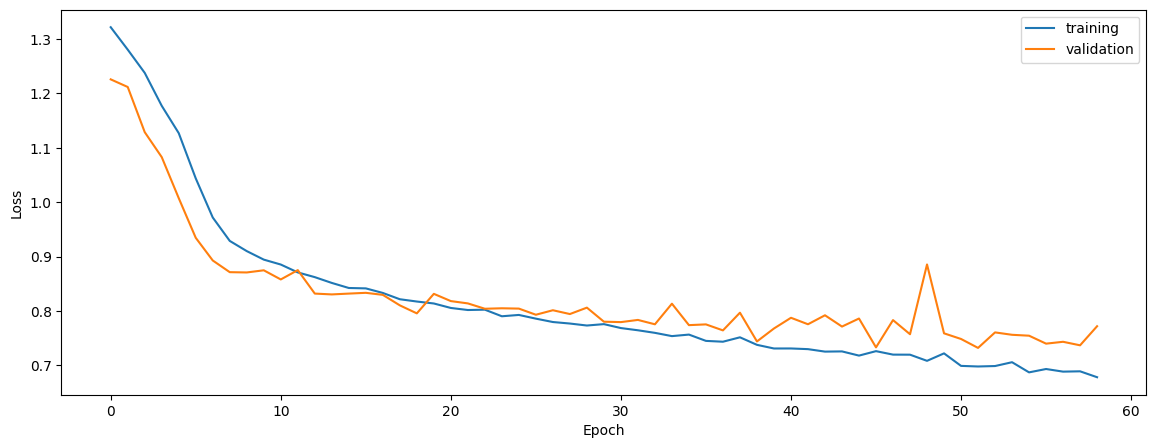

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7196642968365842
0.7207337343675796
0.7132036423841059


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7196642968365842
0.7207337343675796
0.7132036423841059


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7215876213540215
0.7214894201703764
0.7047909349943675


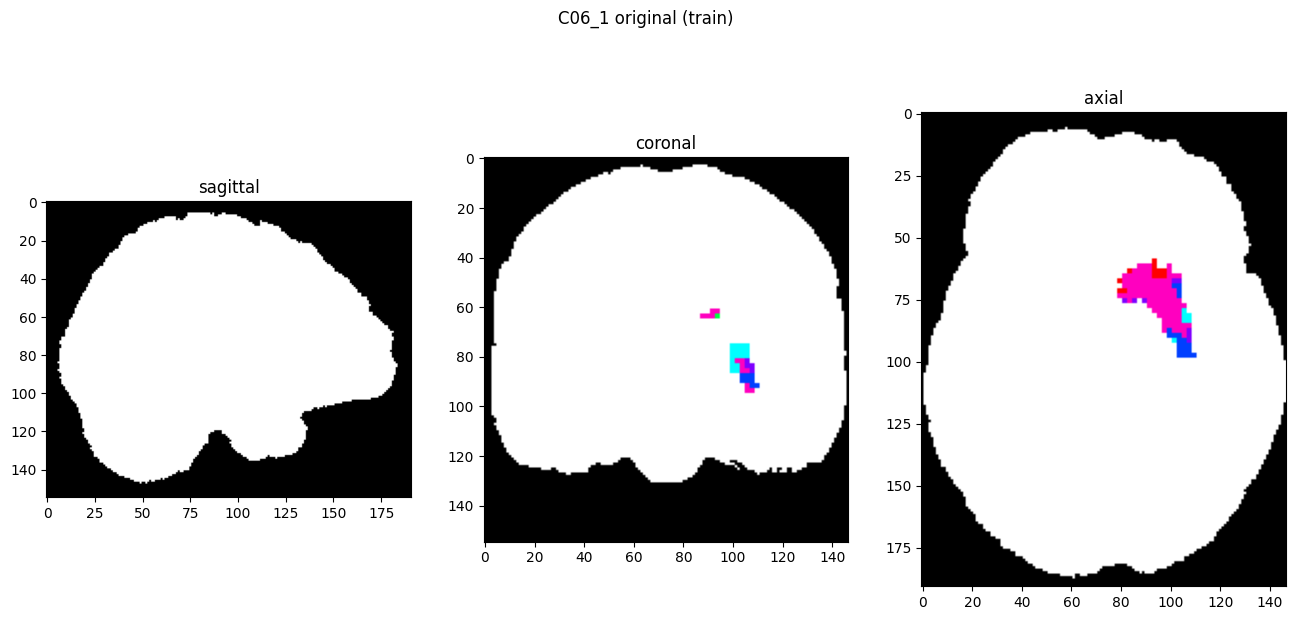

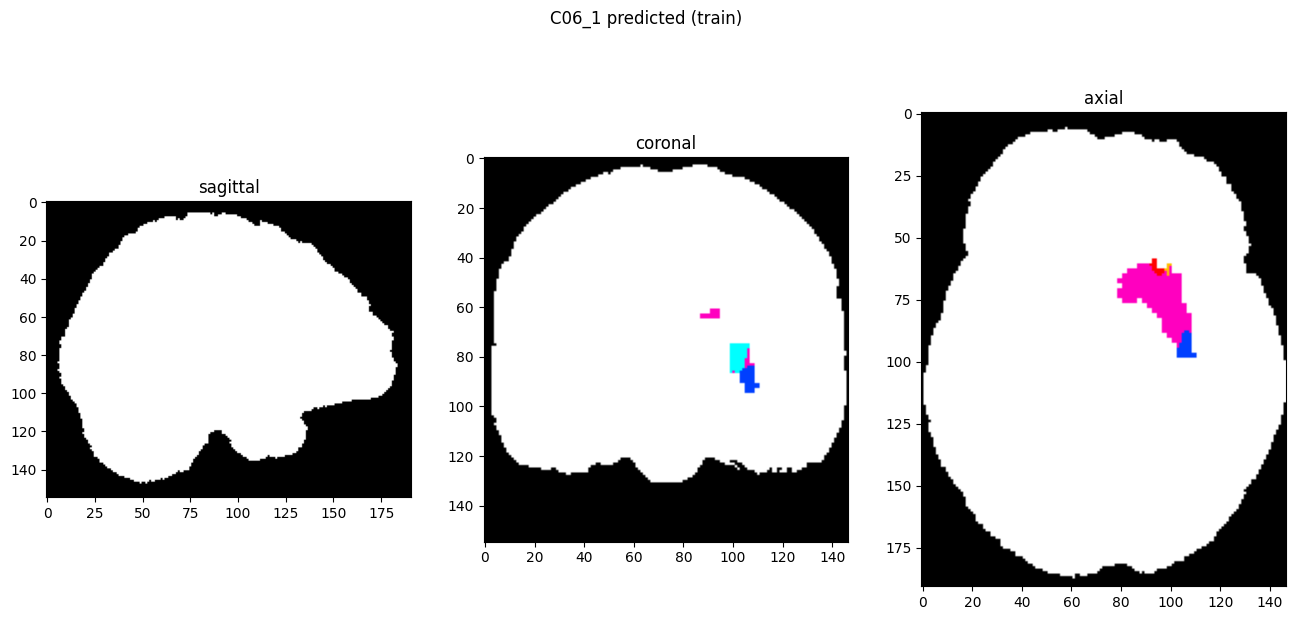

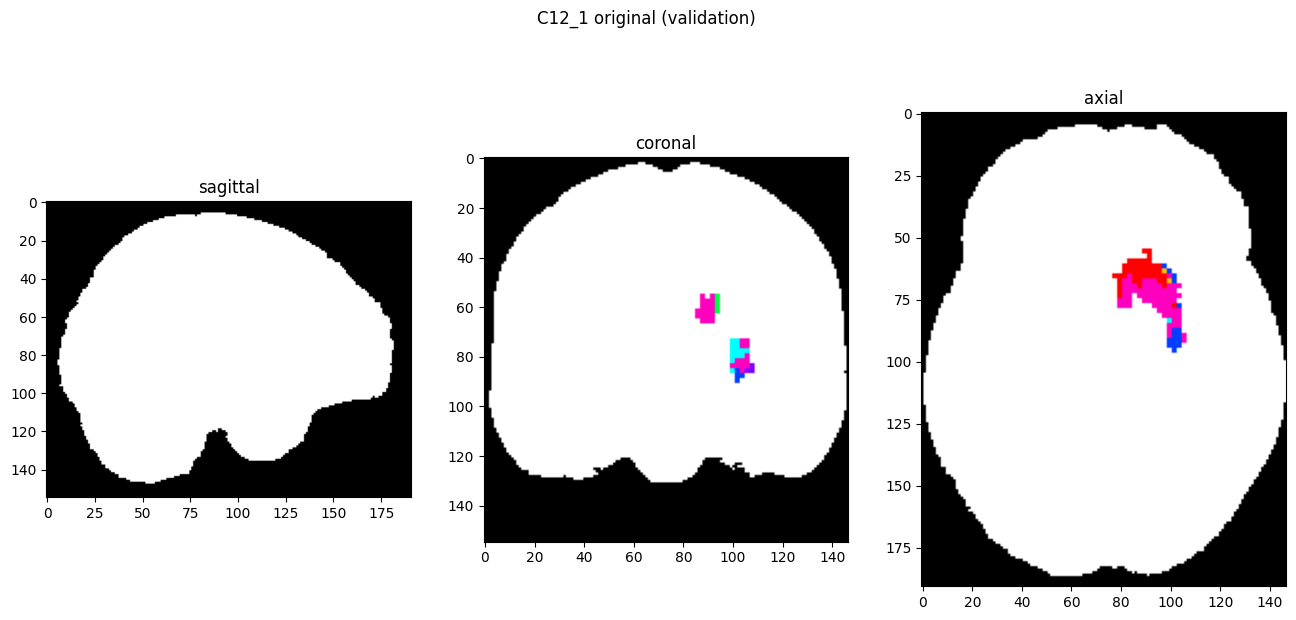

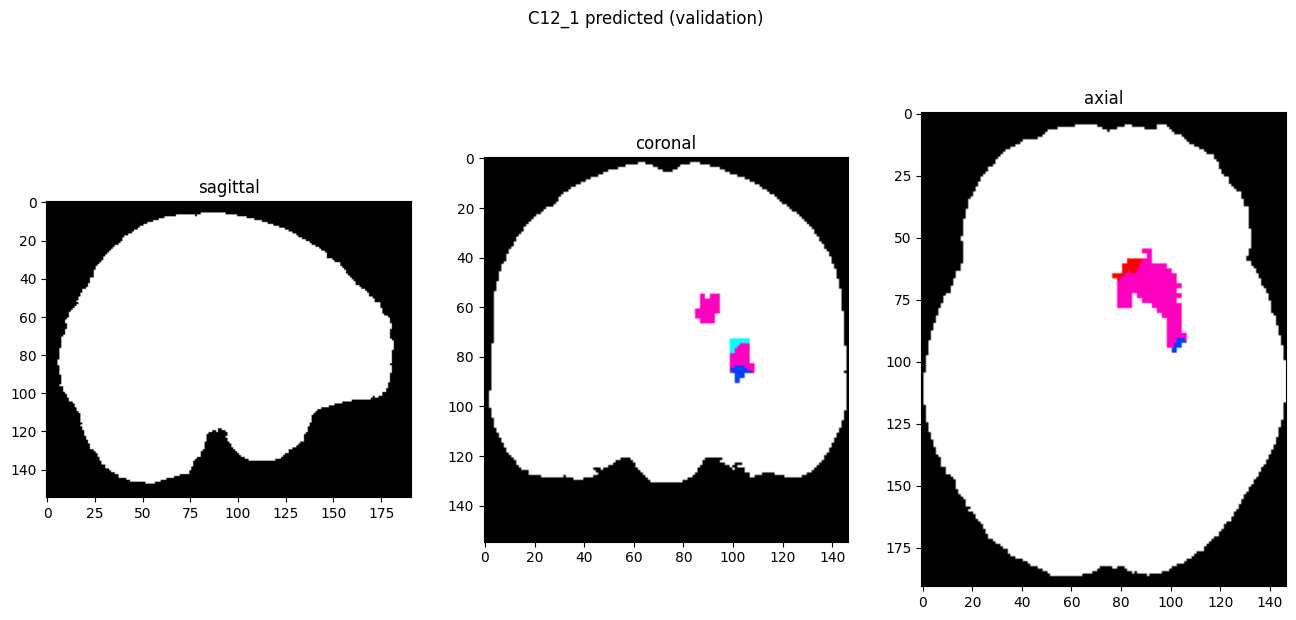

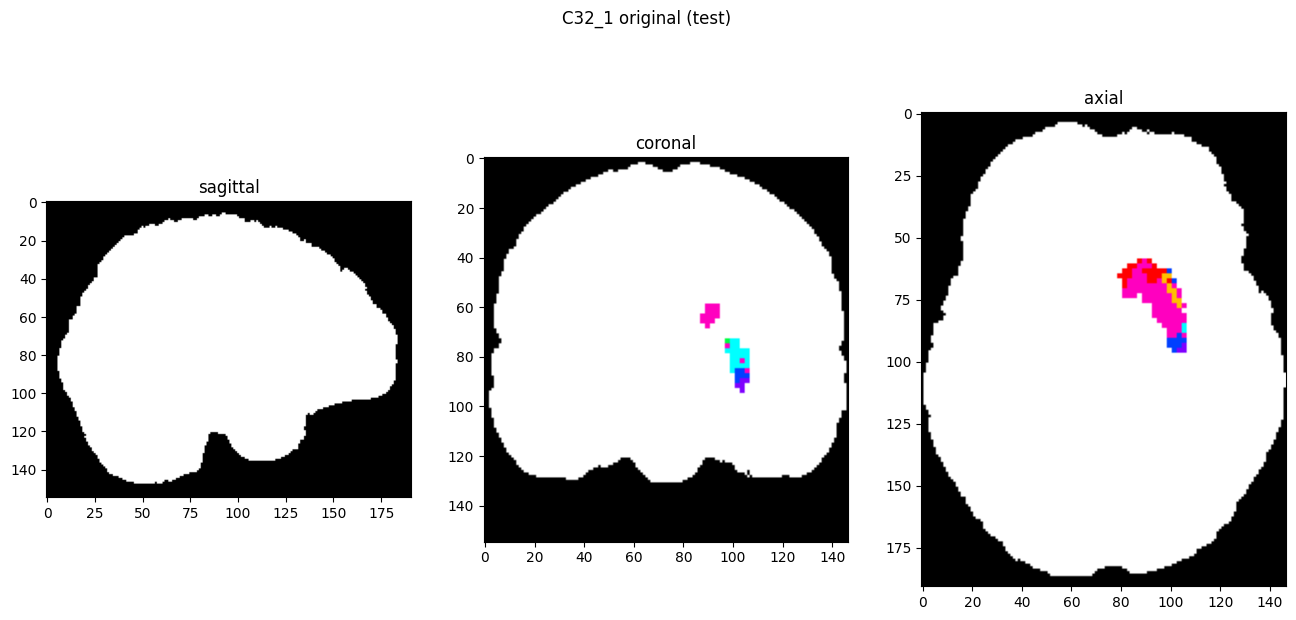

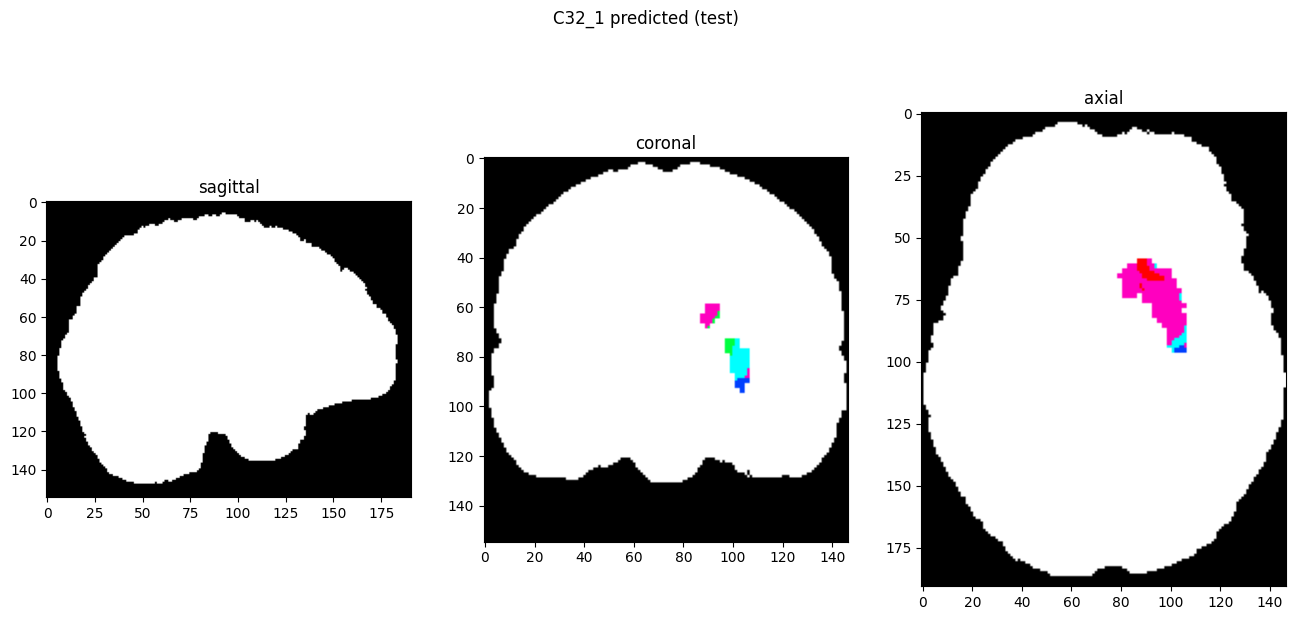

In [10]:
showResults(model, gen, threshold=0)